# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/semantic_graphs_output/graph_semantic.pkl'
    NODE_MAPPING_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/semantic_graphs_output/node_mapping_semantic.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    if "sorted_index_to_article_id" in node_map:
        node_map = node_map["sorted_index_to_article_id"]

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def rerank_articles_graph_only(article_ids, graph_adj_w, aid_to_idx, idx_to_aid):
    scores = {}
    for aid in article_ids:
        if aid not in aid_to_idx:
            continue
        idx = aid_to_idx[aid]
        for nbr, w in graph_adj_w[idx].items():
            aid_nbr = idx_to_aid[nbr]
            scores[aid_nbr] = scores.get(aid_nbr, 0) + w
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [aid for aid, _ in ranked][:config.TOP_K_ARTICLES_RERANK]


## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE, mmap_mode='r')
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE, faiss.IO_FLAG_MMAP)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(
    config.GRAPH_PATH,
    config.NODE_MAPPING_PATH
)

# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.39s/it]

100%|██████████| 1/1 [00:03<00:00,  3.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 31.19it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:05<02:04,  5.91s/it]

  9%|▉         | 2/22 [00:08<01:21,  4.09s/it]

 14%|█▎        | 3/22 [00:17<02:00,  6.36s/it]

 18%|█▊        | 4/22 [00:19<01:23,  4.66s/it]

 23%|██▎       | 5/22 [00:24<01:16,  4.49s/it]

 27%|██▋       | 6/22 [00:56<03:46, 14.15s/it]

 32%|███▏      | 7/22 [01:10<03:28, 13.87s/it]

 36%|███▋      | 8/22 [01:11<02:18,  9.91s/it]

 41%|████      | 9/22 [01:13<01:34,  7.27s/it]

 45%|████▌     | 10/22 [01:14<01:04,  5.35s/it]

 50%|█████     | 11/22 [01:18<00:53,  4.90s/it]

 55%|█████▍    | 12/22 [01:42<01:47, 10.74s/it]

 59%|█████▉    | 13/22 [01:54<01:40, 11.16s/it]

 64%|██████▎   | 14/22 [01:58<01:12,  9.06s/it]

 68%|██████▊   | 15/22 [02:01<00:49,  7.14s/it]

 73%|███████▎  | 16/22 [02:06<00:39,  6.62s/it]

 77%|███████▋  | 17/22 [02:10<00:28,  5.78s/it]

 82%|████████▏ | 18/22 [02:16<00:23,  5.85s/it]

 86%|████████▋ | 19/22 [02:19<00:15,  5.14s/it]

 91%|█████████ | 20/22 [02:27<00:11,  5.82s/it]

 95%|█████████▌| 21/22 [02:29<00:04,  4.72s/it]

100%|██████████| 22/22 [02:35<00:00,  5.22s/it]

100%|██████████| 22/22 [02:35<00:00,  7.09s/it]


Article Retrieval Metrics:
mAP: 0.0065
MRR: 0.0065
Recall@1: 0.0000
Recall@5: 0.0000
Recall@10: 0.0455
Recall@20: 0.0455
Recall@50: 0.0455

Image Retrieval Metrics:
mAP: 0.0455
MRR: 0.0455
Recall@1: 0.0455
Recall@5: 0.0455
Recall@10: 0.0455
Recall@20: 0.0455
Recall@50: 0.0455


# VISUALIZATION

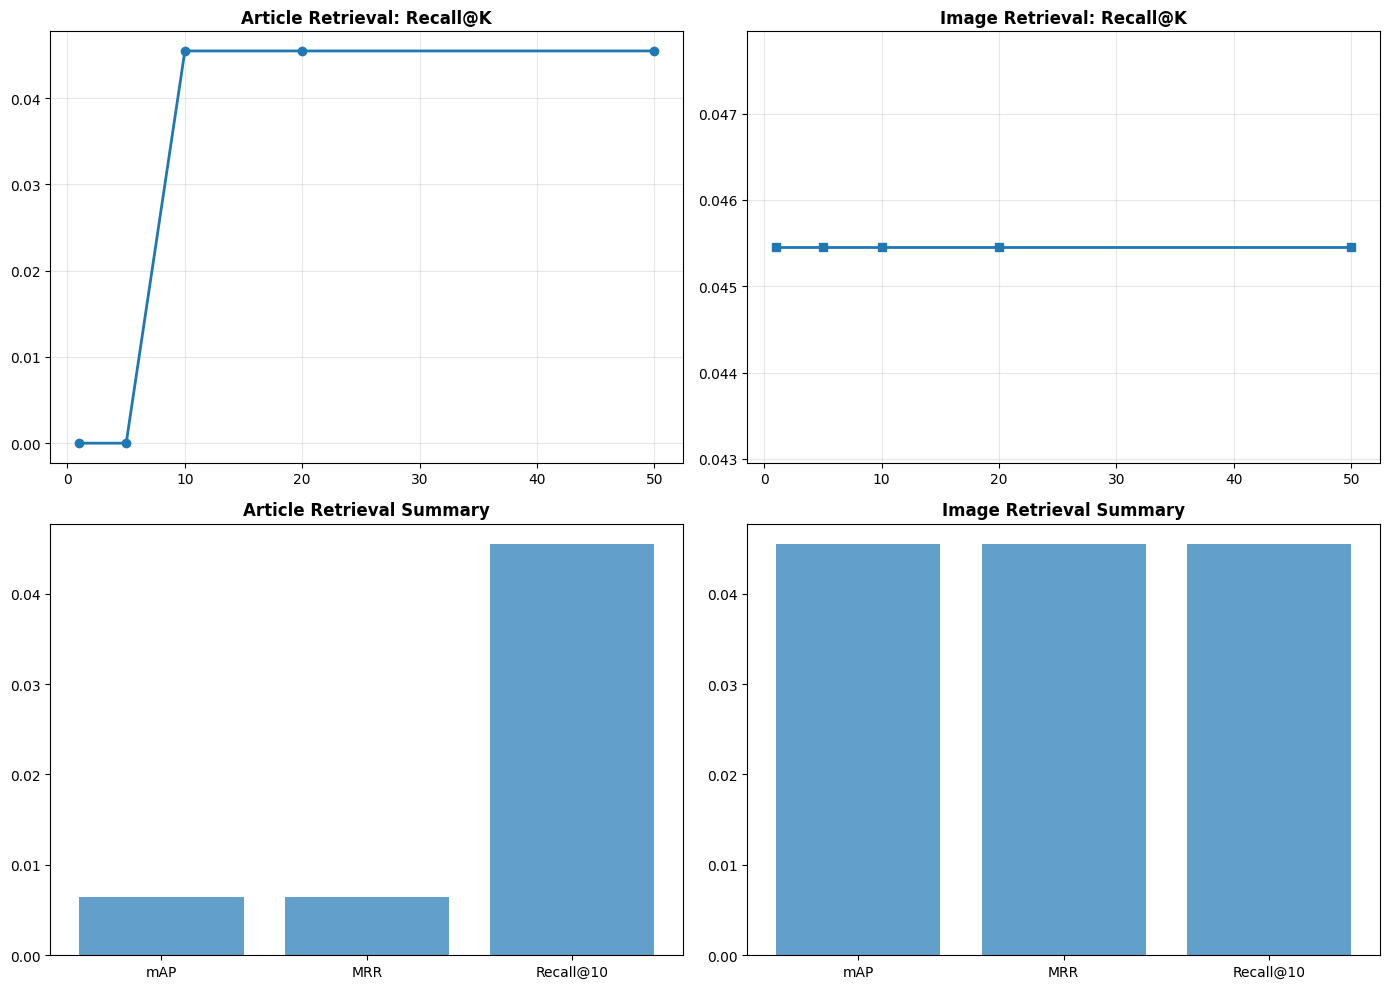

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:36,  1.26it/s]

  4%|▍         | 2/47 [00:01<00:36,  1.24it/s]

  6%|▋         | 3/47 [00:02<00:36,  1.22it/s]

  9%|▊         | 4/47 [00:03<00:34,  1.24it/s]

 11%|█         | 5/47 [00:03<00:28,  1.47it/s]

 13%|█▎        | 6/47 [00:04<00:26,  1.58it/s]

 15%|█▍        | 7/47 [00:04<00:22,  1.78it/s]

 17%|█▋        | 8/47 [00:05<00:20,  1.90it/s]

 19%|█▉        | 9/47 [00:05<00:19,  1.92it/s]

 21%|██▏       | 10/47 [00:06<00:19,  1.90it/s]

 23%|██▎       | 11/47 [00:06<00:18,  1.96it/s]

 26%|██▌       | 12/47 [00:07<00:17,  2.00it/s]

 28%|██▊       | 13/47 [00:07<00:16,  2.01it/s]

 30%|██▉       | 14/47 [00:08<00:15,  2.10it/s]

 32%|███▏      | 15/47 [00:08<00:14,  2.18it/s]

 34%|███▍      | 16/47 [00:08<00:14,  2.11it/s]

 36%|███▌      | 17/47 [00:09<00:14,  2.12it/s]

 38%|███▊      | 18/47 [00:10<00:15,  1.84it/s]

 40%|████      | 19/47 [00:10<00:14,  1.90it/s]

 43%|████▎     | 20/47 [00:11<00:14,  1.92it/s]

 45%|████▍     | 21/47 [00:11<00:13,  1.94it/s]

 47%|████▋     | 22/47 [00:12<00:12,  2.02it/s]

 49%|████▉     | 23/47 [00:12<00:11,  2.07it/s]

 51%|█████     | 24/47 [00:13<00:11,  1.97it/s]

 53%|█████▎    | 25/47 [00:13<00:11,  1.99it/s]

 55%|█████▌    | 26/47 [00:13<00:10,  2.08it/s]

 57%|█████▋    | 27/47 [00:14<00:09,  2.07it/s]

 60%|█████▉    | 28/47 [00:14<00:09,  2.10it/s]

 62%|██████▏   | 29/47 [00:15<00:09,  1.88it/s]

 64%|██████▍   | 30/47 [00:17<00:13,  1.25it/s]

 66%|██████▌   | 31/47 [00:17<00:11,  1.37it/s]

 68%|██████▊   | 32/47 [00:17<00:09,  1.62it/s]

 70%|███████   | 33/47 [00:18<00:07,  1.76it/s]

 72%|███████▏  | 34/47 [00:18<00:06,  1.87it/s]

 74%|███████▍  | 35/47 [00:19<00:05,  2.04it/s]

 77%|███████▋  | 36/47 [00:19<00:05,  1.96it/s]

 79%|███████▊  | 37/47 [00:20<00:05,  2.00it/s]

 81%|████████  | 38/47 [00:20<00:04,  1.84it/s]

 83%|████████▎ | 39/47 [00:21<00:04,  1.75it/s]

 85%|████████▌ | 40/47 [00:22<00:03,  1.76it/s]

 87%|████████▋ | 41/47 [00:22<00:03,  1.77it/s]

 89%|████████▉ | 42/47 [00:23<00:02,  1.73it/s]

 91%|█████████▏| 43/47 [00:23<00:02,  1.77it/s]

 94%|█████████▎| 44/47 [00:24<00:01,  1.64it/s]

 96%|█████████▌| 45/47 [00:25<00:01,  1.72it/s]

 98%|█████████▊| 46/47 [00:25<00:00,  1.80it/s]

100%|██████████| 47/47 [00:26<00:00,  1.86it/s]

100%|██████████| 47/47 [00:26<00:00,  1.80it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:06,  6.77it/s]

  4%|▍         | 2/47 [00:00<00:06,  7.13it/s]

  6%|▋         | 3/47 [00:00<00:06,  7.06it/s]

  9%|▊         | 4/47 [00:00<00:06,  6.96it/s]

 11%|█         | 5/47 [00:00<00:05,  7.17it/s]

 13%|█▎        | 6/47 [00:00<00:05,  7.40it/s]

 15%|█▍        | 7/47 [00:00<00:05,  7.31it/s]

 17%|█▋        | 8/47 [00:01<00:05,  7.41it/s]

 19%|█▉        | 9/47 [00:01<00:05,  7.23it/s]

 21%|██▏       | 10/47 [00:01<00:05,  6.94it/s]

 23%|██▎       | 11/47 [00:01<00:05,  7.00it/s]

 26%|██▌       | 12/47 [00:01<00:05,  6.72it/s]

 28%|██▊       | 13/47 [00:01<00:05,  6.55it/s]

 30%|██▉       | 14/47 [00:02<00:04,  6.65it/s]

 32%|███▏      | 15/47 [00:02<00:05,  6.09it/s]

 34%|███▍      | 16/47 [00:02<00:05,  5.91it/s]

 36%|███▌      | 17/47 [00:02<00:04,  6.08it/s]

 38%|███▊      | 18/47 [00:02<00:04,  5.96it/s]

 40%|████      | 19/47 [00:02<00:04,  5.90it/s]

 43%|████▎     | 20/47 [00:03<00:04,  6.27it/s]

 45%|████▍     | 21/47 [00:03<00:03,  6.51it/s]

 47%|████▋     | 22/47 [00:03<00:03,  6.99it/s]

 49%|████▉     | 23/47 [00:03<00:03,  7.20it/s]

 51%|█████     | 24/47 [00:03<00:03,  7.15it/s]

 53%|█████▎    | 25/47 [00:03<00:02,  7.42it/s]

 55%|█████▌    | 26/47 [00:03<00:02,  7.35it/s]

 57%|█████▋    | 27/47 [00:03<00:02,  7.66it/s]

 60%|█████▉    | 28/47 [00:04<00:02,  7.73it/s]

 62%|██████▏   | 29/47 [00:04<00:02,  7.57it/s]

 64%|██████▍   | 30/47 [00:04<00:02,  7.54it/s]

 66%|██████▌   | 31/47 [00:04<00:02,  6.79it/s]

 68%|██████▊   | 32/47 [00:04<00:02,  6.61it/s]

 70%|███████   | 33/47 [00:04<00:02,  6.56it/s]

 72%|███████▏  | 34/47 [00:04<00:01,  6.94it/s]

 74%|███████▍  | 35/47 [00:05<00:01,  7.19it/s]

 77%|███████▋  | 36/47 [00:05<00:01,  7.39it/s]

 79%|███████▊  | 37/47 [00:05<00:01,  7.28it/s]

 81%|████████  | 38/47 [00:05<00:01,  7.08it/s]

 83%|████████▎ | 39/47 [00:05<00:01,  7.21it/s]

 85%|████████▌ | 40/47 [00:05<00:00,  7.26it/s]

 87%|████████▋ | 41/47 [00:05<00:00,  7.45it/s]

 89%|████████▉ | 42/47 [00:06<00:00,  7.47it/s]

 91%|█████████▏| 43/47 [00:06<00:00,  7.15it/s]

 94%|█████████▎| 44/47 [00:06<00:00,  7.25it/s]

 96%|█████████▌| 45/47 [00:06<00:00,  7.22it/s]

 98%|█████████▊| 46/47 [00:06<00:00,  7.18it/s]

100%|██████████| 47/47 [00:06<00:00,  7.39it/s]

100%|██████████| 47/47 [00:06<00:00,  6.98it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [01:13<61:10:37, 73.44s/it]

  0%|          | 2/3000 [02:26<60:50:55, 73.07s/it]

  0%|          | 3/3000 [02:52<42:54:37, 51.54s/it]

  0%|          | 4/3000 [04:52<65:28:25, 78.67s/it]

  0%|          | 5/3000 [05:09<46:55:09, 56.40s/it]

  0%|          | 6/3000 [05:26<35:48:39, 43.06s/it]

  0%|          | 7/3000 [05:56<32:18:24, 38.86s/it]

  0%|          | 8/3000 [06:44<34:34:47, 41.61s/it]

  0%|          | 9/3000 [07:09<30:22:31, 36.56s/it]

  0%|          | 10/3000 [07:27<25:36:56, 30.84s/it]

  0%|          | 11/3000 [07:29<18:12:05, 21.92s/it]

  0%|          | 12/3000 [11:14<69:34:07, 83.82s/it]

  0%|          | 13/3000 [11:27<51:34:30, 62.16s/it]

  0%|          | 14/3000 [11:31<37:03:46, 44.68s/it]

  0%|          | 15/3000 [12:01<33:30:57, 40.42s/it]

  1%|          | 16/3000 [12:04<24:04:38, 29.05s/it]

  1%|          | 17/3000 [12:05<17:00:00, 20.52s/it]

  1%|          | 18/3000 [12:07<12:23:44, 14.96s/it]

  1%|          | 19/3000 [12:32<14:57:52, 18.07s/it]

  1%|          | 20/3000 [12:53<15:39:59, 18.93s/it]

  1%|          | 21/3000 [13:35<21:16:15, 25.71s/it]

  1%|          | 22/3000 [14:35<29:50:45, 36.08s/it]

  1%|          | 23/3000 [14:49<24:25:32, 29.54s/it]

  1%|          | 24/3000 [14:55<18:29:22, 22.37s/it]

  1%|          | 25/3000 [14:56<13:09:11, 15.92s/it]

  1%|          | 26/3000 [14:56<9:22:14, 11.34s/it] 

  1%|          | 27/3000 [15:02<7:52:54,  9.54s/it]

  1%|          | 28/3000 [15:03<5:51:05,  7.09s/it]

  1%|          | 29/3000 [15:04<4:22:37,  5.30s/it]

  1%|          | 30/3000 [15:10<4:30:46,  5.47s/it]

  1%|          | 31/3000 [15:32<8:39:32, 10.50s/it]

  1%|          | 32/3000 [17:14<31:16:32, 37.94s/it]

  1%|          | 33/3000 [17:17<22:34:55, 27.40s/it]

  1%|          | 34/3000 [17:41<21:38:12, 26.26s/it]

  1%|          | 35/3000 [18:24<25:49:10, 31.35s/it]

  1%|          | 36/3000 [18:44<22:57:08, 27.88s/it]

  1%|          | 37/3000 [18:45<16:28:57, 20.03s/it]

  1%|▏         | 38/3000 [18:51<13:01:32, 15.83s/it]

  1%|▏         | 39/3000 [18:53<9:28:43, 11.52s/it] 

  1%|▏         | 40/3000 [18:54<6:54:34,  8.40s/it]

  1%|▏         | 41/3000 [20:09<23:24:03, 28.47s/it]

  1%|▏         | 42/3000 [20:22<19:27:27, 23.68s/it]

  1%|▏         | 43/3000 [20:46<19:36:47, 23.88s/it]

  1%|▏         | 44/3000 [20:57<16:27:15, 20.04s/it]

  2%|▏         | 45/3000 [22:15<30:41:46, 37.40s/it]

  2%|▏         | 46/3000 [23:10<34:57:33, 42.60s/it]

  2%|▏         | 47/3000 [23:11<24:50:39, 30.29s/it]

  2%|▏         | 48/3000 [24:17<33:31:30, 40.88s/it]

  2%|▏         | 49/3000 [24:19<23:53:32, 29.15s/it]

  2%|▏         | 50/3000 [24:24<18:05:08, 22.07s/it]

  2%|▏         | 51/3000 [27:03<51:44:53, 63.17s/it]

  2%|▏         | 52/3000 [27:37<44:23:19, 54.21s/it]

  2%|▏         | 53/3000 [27:48<33:49:02, 41.31s/it]

  2%|▏         | 54/3000 [27:58<26:05:43, 31.89s/it]

  2%|▏         | 55/3000 [28:15<22:31:05, 27.53s/it]

  2%|▏         | 56/3000 [28:46<23:23:31, 28.60s/it]

  2%|▏         | 57/3000 [28:47<16:39:15, 20.37s/it]

  2%|▏         | 58/3000 [31:13<47:14:29, 57.81s/it]

  2%|▏         | 59/3000 [32:06<46:08:56, 56.49s/it]

  2%|▏         | 60/3000 [32:46<42:12:52, 51.69s/it]

  2%|▏         | 61/3000 [33:41<42:57:53, 52.63s/it]

  2%|▏         | 62/3000 [34:02<35:07:53, 43.05s/it]

  2%|▏         | 63/3000 [34:33<32:09:34, 39.42s/it]

  2%|▏         | 64/3000 [36:57<57:49:21, 70.90s/it]

  2%|▏         | 65/3000 [37:15<44:44:15, 54.87s/it]

  2%|▏         | 66/3000 [37:15<31:25:33, 38.56s/it]

  2%|▏         | 67/3000 [37:26<24:37:57, 30.23s/it]

  2%|▏         | 68/3000 [38:13<28:39:36, 35.19s/it]

  2%|▏         | 69/3000 [39:01<31:48:26, 39.07s/it]

  2%|▏         | 70/3000 [39:05<23:08:02, 28.42s/it]

  2%|▏         | 71/3000 [39:19<19:48:31, 24.35s/it]

  2%|▏         | 72/3000 [39:39<18:32:46, 22.80s/it]

  2%|▏         | 73/3000 [39:53<16:23:15, 20.16s/it]

  2%|▏         | 74/3000 [40:06<14:49:53, 18.25s/it]

  2%|▎         | 75/3000 [40:22<14:13:14, 17.50s/it]

  3%|▎         | 76/3000 [41:09<21:15:44, 26.18s/it]

  3%|▎         | 77/3000 [41:48<24:27:22, 30.12s/it]

  3%|▎         | 78/3000 [41:50<17:34:50, 21.66s/it]

  3%|▎         | 79/3000 [42:02<15:12:45, 18.75s/it]

  3%|▎         | 80/3000 [42:53<23:10:20, 28.57s/it]

  3%|▎         | 81/3000 [43:27<24:22:03, 30.05s/it]

  3%|▎         | 82/3000 [43:28<17:21:27, 21.41s/it]

  3%|▎         | 83/3000 [43:29<12:16:44, 15.15s/it]

  3%|▎         | 84/3000 [43:29<8:45:35, 10.81s/it] 

  3%|▎         | 85/3000 [43:34<7:20:45,  9.07s/it]

  3%|▎         | 86/3000 [43:45<7:52:14,  9.72s/it]

  3%|▎         | 87/3000 [44:08<10:52:39, 13.44s/it]

  3%|▎         | 88/3000 [44:23<11:25:31, 14.12s/it]

  3%|▎         | 89/3000 [44:35<10:49:23, 13.38s/it]

  3%|▎         | 90/3000 [44:44<9:47:26, 12.11s/it] 

  3%|▎         | 91/3000 [44:53<8:55:11, 11.04s/it]

  3%|▎         | 92/3000 [44:58<7:37:29,  9.44s/it]

  3%|▎         | 93/3000 [45:07<7:31:12,  9.31s/it]

  3%|▎         | 94/3000 [45:33<11:29:39, 14.24s/it]

  3%|▎         | 95/3000 [45:34<8:16:32, 10.26s/it] 

  3%|▎         | 96/3000 [45:35<6:08:12,  7.61s/it]

  3%|▎         | 97/3000 [45:38<4:57:55,  6.16s/it]

  3%|▎         | 98/3000 [45:52<6:44:01,  8.35s/it]

  3%|▎         | 99/3000 [46:01<7:04:05,  8.77s/it]

  3%|▎         | 100/3000 [46:07<6:23:00,  7.92s/it]

  3%|▎         | 101/3000 [46:23<8:08:05, 10.10s/it]

  3%|▎         | 102/3000 [47:30<21:56:47, 27.26s/it]

  3%|▎         | 103/3000 [48:18<26:57:21, 33.50s/it]

  3%|▎         | 104/3000 [48:22<19:47:41, 24.61s/it]

  4%|▎         | 105/3000 [48:23<14:04:26, 17.50s/it]

  4%|▎         | 106/3000 [49:40<28:26:26, 35.38s/it]

  4%|▎         | 107/3000 [50:00<24:41:21, 30.72s/it]

  4%|▎         | 108/3000 [50:16<21:07:29, 26.30s/it]

  4%|▎         | 109/3000 [50:37<19:50:47, 24.71s/it]

  4%|▎         | 110/3000 [50:51<17:22:17, 21.64s/it]

  4%|▎         | 111/3000 [50:57<13:35:10, 16.93s/it]

  4%|▎         | 112/3000 [51:08<12:02:03, 15.00s/it]

  4%|▍         | 113/3000 [51:09<8:38:29, 10.78s/it] 

  4%|▍         | 114/3000 [51:47<15:15:40, 19.04s/it]

  4%|▍         | 115/3000 [53:15<31:58:44, 39.90s/it]

  4%|▍         | 116/3000 [54:23<38:41:00, 48.29s/it]

  4%|▍         | 117/3000 [57:23<70:19:17, 87.81s/it]

  4%|▍         | 118/3000 [57:44<54:08:19, 67.63s/it]

  4%|▍         | 119/3000 [57:45<38:15:15, 47.80s/it]

  4%|▍         | 120/3000 [57:47<27:08:52, 33.94s/it]

  4%|▍         | 121/3000 [58:40<31:40:35, 39.61s/it]

  4%|▍         | 122/3000 [1:01:19<60:23:05, 75.53s/it]

  4%|▍         | 123/3000 [1:02:17<56:05:30, 70.19s/it]

  4%|▍         | 124/3000 [1:02:19<39:48:15, 49.82s/it]

  4%|▍         | 125/3000 [1:02:21<28:23:25, 35.55s/it]

  4%|▍         | 126/3000 [1:02:24<20:31:34, 25.71s/it]

  4%|▍         | 127/3000 [1:02:40<18:11:27, 22.79s/it]

  4%|▍         | 128/3000 [1:03:15<20:57:26, 26.27s/it]

  4%|▍         | 129/3000 [1:04:00<25:33:32, 32.05s/it]

  4%|▍         | 130/3000 [1:05:13<35:25:09, 44.43s/it]

  4%|▍         | 131/3000 [1:06:58<49:48:55, 62.51s/it]

  4%|▍         | 132/3000 [1:08:20<54:29:24, 68.40s/it]

  4%|▍         | 133/3000 [1:09:34<55:40:59, 69.92s/it]

  4%|▍         | 134/3000 [1:10:49<56:55:41, 71.51s/it]

  4%|▍         | 135/3000 [1:11:03<43:14:05, 54.33s/it]

  5%|▍         | 136/3000 [1:11:49<41:08:03, 51.71s/it]

  5%|▍         | 137/3000 [1:12:05<32:33:48, 40.95s/it]

  5%|▍         | 138/3000 [1:12:25<27:34:23, 34.68s/it]

  5%|▍         | 139/3000 [1:12:40<22:55:40, 28.85s/it]

  5%|▍         | 140/3000 [1:13:25<26:50:23, 33.78s/it]

  5%|▍         | 141/3000 [1:13:38<21:50:51, 27.51s/it]

  5%|▍         | 142/3000 [1:13:49<17:53:28, 22.54s/it]

  5%|▍         | 143/3000 [1:13:56<14:11:21, 17.88s/it]

  5%|▍         | 144/3000 [1:14:26<17:05:01, 21.53s/it]

  5%|▍         | 145/3000 [1:14:31<13:09:55, 16.60s/it]

  5%|▍         | 146/3000 [1:14:33<9:45:12, 12.30s/it] 

  5%|▍         | 147/3000 [1:14:38<7:48:27,  9.85s/it]

  5%|▍         | 148/3000 [1:14:39<5:43:33,  7.23s/it]

  5%|▍         | 149/3000 [1:15:57<22:36:28, 28.55s/it]

  5%|▌         | 150/3000 [1:16:02<16:56:20, 21.40s/it]

  5%|▌         | 151/3000 [1:17:18<30:01:40, 37.94s/it]

  5%|▌         | 152/3000 [1:17:52<29:07:42, 36.82s/it]

  5%|▌         | 153/3000 [1:18:03<22:53:31, 28.95s/it]

  5%|▌         | 154/3000 [1:18:56<28:32:22, 36.10s/it]

  5%|▌         | 155/3000 [1:21:39<58:34:23, 74.12s/it]

  5%|▌         | 156/3000 [1:22:33<53:53:42, 68.22s/it]

  5%|▌         | 157/3000 [1:23:16<47:56:28, 60.71s/it]

  5%|▌         | 158/3000 [1:24:03<44:32:10, 56.41s/it]

  5%|▌         | 159/3000 [1:24:52<42:47:41, 54.23s/it]

  5%|▌         | 160/3000 [1:25:48<43:19:54, 54.93s/it]

  5%|▌         | 161/3000 [1:26:19<37:33:45, 47.63s/it]

  5%|▌         | 162/3000 [1:26:21<26:43:57, 33.91s/it]

  5%|▌         | 163/3000 [1:27:00<28:04:18, 35.62s/it]

  5%|▌         | 164/3000 [1:27:06<21:01:54, 26.70s/it]

  6%|▌         | 165/3000 [1:27:16<16:57:12, 21.53s/it]

  6%|▌         | 166/3000 [1:27:21<13:00:22, 16.52s/it]

  6%|▌         | 167/3000 [1:27:48<15:32:40, 19.75s/it]

  6%|▌         | 168/3000 [1:28:21<18:36:14, 23.65s/it]

  6%|▌         | 169/3000 [1:29:20<26:58:57, 34.31s/it]

  6%|▌         | 170/3000 [1:29:52<26:31:19, 33.74s/it]

  6%|▌         | 171/3000 [1:32:23<54:09:25, 68.92s/it]

  6%|▌         | 172/3000 [1:32:24<38:09:07, 48.57s/it]

  6%|▌         | 173/3000 [1:32:43<31:08:11, 39.65s/it]

  6%|▌         | 174/3000 [1:33:18<30:06:04, 38.35s/it]

  6%|▌         | 175/3000 [1:33:45<27:16:02, 34.75s/it]

  6%|▌         | 176/3000 [1:34:45<33:14:09, 42.37s/it]

  6%|▌         | 177/3000 [1:35:41<36:20:15, 46.34s/it]

  6%|▌         | 178/3000 [1:36:38<38:55:36, 49.66s/it]

  6%|▌         | 179/3000 [1:37:29<39:15:53, 50.11s/it]

  6%|▌         | 180/3000 [1:38:27<41:09:02, 52.53s/it]

  6%|▌         | 181/3000 [1:39:15<40:04:51, 51.19s/it]

  6%|▌         | 182/3000 [1:40:15<42:06:10, 53.79s/it]

  6%|▌         | 183/3000 [1:42:09<56:13:39, 71.86s/it]

  6%|▌         | 184/3000 [1:42:44<47:29:50, 60.72s/it]

  6%|▌         | 185/3000 [1:42:57<36:19:47, 46.46s/it]

  6%|▌         | 186/3000 [1:43:30<33:02:10, 42.26s/it]

  6%|▌         | 187/3000 [1:43:52<28:26:50, 36.41s/it]

  6%|▋         | 188/3000 [1:43:56<20:49:48, 26.67s/it]

  6%|▋         | 189/3000 [1:43:59<15:14:11, 19.51s/it]

  6%|▋         | 190/3000 [1:46:42<48:51:16, 62.59s/it]

  6%|▋         | 191/3000 [1:46:45<34:56:15, 44.78s/it]

  6%|▋         | 192/3000 [1:47:26<33:52:00, 43.42s/it]

  6%|▋         | 193/3000 [1:48:26<37:42:14, 48.36s/it]

  6%|▋         | 194/3000 [1:49:18<38:45:03, 49.72s/it]

  6%|▋         | 195/3000 [1:49:54<35:28:00, 45.52s/it]

  7%|▋         | 196/3000 [1:50:18<30:28:18, 39.12s/it]

  7%|▋         | 197/3000 [1:51:00<31:04:25, 39.91s/it]

  7%|▋         | 198/3000 [1:51:35<29:58:19, 38.51s/it]

  7%|▋         | 199/3000 [1:51:37<21:19:57, 27.42s/it]

  7%|▋         | 200/3000 [1:53:07<35:53:16, 46.14s/it]

  7%|▋         | 201/3000 [1:54:02<38:01:07, 48.90s/it]

  7%|▋         | 202/3000 [1:59:15<99:33:32, 128.10s/it]

  7%|▋         | 203/3000 [1:59:34<74:05:45, 95.37s/it] 

  7%|▋         | 204/3000 [1:59:37<52:31:47, 67.64s/it]

  7%|▋         | 205/3000 [1:59:40<37:24:03, 48.17s/it]

  7%|▋         | 206/3000 [2:01:31<52:08:13, 67.18s/it]

  7%|▋         | 207/3000 [2:02:38<52:04:21, 67.12s/it]

  7%|▋         | 208/3000 [2:03:15<45:06:21, 58.16s/it]

  7%|▋         | 209/3000 [2:04:21<46:54:08, 60.50s/it]

  7%|▋         | 210/3000 [2:05:49<53:13:44, 68.68s/it]

  7%|▋         | 211/3000 [2:08:05<68:51:09, 88.87s/it]

  7%|▋         | 212/3000 [2:08:09<49:05:31, 63.39s/it]

  7%|▋         | 213/3000 [2:08:11<34:48:30, 44.96s/it]

  7%|▋         | 214/3000 [2:09:22<40:52:32, 52.82s/it]

  7%|▋         | 215/3000 [2:09:24<29:02:30, 37.54s/it]

  7%|▋         | 216/3000 [2:09:28<21:17:30, 27.53s/it]

  7%|▋         | 217/3000 [2:11:51<48:05:10, 62.20s/it]

  7%|▋         | 218/3000 [2:12:28<42:12:57, 54.63s/it]

  7%|▋         | 219/3000 [2:15:42<74:25:41, 96.35s/it]

  7%|▋         | 220/3000 [2:16:04<57:08:23, 73.99s/it]

  7%|▋         | 221/3000 [2:16:05<40:12:10, 52.08s/it]

  7%|▋         | 222/3000 [2:16:41<36:34:29, 47.40s/it]

  7%|▋         | 223/3000 [2:17:16<33:39:16, 43.63s/it]

  7%|▋         | 224/3000 [2:17:18<23:54:11, 31.00s/it]

  8%|▊         | 225/3000 [2:17:42<22:21:56, 29.01s/it]

  8%|▊         | 226/3000 [2:18:16<23:27:34, 30.45s/it]

  8%|▊         | 227/3000 [2:18:49<24:10:30, 31.38s/it]

  8%|▊         | 228/3000 [2:19:52<31:27:43, 40.86s/it]

  8%|▊         | 229/3000 [2:19:54<22:20:29, 29.03s/it]

  8%|▊         | 230/3000 [2:20:01<17:20:00, 22.53s/it]

  8%|▊         | 231/3000 [2:20:23<17:11:17, 22.35s/it]

  8%|▊         | 232/3000 [2:20:35<14:40:36, 19.09s/it]

  8%|▊         | 233/3000 [2:20:46<12:54:43, 16.80s/it]

  8%|▊         | 234/3000 [2:22:50<37:39:27, 49.01s/it]

  8%|▊         | 235/3000 [2:24:23<47:41:05, 62.09s/it]

  8%|▊         | 236/3000 [2:26:47<66:34:25, 86.71s/it]

  8%|▊         | 237/3000 [2:28:15<66:50:06, 87.08s/it]

  8%|▊         | 238/3000 [2:28:31<50:25:28, 65.72s/it]

  8%|▊         | 239/3000 [2:28:48<39:11:29, 51.10s/it]

  8%|▊         | 240/3000 [2:29:33<37:46:34, 49.27s/it]

  8%|▊         | 241/3000 [2:30:10<34:57:07, 45.61s/it]

  8%|▊         | 242/3000 [2:30:51<34:02:05, 44.43s/it]

  8%|▊         | 243/3000 [2:30:52<23:57:14, 31.28s/it]

  8%|▊         | 244/3000 [2:30:54<17:11:19, 22.45s/it]

  8%|▊         | 245/3000 [2:30:56<12:25:08, 16.23s/it]

  8%|▊         | 246/3000 [2:32:59<36:56:30, 48.29s/it]

  8%|▊         | 247/3000 [2:34:35<47:53:16, 62.62s/it]

  8%|▊         | 248/3000 [2:35:45<49:42:26, 65.02s/it]

  8%|▊         | 249/3000 [2:36:05<39:12:06, 51.30s/it]

  8%|▊         | 250/3000 [2:36:18<30:29:47, 39.92s/it]

  8%|▊         | 251/3000 [2:37:24<36:29:05, 47.78s/it]

  8%|▊         | 252/3000 [2:37:34<27:47:20, 36.40s/it]

  8%|▊         | 253/3000 [2:37:51<23:25:16, 30.69s/it]

  8%|▊         | 254/3000 [2:38:12<21:12:01, 27.79s/it]

  8%|▊         | 255/3000 [2:38:14<15:05:58, 19.80s/it]

  9%|▊         | 256/3000 [2:38:35<15:27:34, 20.28s/it]

  9%|▊         | 257/3000 [2:38:37<11:09:38, 14.65s/it]

  9%|▊         | 258/3000 [2:38:58<12:45:13, 16.74s/it]

  9%|▊         | 259/3000 [2:39:26<15:13:44, 20.00s/it]

  9%|▊         | 260/3000 [2:39:46<15:15:31, 20.05s/it]

  9%|▊         | 261/3000 [2:40:08<15:45:30, 20.71s/it]

  9%|▊         | 262/3000 [2:41:01<23:03:34, 30.32s/it]

  9%|▉         | 263/3000 [2:41:20<20:22:57, 26.81s/it]

  9%|▉         | 264/3000 [2:41:51<21:24:24, 28.17s/it]

  9%|▉         | 265/3000 [2:42:17<20:52:54, 27.49s/it]

  9%|▉         | 266/3000 [2:42:19<15:04:27, 19.85s/it]

  9%|▉         | 267/3000 [2:42:42<15:48:13, 20.82s/it]

  9%|▉         | 268/3000 [2:44:30<35:46:07, 47.13s/it]

  9%|▉         | 269/3000 [2:45:35<39:50:35, 52.52s/it]

  9%|▉         | 270/3000 [2:47:43<56:57:01, 75.10s/it]

  9%|▉         | 271/3000 [2:48:11<46:14:54, 61.01s/it]

  9%|▉         | 272/3000 [2:48:43<39:34:04, 52.22s/it]

  9%|▉         | 273/3000 [2:48:57<30:52:05, 40.75s/it]

  9%|▉         | 274/3000 [2:50:56<48:36:00, 64.18s/it]

  9%|▉         | 275/3000 [2:51:18<39:02:48, 51.58s/it]

  9%|▉         | 276/3000 [2:51:19<27:36:32, 36.49s/it]

  9%|▉         | 277/3000 [2:51:21<19:42:29, 26.06s/it]

  9%|▉         | 278/3000 [2:51:48<19:50:39, 26.25s/it]

  9%|▉         | 279/3000 [2:54:01<44:00:23, 58.22s/it]

  9%|▉         | 280/3000 [2:56:14<61:02:41, 80.79s/it]

  9%|▉         | 281/3000 [2:57:08<54:53:44, 72.68s/it]

  9%|▉         | 282/3000 [2:57:33<44:08:15, 58.46s/it]

  9%|▉         | 283/3000 [2:58:14<40:10:47, 53.24s/it]

  9%|▉         | 284/3000 [2:58:15<28:17:31, 37.50s/it]

 10%|▉         | 285/3000 [2:59:03<30:39:34, 40.65s/it]

 10%|▉         | 286/3000 [2:59:04<21:40:58, 28.76s/it]

 10%|▉         | 287/3000 [2:59:05<15:19:16, 20.33s/it]

 10%|▉         | 288/3000 [2:59:30<16:32:47, 21.96s/it]

 10%|▉         | 289/3000 [2:59:54<16:56:18, 22.49s/it]

 10%|▉         | 290/3000 [3:00:05<14:13:52, 18.90s/it]

 10%|▉         | 291/3000 [3:00:17<12:38:22, 16.80s/it]

 10%|▉         | 292/3000 [3:00:48<15:55:34, 21.17s/it]

 10%|▉         | 293/3000 [3:02:09<29:30:11, 39.24s/it]

 10%|▉         | 294/3000 [3:02:44<28:30:46, 37.93s/it]

 10%|▉         | 295/3000 [3:02:49<21:03:31, 28.03s/it]

 10%|▉         | 296/3000 [3:04:26<36:33:33, 48.67s/it]

 10%|▉         | 297/3000 [3:05:48<43:57:27, 58.55s/it]

 10%|▉         | 298/3000 [3:06:13<36:32:01, 48.68s/it]

 10%|▉         | 299/3000 [3:06:56<35:14:01, 46.96s/it]

 10%|█         | 300/3000 [3:08:18<43:09:58, 57.56s/it]

 10%|█         | 301/3000 [3:08:48<36:48:14, 49.09s/it]

 10%|█         | 302/3000 [3:09:02<28:57:43, 38.64s/it]

 10%|█         | 303/3000 [3:09:34<27:26:19, 36.63s/it]

 10%|█         | 304/3000 [3:10:12<27:40:50, 36.96s/it]

 10%|█         | 305/3000 [3:10:32<23:52:55, 31.90s/it]

 10%|█         | 306/3000 [3:10:33<17:02:15, 22.77s/it]

 10%|█         | 307/3000 [3:11:22<22:46:16, 30.44s/it]

 10%|█         | 308/3000 [3:11:25<16:44:24, 22.39s/it]

 10%|█         | 309/3000 [3:11:28<12:23:13, 16.57s/it]

 10%|█         | 310/3000 [3:12:31<22:40:22, 30.34s/it]

 10%|█         | 311/3000 [3:14:57<48:37:19, 65.09s/it]

 10%|█         | 312/3000 [3:15:16<38:12:42, 51.18s/it]

 10%|█         | 313/3000 [3:15:49<34:12:34, 45.83s/it]

 10%|█         | 314/3000 [3:16:12<29:03:29, 38.95s/it]

 10%|█         | 315/3000 [3:16:52<29:19:46, 39.32s/it]

 11%|█         | 316/3000 [3:17:53<34:16:24, 45.97s/it]

 11%|█         | 317/3000 [3:18:28<31:41:06, 42.51s/it]

 11%|█         | 318/3000 [3:18:45<26:04:16, 35.00s/it]

 11%|█         | 319/3000 [3:20:45<45:00:04, 60.43s/it]

 11%|█         | 320/3000 [3:20:46<31:41:57, 42.58s/it]

 11%|█         | 321/3000 [3:20:51<23:13:59, 31.22s/it]

 11%|█         | 322/3000 [3:21:14<21:27:57, 28.86s/it]

 11%|█         | 323/3000 [3:21:33<19:08:22, 25.74s/it]

 11%|█         | 324/3000 [3:21:42<15:32:50, 20.92s/it]

 11%|█         | 325/3000 [3:22:53<26:36:40, 35.81s/it]

 11%|█         | 326/3000 [3:23:19<24:29:49, 32.98s/it]

 11%|█         | 327/3000 [3:24:27<32:11:53, 43.36s/it]

 11%|█         | 328/3000 [3:24:31<23:31:44, 31.70s/it]

 11%|█         | 329/3000 [3:25:27<28:56:40, 39.01s/it]

 11%|█         | 330/3000 [3:25:30<20:53:11, 28.16s/it]

 11%|█         | 331/3000 [3:25:33<15:09:01, 20.44s/it]

 11%|█         | 332/3000 [3:25:36<11:20:55, 15.31s/it]

 11%|█         | 333/3000 [3:26:05<14:27:56, 19.53s/it]

 11%|█         | 334/3000 [3:26:19<13:11:34, 17.81s/it]

 11%|█         | 335/3000 [3:26:33<12:12:54, 16.50s/it]

 11%|█         | 336/3000 [3:26:45<11:16:48, 15.24s/it]

 11%|█         | 337/3000 [3:26:59<11:00:42, 14.89s/it]

 11%|█▏        | 338/3000 [3:27:00<7:55:48, 10.72s/it] 

 11%|█▏        | 339/3000 [3:27:06<6:51:46,  9.28s/it]

 11%|█▏        | 340/3000 [3:27:12<6:07:48,  8.30s/it]

 11%|█▏        | 341/3000 [3:27:28<7:50:21, 10.61s/it]

 11%|█▏        | 342/3000 [3:27:45<9:16:47, 12.57s/it]

 11%|█▏        | 343/3000 [3:27:57<9:12:38, 12.48s/it]

 11%|█▏        | 344/3000 [3:28:10<9:18:27, 12.62s/it]

 12%|█▏        | 345/3000 [3:28:16<7:40:48, 10.41s/it]

 12%|█▏        | 346/3000 [3:28:36<9:56:06, 13.48s/it]

 12%|█▏        | 347/3000 [3:28:53<10:39:34, 14.46s/it]

 12%|█▏        | 348/3000 [3:29:25<14:33:15, 19.76s/it]

 12%|█▏        | 349/3000 [3:30:02<18:17:16, 24.83s/it]

 12%|█▏        | 350/3000 [3:30:16<16:01:51, 21.78s/it]

 12%|█▏        | 351/3000 [3:30:26<13:19:51, 18.12s/it]

 12%|█▏        | 352/3000 [3:30:44<13:24:35, 18.23s/it]

 12%|█▏        | 353/3000 [3:31:26<18:36:00, 25.30s/it]

 12%|█▏        | 354/3000 [3:31:27<13:14:29, 18.02s/it]

 12%|█▏        | 355/3000 [3:31:51<14:32:02, 19.78s/it]

 12%|█▏        | 356/3000 [3:31:53<10:39:10, 14.50s/it]

 12%|█▏        | 357/3000 [3:32:18<12:51:03, 17.50s/it]

 12%|█▏        | 358/3000 [3:32:19<9:20:24, 12.73s/it] 

 12%|█▏        | 359/3000 [3:33:02<16:00:39, 21.82s/it]

 12%|█▏        | 360/3000 [3:34:32<30:58:59, 42.25s/it]

 12%|█▏        | 361/3000 [3:34:41<23:30:16, 32.06s/it]

 12%|█▏        | 362/3000 [3:34:56<19:45:28, 26.96s/it]

 12%|█▏        | 363/3000 [3:34:57<14:00:26, 19.12s/it]

 12%|█▏        | 364/3000 [3:34:57<9:58:23, 13.62s/it] 

 12%|█▏        | 365/3000 [3:34:58<7:12:01,  9.84s/it]

 12%|█▏        | 366/3000 [3:35:00<5:17:47,  7.24s/it]

 12%|█▏        | 367/3000 [3:35:05<4:53:43,  6.69s/it]

 12%|█▏        | 368/3000 [3:35:09<4:15:11,  5.82s/it]

 12%|█▏        | 369/3000 [3:35:10<3:10:09,  4.34s/it]

 12%|█▏        | 370/3000 [3:35:11<2:27:13,  3.36s/it]

 12%|█▏        | 371/3000 [3:35:41<8:27:02, 11.57s/it]

 12%|█▏        | 372/3000 [3:35:51<8:07:02, 11.12s/it]

 12%|█▏        | 373/3000 [3:36:16<11:09:21, 15.29s/it]

 12%|█▏        | 374/3000 [3:37:41<26:14:31, 35.98s/it]

 12%|█▎        | 375/3000 [3:37:43<18:46:12, 25.74s/it]

 13%|█▎        | 376/3000 [3:37:51<14:55:21, 20.47s/it]

 13%|█▎        | 377/3000 [3:38:07<14:00:20, 19.22s/it]

 13%|█▎        | 378/3000 [3:38:08<10:04:46, 13.84s/it]

 13%|█▎        | 379/3000 [3:38:27<11:12:08, 15.39s/it]

 13%|█▎        | 380/3000 [3:39:01<15:11:26, 20.87s/it]

 13%|█▎        | 381/3000 [3:39:21<14:59:23, 20.60s/it]

 13%|█▎        | 382/3000 [3:40:22<23:50:49, 32.79s/it]

 13%|█▎        | 383/3000 [3:40:48<22:17:32, 30.67s/it]

 13%|█▎        | 384/3000 [3:41:13<21:04:36, 29.00s/it]

 13%|█▎        | 385/3000 [3:41:23<16:49:44, 23.17s/it]

 13%|█▎        | 386/3000 [3:41:31<13:32:56, 18.66s/it]

 13%|█▎        | 387/3000 [3:42:06<17:11:02, 23.67s/it]

 13%|█▎        | 388/3000 [3:42:09<12:34:15, 17.33s/it]

 13%|█▎        | 389/3000 [3:42:12<9:30:57, 13.12s/it] 

 13%|█▎        | 390/3000 [3:42:31<10:53:53, 15.03s/it]

 13%|█▎        | 391/3000 [3:42:32<7:47:22, 10.75s/it] 

 13%|█▎        | 392/3000 [3:42:57<10:54:56, 15.07s/it]

 13%|█▎        | 393/3000 [3:43:00<8:14:23, 11.38s/it] 

 13%|█▎        | 394/3000 [3:43:01<6:03:21,  8.37s/it]

 13%|█▎        | 395/3000 [3:43:12<6:29:35,  8.97s/it]

 13%|█▎        | 396/3000 [3:43:13<4:50:59,  6.70s/it]

 13%|█▎        | 397/3000 [3:43:15<3:49:10,  5.28s/it]

 13%|█▎        | 398/3000 [3:43:17<3:03:47,  4.24s/it]

 13%|█▎        | 399/3000 [3:43:32<5:19:07,  7.36s/it]

 13%|█▎        | 400/3000 [3:43:33<4:05:34,  5.67s/it]

 13%|█▎        | 401/3000 [3:43:35<3:06:55,  4.32s/it]

 13%|█▎        | 402/3000 [3:43:36<2:28:14,  3.42s/it]

 13%|█▎        | 403/3000 [3:44:01<7:04:40,  9.81s/it]

 13%|█▎        | 404/3000 [3:44:06<6:08:54,  8.53s/it]

 14%|█▎        | 405/3000 [3:45:10<18:09:40, 25.19s/it]

 14%|█▎        | 406/3000 [3:45:19<14:42:38, 20.42s/it]

 14%|█▎        | 407/3000 [3:45:20<10:24:25, 14.45s/it]

 14%|█▎        | 408/3000 [3:45:51<14:04:13, 19.54s/it]

 14%|█▎        | 409/3000 [3:46:19<15:47:55, 21.95s/it]

 14%|█▎        | 410/3000 [3:46:39<15:20:44, 21.33s/it]

 14%|█▎        | 411/3000 [3:46:47<12:30:34, 17.39s/it]

 14%|█▎        | 412/3000 [3:47:11<13:56:43, 19.40s/it]

 14%|█▍        | 413/3000 [3:47:19<11:24:09, 15.87s/it]

 14%|█▍        | 414/3000 [3:47:20<8:12:57, 11.44s/it] 

 14%|█▍        | 415/3000 [3:48:18<18:16:42, 25.46s/it]

 14%|█▍        | 416/3000 [3:48:27<14:48:08, 20.62s/it]

 14%|█▍        | 417/3000 [3:48:28<10:31:17, 14.66s/it]

 14%|█▍        | 418/3000 [3:48:29<7:31:45, 10.50s/it] 

 14%|█▍        | 419/3000 [3:48:30<5:24:34,  7.55s/it]

 14%|█▍        | 420/3000 [3:48:42<6:33:07,  9.14s/it]

 14%|█▍        | 421/3000 [3:48:43<4:43:18,  6.59s/it]

 14%|█▍        | 422/3000 [3:48:55<5:52:23,  8.20s/it]

 14%|█▍        | 423/3000 [3:49:02<5:32:14,  7.74s/it]

 14%|█▍        | 424/3000 [3:49:42<12:34:04, 17.56s/it]

 14%|█▍        | 425/3000 [3:50:56<24:43:06, 34.56s/it]

 14%|█▍        | 426/3000 [3:51:02<18:29:44, 25.87s/it]

 14%|█▍        | 427/3000 [3:52:26<30:52:59, 43.21s/it]

 14%|█▍        | 428/3000 [3:54:45<51:31:53, 72.13s/it]

 14%|█▍        | 429/3000 [3:55:02<39:38:42, 55.51s/it]

 14%|█▍        | 430/3000 [3:55:10<29:25:14, 41.21s/it]

 14%|█▍        | 431/3000 [3:55:20<22:47:04, 31.93s/it]

 14%|█▍        | 432/3000 [3:55:21<16:08:39, 22.63s/it]

 14%|█▍        | 433/3000 [3:55:31<13:25:17, 18.82s/it]

 14%|█▍        | 434/3000 [3:56:47<25:40:13, 36.01s/it]

 14%|█▍        | 435/3000 [3:57:03<21:20:26, 29.95s/it]

 15%|█▍        | 436/3000 [3:57:31<20:53:51, 29.34s/it]

 15%|█▍        | 437/3000 [3:59:44<43:01:04, 60.42s/it]

 15%|█▍        | 438/3000 [3:59:59<33:24:32, 46.94s/it]

 15%|█▍        | 439/3000 [4:00:15<26:45:05, 37.60s/it]

 15%|█▍        | 440/3000 [4:02:43<50:16:45, 70.71s/it]

 15%|█▍        | 441/3000 [4:05:48<74:40:10, 105.05s/it]

 15%|█▍        | 442/3000 [4:08:17<83:51:34, 118.02s/it]

 15%|█▍        | 443/3000 [4:10:36<88:27:27, 124.54s/it]

 15%|█▍        | 444/3000 [4:11:44<76:24:02, 107.61s/it]

 15%|█▍        | 445/3000 [4:14:55<94:00:29, 132.46s/it]

 15%|█▍        | 446/3000 [4:15:53<78:08:07, 110.14s/it]

 15%|█▍        | 447/3000 [4:17:13<71:37:55, 101.01s/it]

 15%|█▍        | 448/3000 [4:18:40<68:48:19, 97.06s/it] 

 15%|█▍        | 449/3000 [4:19:32<59:06:06, 83.41s/it]

 15%|█▌        | 450/3000 [4:19:35<42:00:50, 59.31s/it]

 15%|█▌        | 451/3000 [4:20:04<35:33:06, 50.21s/it]

 15%|█▌        | 452/3000 [4:20:17<27:42:37, 39.15s/it]

 15%|█▌        | 453/3000 [4:20:19<19:39:03, 27.78s/it]

 15%|█▌        | 454/3000 [4:20:20<14:01:55, 19.84s/it]

 15%|█▌        | 455/3000 [4:20:21<10:07:42, 14.33s/it]

 15%|█▌        | 456/3000 [4:21:11<17:31:37, 24.80s/it]

 15%|█▌        | 457/3000 [4:21:35<17:19:12, 24.52s/it]

 15%|█▌        | 458/3000 [4:21:48<14:52:41, 21.07s/it]

 15%|█▌        | 459/3000 [4:22:36<20:43:17, 29.36s/it]

 15%|█▌        | 460/3000 [4:23:00<19:36:56, 27.80s/it]

 15%|█▌        | 461/3000 [4:23:34<20:54:29, 29.65s/it]

 15%|█▌        | 462/3000 [4:23:46<17:00:58, 24.14s/it]

 15%|█▌        | 463/3000 [4:24:17<18:32:30, 26.31s/it]

 15%|█▌        | 464/3000 [4:24:56<21:17:03, 30.21s/it]

 16%|█▌        | 465/3000 [4:26:02<28:49:32, 40.94s/it]

 16%|█▌        | 466/3000 [4:26:25<24:54:36, 35.39s/it]

 16%|█▌        | 467/3000 [4:26:50<22:48:04, 32.41s/it]

 16%|█▌        | 468/3000 [4:27:12<20:30:21, 29.16s/it]

 16%|█▌        | 469/3000 [4:27:18<15:34:35, 22.16s/it]

 16%|█▌        | 470/3000 [4:28:02<20:21:47, 28.98s/it]

 16%|█▌        | 471/3000 [4:29:16<29:45:22, 42.36s/it]

 16%|█▌        | 472/3000 [4:29:19<21:21:59, 30.43s/it]

 16%|█▌        | 473/3000 [4:30:21<28:09:28, 40.11s/it]

 16%|█▌        | 474/3000 [4:31:26<33:22:37, 47.57s/it]

 16%|█▌        | 475/3000 [4:31:45<27:22:34, 39.03s/it]

 16%|█▌        | 476/3000 [4:31:54<20:58:54, 29.93s/it]

 16%|█▌        | 477/3000 [4:32:12<18:30:08, 26.40s/it]

 16%|█▌        | 478/3000 [4:33:00<22:58:20, 32.79s/it]

 16%|█▌        | 479/3000 [4:33:15<19:15:42, 27.51s/it]

 16%|█▌        | 480/3000 [4:33:32<17:03:29, 24.37s/it]

 16%|█▌        | 481/3000 [4:33:53<16:15:47, 23.24s/it]

 16%|█▌        | 482/3000 [4:34:09<14:43:31, 21.05s/it]

 16%|█▌        | 483/3000 [4:34:36<16:05:38, 23.02s/it]

 16%|█▌        | 484/3000 [4:35:33<23:06:30, 33.06s/it]

 16%|█▌        | 485/3000 [4:35:47<19:10:04, 27.44s/it]

 16%|█▌        | 486/3000 [4:35:58<15:39:51, 22.43s/it]

 16%|█▌        | 487/3000 [4:35:59<11:12:11, 16.05s/it]

 16%|█▋        | 488/3000 [4:36:39<16:13:01, 23.24s/it]

 16%|█▋        | 489/3000 [4:38:08<29:53:47, 42.86s/it]

 16%|█▋        | 490/3000 [4:41:18<60:38:42, 86.98s/it]

 16%|█▋        | 491/3000 [4:41:29<44:45:13, 64.21s/it]

 16%|█▋        | 492/3000 [4:43:20<54:37:30, 78.41s/it]

 16%|█▋        | 493/3000 [4:44:57<58:24:34, 83.87s/it]

 16%|█▋        | 494/3000 [4:45:28<47:26:54, 68.16s/it]

 16%|█▋        | 495/3000 [4:46:36<47:18:29, 67.99s/it]

 17%|█▋        | 496/3000 [4:46:38<33:30:27, 48.17s/it]

 17%|█▋        | 497/3000 [4:47:27<33:34:48, 48.30s/it]

 17%|█▋        | 498/3000 [4:50:37<63:14:40, 91.00s/it]

 17%|█▋        | 499/3000 [4:51:33<55:55:50, 80.51s/it]

 17%|█▋        | 500/3000 [4:51:49<42:31:20, 61.23s/it]

 17%|█▋        | 501/3000 [4:52:05<33:01:30, 47.58s/it]

 17%|█▋        | 502/3000 [4:52:46<31:35:46, 45.54s/it]

 17%|█▋        | 503/3000 [4:52:49<22:45:46, 32.82s/it]

 17%|█▋        | 504/3000 [4:52:50<16:07:21, 23.25s/it]

 17%|█▋        | 505/3000 [4:53:10<15:22:32, 22.19s/it]

 17%|█▋        | 506/3000 [4:53:20<12:59:20, 18.75s/it]

 17%|█▋        | 507/3000 [4:54:13<20:04:32, 28.99s/it]

 17%|█▋        | 508/3000 [4:54:48<21:11:16, 30.61s/it]

 17%|█▋        | 509/3000 [4:55:15<20:30:45, 29.65s/it]

 17%|█▋        | 510/3000 [4:55:17<14:40:46, 21.22s/it]

 17%|█▋        | 511/3000 [4:55:20<10:52:18, 15.72s/it]

 17%|█▋        | 512/3000 [4:55:29<9:29:04, 13.72s/it] 

 17%|█▋        | 513/3000 [4:55:31<7:10:59, 10.40s/it]

 17%|█▋        | 514/3000 [4:55:55<9:52:08, 14.29s/it]

 17%|█▋        | 515/3000 [4:57:46<29:56:27, 43.38s/it]

 17%|█▋        | 516/3000 [4:57:54<22:34:22, 32.71s/it]

 17%|█▋        | 517/3000 [4:58:01<17:11:49, 24.93s/it]

 17%|█▋        | 518/3000 [4:58:08<13:35:21, 19.71s/it]

 17%|█▋        | 519/3000 [4:58:34<14:54:00, 21.62s/it]

 17%|█▋        | 520/3000 [4:59:00<15:41:55, 22.79s/it]

 17%|█▋        | 521/3000 [4:59:54<22:16:24, 32.35s/it]

 17%|█▋        | 522/3000 [4:59:59<16:31:48, 24.01s/it]

 17%|█▋        | 523/3000 [5:00:03<12:30:06, 18.17s/it]

 17%|█▋        | 524/3000 [5:00:09<9:57:24, 14.48s/it] 

 18%|█▊        | 525/3000 [5:00:54<16:12:57, 23.59s/it]

 18%|█▊        | 526/3000 [5:01:42<21:19:12, 31.02s/it]

 18%|█▊        | 527/3000 [5:01:46<15:34:06, 22.66s/it]

 18%|█▊        | 528/3000 [5:04:34<45:30:33, 66.28s/it]

 18%|█▊        | 529/3000 [5:04:48<34:51:30, 50.79s/it]

 18%|█▊        | 530/3000 [5:05:42<35:29:32, 51.73s/it]

 18%|█▊        | 531/3000 [5:05:44<25:12:42, 36.76s/it]

 18%|█▊        | 532/3000 [5:05:48<18:27:03, 26.91s/it]

 18%|█▊        | 533/3000 [5:05:51<13:31:45, 19.74s/it]

 18%|█▊        | 534/3000 [5:06:07<12:50:38, 18.75s/it]

 18%|█▊        | 535/3000 [5:09:25<49:30:16, 72.30s/it]

 18%|█▊        | 536/3000 [5:09:35<36:45:45, 53.71s/it]

 18%|█▊        | 537/3000 [5:10:07<32:20:07, 47.26s/it]

 18%|█▊        | 538/3000 [5:10:35<28:14:15, 41.29s/it]

 18%|█▊        | 539/3000 [5:13:38<57:19:35, 83.86s/it]

 18%|█▊        | 540/3000 [5:15:38<64:47:07, 94.81s/it]

 18%|█▊        | 541/3000 [5:16:21<54:06:47, 79.22s/it]

 18%|█▊        | 542/3000 [5:17:30<51:58:16, 76.12s/it]

 18%|█▊        | 543/3000 [5:18:15<45:37:38, 66.85s/it]

 18%|█▊        | 544/3000 [5:19:02<41:25:37, 60.72s/it]

 18%|█▊        | 545/3000 [5:20:20<45:04:02, 66.09s/it]

 18%|█▊        | 546/3000 [5:20:37<35:03:48, 51.44s/it]

 18%|█▊        | 547/3000 [5:20:57<28:33:12, 41.90s/it]

 18%|█▊        | 548/3000 [5:24:32<63:57:51, 93.91s/it]

 18%|█▊        | 549/3000 [5:25:39<58:18:03, 85.63s/it]

 18%|█▊        | 550/3000 [5:25:43<41:47:12, 61.40s/it]

 18%|█▊        | 551/3000 [5:30:13<84:14:09, 123.83s/it]

 18%|█▊        | 552/3000 [5:30:34<63:17:19, 93.07s/it] 

 18%|█▊        | 553/3000 [5:30:43<46:06:26, 67.83s/it]

 18%|█▊        | 554/3000 [5:30:47<32:57:49, 48.52s/it]

 18%|█▊        | 555/3000 [5:31:26<30:58:48, 45.62s/it]

 19%|█▊        | 556/3000 [5:31:36<23:54:22, 35.21s/it]

 19%|█▊        | 557/3000 [5:31:54<20:13:41, 29.81s/it]

 19%|█▊        | 558/3000 [5:32:04<16:21:28, 24.11s/it]

 19%|█▊        | 559/3000 [5:32:53<21:14:35, 31.33s/it]

 19%|█▊        | 560/3000 [5:33:03<16:52:32, 24.90s/it]

 19%|█▊        | 561/3000 [5:36:57<59:26:15, 87.73s/it]

 19%|█▊        | 562/3000 [5:38:35<61:37:23, 90.99s/it]

 19%|█▉        | 563/3000 [5:38:55<47:07:05, 69.60s/it]

 19%|█▉        | 564/3000 [5:39:32<40:30:50, 59.87s/it]

 19%|█▉        | 565/3000 [5:40:35<41:03:42, 60.71s/it]

 19%|█▉        | 566/3000 [5:41:29<39:43:24, 58.75s/it]

 19%|█▉        | 567/3000 [5:41:38<29:32:37, 43.71s/it]

 19%|█▉        | 568/3000 [5:41:47<22:27:15, 33.24s/it]

 19%|█▉        | 569/3000 [5:41:53<16:54:53, 25.05s/it]

 19%|█▉        | 570/3000 [5:41:59<13:10:41, 19.52s/it]

 19%|█▉        | 571/3000 [5:42:00<9:25:26, 13.97s/it] 

 19%|█▉        | 572/3000 [5:42:34<13:27:02, 19.94s/it]

 19%|█▉        | 573/3000 [5:42:38<10:06:39, 15.00s/it]

 19%|█▉        | 574/3000 [5:42:48<9:05:59, 13.50s/it] 

 19%|█▉        | 575/3000 [5:42:55<7:53:37, 11.72s/it]

 19%|█▉        | 576/3000 [5:43:06<7:48:11, 11.59s/it]

 19%|█▉        | 577/3000 [5:43:25<9:07:26, 13.56s/it]

 19%|█▉        | 578/3000 [5:43:26<6:40:51,  9.93s/it]

 19%|█▉        | 579/3000 [5:43:27<4:56:18,  7.34s/it]

 19%|█▉        | 580/3000 [5:44:18<13:44:25, 20.44s/it]

 19%|█▉        | 581/3000 [5:47:12<44:40:33, 66.49s/it]

 19%|█▉        | 582/3000 [5:47:19<32:42:22, 48.69s/it]

 19%|█▉        | 583/3000 [5:48:19<34:51:06, 51.91s/it]

 19%|█▉        | 584/3000 [5:48:21<24:44:24, 36.86s/it]

 20%|█▉        | 585/3000 [5:48:39<21:00:58, 31.33s/it]

 20%|█▉        | 586/3000 [5:48:43<15:34:56, 23.24s/it]

 20%|█▉        | 587/3000 [5:49:33<20:51:25, 31.12s/it]

 20%|█▉        | 588/3000 [5:51:41<40:19:51, 60.20s/it]

 20%|█▉        | 589/3000 [5:52:01<32:17:13, 48.21s/it]

 20%|█▉        | 590/3000 [5:52:02<22:48:57, 34.08s/it]

 20%|█▉        | 591/3000 [5:52:05<16:35:56, 24.81s/it]

 20%|█▉        | 592/3000 [5:52:12<12:57:59, 19.38s/it]

 20%|█▉        | 593/3000 [5:52:42<14:59:39, 22.43s/it]

 20%|█▉        | 594/3000 [5:52:59<14:02:39, 21.01s/it]

 20%|█▉        | 595/3000 [5:53:13<12:32:05, 18.76s/it]

 20%|█▉        | 596/3000 [5:53:46<15:21:15, 22.99s/it]

 20%|█▉        | 597/3000 [5:54:17<16:56:08, 25.37s/it]

 20%|█▉        | 598/3000 [5:54:30<14:25:36, 21.62s/it]

 20%|█▉        | 599/3000 [5:54:49<13:53:22, 20.83s/it]

 20%|██        | 600/3000 [5:55:21<16:16:27, 24.41s/it]

 20%|██        | 601/3000 [5:55:45<16:13:04, 24.34s/it]

 20%|██        | 602/3000 [5:56:22<18:32:57, 27.85s/it]

 20%|██        | 603/3000 [5:56:49<18:25:19, 27.67s/it]

 20%|██        | 604/3000 [5:58:20<31:03:38, 46.67s/it]

 20%|██        | 605/3000 [6:00:45<50:45:13, 76.29s/it]

 20%|██        | 606/3000 [6:00:47<35:53:15, 53.97s/it]

 20%|██        | 607/3000 [6:00:51<25:48:03, 38.81s/it]

 20%|██        | 608/3000 [6:03:21<48:05:33, 72.38s/it]

 20%|██        | 609/3000 [6:03:30<35:23:16, 53.28s/it]

 20%|██        | 610/3000 [6:03:51<28:54:21, 43.54s/it]

 20%|██        | 611/3000 [6:03:53<20:34:34, 31.01s/it]

 20%|██        | 612/3000 [6:05:51<37:54:54, 57.16s/it]

 20%|██        | 613/3000 [6:07:10<42:16:23, 63.76s/it]

 20%|██        | 614/3000 [6:08:43<48:04:02, 72.52s/it]

 20%|██        | 615/3000 [6:10:07<50:22:37, 76.04s/it]

 21%|██        | 616/3000 [6:10:18<37:24:23, 56.49s/it]

 21%|██        | 617/3000 [6:11:08<36:08:09, 54.59s/it]

 21%|██        | 618/3000 [6:11:35<30:40:42, 46.37s/it]

 21%|██        | 619/3000 [6:12:26<31:25:57, 47.53s/it]

 21%|██        | 620/3000 [6:12:55<27:55:58, 42.25s/it]

 21%|██        | 621/3000 [6:14:06<33:33:28, 50.78s/it]

 21%|██        | 622/3000 [6:14:40<30:15:32, 45.81s/it]

 21%|██        | 623/3000 [6:14:51<23:16:23, 35.25s/it]

 21%|██        | 624/3000 [6:16:54<40:43:06, 61.69s/it]

 21%|██        | 625/3000 [6:17:37<36:57:26, 56.02s/it]

 21%|██        | 626/3000 [6:17:39<26:15:00, 39.81s/it]

 21%|██        | 627/3000 [6:18:04<23:11:37, 35.19s/it]

 21%|██        | 628/3000 [6:19:21<31:37:14, 47.99s/it]

 21%|██        | 629/3000 [6:21:08<43:14:55, 65.67s/it]

 21%|██        | 630/3000 [6:21:11<30:42:35, 46.65s/it]

 21%|██        | 631/3000 [6:22:50<41:10:00, 62.56s/it]

 21%|██        | 632/3000 [6:22:53<29:18:54, 44.57s/it]

 21%|██        | 633/3000 [6:23:23<26:22:39, 40.12s/it]

 21%|██        | 634/3000 [6:24:39<33:34:05, 51.08s/it]

 21%|██        | 635/3000 [6:26:20<43:19:42, 65.95s/it]

 21%|██        | 636/3000 [6:27:46<47:18:55, 72.05s/it]

 21%|██        | 637/3000 [6:28:30<41:40:08, 63.48s/it]

 21%|██▏       | 638/3000 [6:31:47<67:57:59, 103.59s/it]

 21%|██▏       | 639/3000 [6:32:00<50:04:48, 76.36s/it] 

 21%|██▏       | 640/3000 [6:32:22<39:30:37, 60.27s/it]

 21%|██▏       | 641/3000 [6:35:49<68:12:58, 104.10s/it]

 21%|██▏       | 642/3000 [6:37:31<67:47:10, 103.49s/it]

 21%|██▏       | 643/3000 [6:38:10<55:03:55, 84.11s/it] 

 21%|██▏       | 644/3000 [6:38:11<38:47:21, 59.27s/it]

 22%|██▏       | 645/3000 [6:38:12<27:20:33, 41.80s/it]

 22%|██▏       | 646/3000 [6:40:27<45:39:13, 69.82s/it]

 22%|██▏       | 647/3000 [6:40:44<35:19:02, 54.03s/it]

 22%|██▏       | 648/3000 [6:41:45<36:40:23, 56.13s/it]

 22%|██▏       | 649/3000 [6:42:40<36:21:10, 55.67s/it]

 22%|██▏       | 650/3000 [6:46:05<65:38:55, 100.57s/it]

 22%|██▏       | 651/3000 [6:46:14<47:36:15, 72.96s/it] 

 22%|██▏       | 652/3000 [6:46:26<35:45:38, 54.83s/it]

 22%|██▏       | 653/3000 [6:50:10<68:46:36, 105.50s/it]

 22%|██▏       | 654/3000 [6:50:47<55:19:30, 84.90s/it] 

 22%|██▏       | 655/3000 [6:51:38<48:36:43, 74.63s/it]

 22%|██▏       | 656/3000 [6:52:10<40:19:45, 61.94s/it]

 22%|██▏       | 657/3000 [6:52:39<33:51:06, 52.01s/it]

 22%|██▏       | 658/3000 [6:53:53<38:10:10, 58.67s/it]

 22%|██▏       | 659/3000 [6:53:54<26:57:35, 41.46s/it]

 22%|██▏       | 660/3000 [6:54:03<20:35:08, 31.67s/it]

 22%|██▏       | 661/3000 [6:54:04<14:37:07, 22.50s/it]

 22%|██▏       | 662/3000 [6:54:06<10:31:13, 16.20s/it]

 22%|██▏       | 663/3000 [6:54:09<7:57:17, 12.25s/it] 

 22%|██▏       | 664/3000 [6:54:23<8:19:04, 12.82s/it]

 22%|██▏       | 665/3000 [6:54:57<12:23:03, 19.09s/it]

 22%|██▏       | 666/3000 [6:55:45<18:03:28, 27.85s/it]

 22%|██▏       | 667/3000 [6:55:59<15:24:30, 23.78s/it]

 22%|██▏       | 668/3000 [6:56:30<16:46:44, 25.90s/it]

 22%|██▏       | 669/3000 [6:57:01<17:43:42, 27.38s/it]

 22%|██▏       | 670/3000 [6:57:08<13:41:01, 21.14s/it]

 22%|██▏       | 671/3000 [6:57:12<10:27:20, 16.16s/it]

 22%|██▏       | 672/3000 [6:58:15<19:27:56, 30.10s/it]

 22%|██▏       | 673/3000 [6:58:17<13:59:30, 21.65s/it]

 22%|██▏       | 674/3000 [6:58:39<14:10:03, 21.93s/it]

 22%|██▎       | 675/3000 [6:59:05<14:51:37, 23.01s/it]

 23%|██▎       | 676/3000 [6:59:21<13:31:38, 20.95s/it]

 23%|██▎       | 677/3000 [6:59:22<9:38:08, 14.93s/it] 

 23%|██▎       | 678/3000 [6:59:29<8:11:11, 12.69s/it]

 23%|██▎       | 679/3000 [6:59:32<6:13:24,  9.65s/it]

 23%|██▎       | 680/3000 [6:59:35<4:54:26,  7.61s/it]

 23%|██▎       | 681/3000 [6:59:35<3:33:42,  5.53s/it]

 23%|██▎       | 682/3000 [6:59:36<2:36:34,  4.05s/it]

 23%|██▎       | 683/3000 [6:59:39<2:30:03,  3.89s/it]

 23%|██▎       | 684/3000 [6:59:49<3:30:23,  5.45s/it]

 23%|██▎       | 685/3000 [7:00:31<10:43:11, 16.67s/it]

 23%|██▎       | 686/3000 [7:01:16<16:07:24, 25.08s/it]

 23%|██▎       | 687/3000 [7:01:33<14:27:15, 22.50s/it]

 23%|██▎       | 688/3000 [7:01:45<12:33:42, 19.56s/it]

 23%|██▎       | 689/3000 [7:02:03<12:16:04, 19.11s/it]

 23%|██▎       | 690/3000 [7:02:38<15:20:52, 23.92s/it]

 23%|██▎       | 691/3000 [7:02:46<12:16:08, 19.13s/it]

 23%|██▎       | 692/3000 [7:03:11<13:17:14, 20.73s/it]

 23%|██▎       | 693/3000 [7:03:22<11:24:14, 17.80s/it]

 23%|██▎       | 694/3000 [7:03:33<10:04:09, 15.72s/it]

 23%|██▎       | 695/3000 [7:03:43<9:06:06, 14.22s/it] 

 23%|██▎       | 696/3000 [7:03:54<8:26:43, 13.20s/it]

 23%|██▎       | 697/3000 [7:04:05<7:57:19, 12.44s/it]

 23%|██▎       | 698/3000 [7:05:08<17:36:13, 27.53s/it]

 23%|██▎       | 699/3000 [7:05:15<13:43:00, 21.46s/it]

 23%|██▎       | 700/3000 [7:05:19<10:18:56, 16.15s/it]

 23%|██▎       | 701/3000 [7:05:34<10:09:03, 15.90s/it]

 23%|██▎       | 702/3000 [7:06:03<12:42:39, 19.91s/it]

 23%|██▎       | 703/3000 [7:06:41<16:01:30, 25.12s/it]

 23%|██▎       | 704/3000 [7:07:20<18:40:33, 29.28s/it]

 24%|██▎       | 705/3000 [7:07:57<20:11:47, 31.68s/it]

 24%|██▎       | 706/3000 [7:09:04<26:58:57, 42.34s/it]

 24%|██▎       | 707/3000 [7:09:46<26:54:26, 42.24s/it]

 24%|██▎       | 708/3000 [7:09:56<20:45:30, 32.60s/it]

 24%|██▎       | 709/3000 [7:10:10<17:10:50, 27.00s/it]

 24%|██▎       | 710/3000 [7:10:11<12:09:20, 19.11s/it]

 24%|██▎       | 711/3000 [7:10:23<10:47:52, 16.98s/it]

 24%|██▎       | 712/3000 [7:10:24<7:46:10, 12.22s/it] 

 24%|██▍       | 713/3000 [7:10:26<5:51:15,  9.22s/it]

 24%|██▍       | 714/3000 [7:10:28<4:26:26,  6.99s/it]

 24%|██▍       | 715/3000 [7:10:29<3:19:22,  5.24s/it]

 24%|██▍       | 716/3000 [7:10:32<2:56:48,  4.64s/it]

 24%|██▍       | 717/3000 [7:10:44<4:12:00,  6.62s/it]

 24%|██▍       | 718/3000 [7:10:45<3:08:58,  4.97s/it]

 24%|██▍       | 719/3000 [7:10:48<2:46:58,  4.39s/it]

 24%|██▍       | 720/3000 [7:10:49<2:08:21,  3.38s/it]

 24%|██▍       | 721/3000 [7:10:55<2:35:37,  4.10s/it]

 24%|██▍       | 722/3000 [7:11:00<2:55:48,  4.63s/it]

 24%|██▍       | 723/3000 [7:11:18<5:18:15,  8.39s/it]

 24%|██▍       | 724/3000 [7:11:27<5:32:41,  8.77s/it]

 24%|██▍       | 725/3000 [7:12:01<10:18:37, 16.32s/it]

 24%|██▍       | 726/3000 [7:12:09<8:41:27, 13.76s/it] 

 24%|██▍       | 727/3000 [7:12:13<6:50:41, 10.84s/it]

 24%|██▍       | 728/3000 [7:12:14<4:56:10,  7.82s/it]

 24%|██▍       | 729/3000 [7:12:15<3:36:27,  5.72s/it]

 24%|██▍       | 730/3000 [7:12:45<8:19:50, 13.21s/it]

 24%|██▍       | 731/3000 [7:13:32<14:38:51, 23.24s/it]

 24%|██▍       | 732/3000 [7:13:55<14:37:13, 23.21s/it]

 24%|██▍       | 733/3000 [7:15:22<26:43:14, 42.43s/it]

 24%|██▍       | 734/3000 [7:15:42<22:27:18, 35.67s/it]

 24%|██▍       | 735/3000 [7:16:13<21:30:39, 34.19s/it]

 25%|██▍       | 736/3000 [7:16:48<21:42:45, 34.53s/it]

 25%|██▍       | 737/3000 [7:17:06<18:37:00, 29.62s/it]

 25%|██▍       | 738/3000 [7:17:49<21:07:21, 33.62s/it]

 25%|██▍       | 739/3000 [7:18:29<22:14:59, 35.43s/it]

 25%|██▍       | 740/3000 [7:18:30<15:45:07, 25.09s/it]

 25%|██▍       | 741/3000 [7:18:31<11:13:58, 17.90s/it]

 25%|██▍       | 742/3000 [7:18:35<8:30:23, 13.56s/it] 

 25%|██▍       | 743/3000 [7:18:50<8:51:47, 14.14s/it]

 25%|██▍       | 744/3000 [7:19:11<10:07:53, 16.17s/it]

 25%|██▍       | 745/3000 [7:19:47<13:49:27, 22.07s/it]

 25%|██▍       | 746/3000 [7:20:05<13:10:26, 21.04s/it]

 25%|██▍       | 747/3000 [7:20:22<12:23:17, 19.79s/it]

 25%|██▍       | 748/3000 [7:20:45<12:52:10, 20.57s/it]

 25%|██▍       | 749/3000 [7:21:05<12:52:16, 20.59s/it]

 25%|██▌       | 750/3000 [7:21:22<12:03:42, 19.30s/it]

 25%|██▌       | 751/3000 [7:21:53<14:15:06, 22.81s/it]

 25%|██▌       | 752/3000 [7:22:10<13:13:23, 21.18s/it]

 25%|██▌       | 753/3000 [7:24:16<32:47:22, 52.53s/it]

 25%|██▌       | 754/3000 [7:24:34<26:27:05, 42.40s/it]

 25%|██▌       | 755/3000 [7:25:18<26:42:41, 42.83s/it]

 25%|██▌       | 756/3000 [7:25:28<20:25:41, 32.77s/it]

 25%|██▌       | 757/3000 [7:25:29<14:29:13, 23.25s/it]

 25%|██▌       | 758/3000 [7:26:09<17:39:34, 28.36s/it]

 25%|██▌       | 759/3000 [7:27:30<27:27:07, 44.10s/it]

 25%|██▌       | 760/3000 [7:27:38<20:45:24, 33.36s/it]

 25%|██▌       | 761/3000 [7:27:39<14:39:34, 23.57s/it]

 25%|██▌       | 762/3000 [7:28:06<15:20:56, 24.69s/it]

 25%|██▌       | 763/3000 [7:28:25<14:17:14, 22.99s/it]

 25%|██▌       | 764/3000 [7:28:39<12:39:53, 20.39s/it]

 26%|██▌       | 765/3000 [7:28:57<12:05:06, 19.47s/it]

 26%|██▌       | 766/3000 [7:29:26<13:54:21, 22.41s/it]

 26%|██▌       | 767/3000 [7:29:38<11:58:25, 19.30s/it]

 26%|██▌       | 768/3000 [7:29:39<8:31:40, 13.75s/it] 

 26%|██▌       | 769/3000 [7:29:40<6:08:11,  9.90s/it]

 26%|██▌       | 770/3000 [7:29:41<4:26:32,  7.17s/it]

 26%|██▌       | 771/3000 [7:29:50<4:54:36,  7.93s/it]

 26%|██▌       | 772/3000 [7:29:57<4:43:34,  7.64s/it]

 26%|██▌       | 773/3000 [7:30:23<8:00:31, 12.95s/it]

 26%|██▌       | 774/3000 [7:30:34<7:48:18, 12.62s/it]

 26%|██▌       | 775/3000 [7:31:31<15:54:04, 25.73s/it]

 26%|██▌       | 776/3000 [7:31:41<13:01:07, 21.07s/it]

 26%|██▌       | 777/3000 [7:31:42<9:16:15, 15.01s/it] 

 26%|██▌       | 778/3000 [7:31:43<6:38:11, 10.75s/it]

 26%|██▌       | 779/3000 [7:31:55<6:58:51, 11.32s/it]

 26%|██▌       | 780/3000 [7:32:17<8:52:14, 14.38s/it]

 26%|██▌       | 781/3000 [7:33:37<21:06:51, 34.25s/it]

 26%|██▌       | 782/3000 [7:34:27<23:52:06, 38.74s/it]

 26%|██▌       | 783/3000 [7:34:28<16:53:05, 27.42s/it]

 26%|██▌       | 784/3000 [7:34:51<16:04:13, 26.11s/it]

 26%|██▌       | 785/3000 [7:35:18<16:21:59, 26.60s/it]

 26%|██▌       | 786/3000 [7:35:43<15:54:04, 25.86s/it]

 26%|██▌       | 787/3000 [7:36:09<16:03:48, 26.13s/it]

 26%|██▋       | 788/3000 [7:36:22<13:35:20, 22.12s/it]

 26%|██▋       | 789/3000 [7:36:46<13:51:39, 22.57s/it]

 26%|██▋       | 790/3000 [7:36:59<12:12:35, 19.89s/it]

 26%|██▋       | 791/3000 [7:37:45<16:54:23, 27.55s/it]

 26%|██▋       | 792/3000 [7:39:39<32:46:44, 53.44s/it]

 26%|██▋       | 793/3000 [7:41:28<43:04:53, 70.27s/it]

 26%|██▋       | 794/3000 [7:41:50<34:14:03, 55.87s/it]

 26%|██▋       | 795/3000 [7:41:54<24:37:04, 40.19s/it]

 27%|██▋       | 796/3000 [7:43:03<29:58:52, 48.97s/it]

 27%|██▋       | 797/3000 [7:45:07<43:42:28, 71.42s/it]

 27%|██▋       | 798/3000 [7:47:39<58:23:08, 95.45s/it]

 27%|██▋       | 799/3000 [7:49:35<62:05:22, 101.55s/it]

 27%|██▋       | 800/3000 [7:51:54<68:56:39, 112.82s/it]

 27%|██▋       | 801/3000 [7:54:15<74:12:23, 121.48s/it]

 27%|██▋       | 802/3000 [7:56:50<80:09:34, 131.29s/it]

 27%|██▋       | 803/3000 [7:58:27<73:57:03, 121.18s/it]

 27%|██▋       | 804/3000 [8:00:56<79:03:21, 129.60s/it]

 27%|██▋       | 805/3000 [8:03:28<82:59:20, 136.11s/it]

 27%|██▋       | 806/3000 [8:05:11<77:01:14, 126.38s/it]

 27%|██▋       | 807/3000 [8:06:33<68:43:10, 112.81s/it]

 27%|██▋       | 808/3000 [8:06:45<50:23:28, 82.76s/it] 

 27%|██▋       | 809/3000 [8:08:07<50:13:50, 82.53s/it]

 27%|██▋       | 810/3000 [8:09:44<52:49:38, 86.84s/it]

 27%|██▋       | 811/3000 [8:10:08<41:20:35, 67.99s/it]

 27%|██▋       | 812/3000 [8:11:01<38:38:26, 63.58s/it]

 27%|██▋       | 813/3000 [8:11:58<37:18:07, 61.40s/it]

 27%|██▋       | 814/3000 [8:13:02<37:47:03, 62.22s/it]

 27%|██▋       | 815/3000 [8:14:14<39:38:02, 65.30s/it]

 27%|██▋       | 816/3000 [8:16:15<49:43:58, 81.98s/it]

 27%|██▋       | 817/3000 [8:18:42<61:27:30, 101.35s/it]

 27%|██▋       | 818/3000 [8:21:12<70:17:54, 115.98s/it]

 27%|██▋       | 819/3000 [8:22:31<63:34:36, 104.94s/it]

 27%|██▋       | 820/3000 [8:23:34<55:55:40, 92.36s/it] 

 27%|██▋       | 821/3000 [8:24:28<48:51:13, 80.71s/it]

 27%|██▋       | 822/3000 [8:25:25<44:37:27, 73.76s/it]

 27%|██▋       | 823/3000 [8:26:22<41:27:09, 68.55s/it]

 27%|██▋       | 824/3000 [8:26:40<32:18:17, 53.45s/it]

 28%|██▊       | 825/3000 [8:26:57<25:47:48, 42.70s/it]

 28%|██▊       | 826/3000 [8:27:32<24:17:13, 40.22s/it]

 28%|██▊       | 827/3000 [8:28:16<24:55:46, 41.30s/it]

 28%|██▊       | 828/3000 [8:29:11<27:26:14, 45.48s/it]

 28%|██▊       | 829/3000 [8:29:13<19:32:01, 32.39s/it]

 28%|██▊       | 830/3000 [8:29:42<18:59:53, 31.52s/it]

 28%|██▊       | 831/3000 [8:29:45<13:50:23, 22.97s/it]

 28%|██▊       | 832/3000 [8:30:43<20:08:46, 33.45s/it]

 28%|██▊       | 833/3000 [8:30:58<16:49:52, 27.96s/it]

 28%|██▊       | 834/3000 [8:31:09<13:45:51, 22.88s/it]

 28%|██▊       | 835/3000 [8:32:26<23:32:49, 39.15s/it]

 28%|██▊       | 836/3000 [8:33:14<25:08:29, 41.83s/it]

 28%|██▊       | 837/3000 [8:33:36<21:26:01, 35.67s/it]

 28%|██▊       | 838/3000 [8:33:43<16:15:59, 27.09s/it]

 28%|██▊       | 839/3000 [8:34:13<16:46:06, 27.93s/it]

 28%|██▊       | 840/3000 [8:34:14<11:59:06, 19.98s/it]

 28%|██▊       | 841/3000 [8:34:30<11:09:10, 18.60s/it]

 28%|██▊       | 842/3000 [8:35:43<20:59:02, 35.01s/it]

 28%|██▊       | 843/3000 [8:36:13<20:05:13, 33.53s/it]

 28%|██▊       | 844/3000 [8:36:42<19:16:05, 32.17s/it]

 28%|██▊       | 845/3000 [8:37:17<19:44:23, 32.98s/it]

 28%|██▊       | 846/3000 [8:38:05<22:25:22, 37.48s/it]

 28%|██▊       | 847/3000 [8:38:25<19:23:13, 32.42s/it]

 28%|██▊       | 848/3000 [8:38:26<13:43:49, 22.97s/it]

 28%|██▊       | 849/3000 [8:39:09<17:12:23, 28.80s/it]

 28%|██▊       | 850/3000 [8:39:44<18:23:33, 30.80s/it]

 28%|██▊       | 851/3000 [8:40:28<20:42:42, 34.70s/it]

 28%|██▊       | 852/3000 [8:41:29<25:26:36, 42.64s/it]

 28%|██▊       | 853/3000 [8:42:20<26:49:51, 44.99s/it]

 28%|██▊       | 854/3000 [8:43:14<28:26:05, 47.70s/it]

 28%|██▊       | 855/3000 [8:43:39<24:30:56, 41.15s/it]

 29%|██▊       | 856/3000 [8:44:42<28:23:05, 47.66s/it]

 29%|██▊       | 857/3000 [8:46:02<34:06:27, 57.30s/it]

 29%|██▊       | 858/3000 [8:46:42<31:02:50, 52.18s/it]

 29%|██▊       | 859/3000 [8:47:15<27:34:30, 46.37s/it]

 29%|██▊       | 860/3000 [8:47:58<26:57:34, 45.35s/it]

 29%|██▊       | 861/3000 [8:48:35<25:26:15, 42.81s/it]

 29%|██▊       | 862/3000 [8:48:36<18:01:07, 30.34s/it]

 29%|██▉       | 863/3000 [8:49:27<21:42:48, 36.58s/it]

 29%|██▉       | 864/3000 [8:49:54<19:52:41, 33.50s/it]

 29%|██▉       | 865/3000 [8:50:07<16:20:59, 27.57s/it]

 29%|██▉       | 866/3000 [8:51:51<29:47:34, 50.26s/it]

 29%|██▉       | 867/3000 [8:52:09<24:02:31, 40.58s/it]

 29%|██▉       | 868/3000 [8:52:22<19:15:05, 32.51s/it]

 29%|██▉       | 869/3000 [8:53:11<22:04:53, 37.30s/it]

 29%|██▉       | 870/3000 [8:53:25<18:02:53, 30.50s/it]

 29%|██▉       | 871/3000 [8:53:44<15:50:30, 26.79s/it]

 29%|██▉       | 872/3000 [8:53:56<13:13:23, 22.37s/it]

 29%|██▉       | 873/3000 [8:54:08<11:29:40, 19.45s/it]

 29%|██▉       | 874/3000 [8:54:10<8:22:56, 14.19s/it] 

 29%|██▉       | 875/3000 [8:54:51<13:03:57, 22.14s/it]

 29%|██▉       | 876/3000 [8:55:26<15:20:33, 26.00s/it]

 29%|██▉       | 877/3000 [8:55:31<11:34:24, 19.63s/it]

 29%|██▉       | 878/3000 [8:56:10<14:59:44, 25.44s/it]

 29%|██▉       | 879/3000 [8:56:24<12:58:22, 22.02s/it]

 29%|██▉       | 880/3000 [8:56:58<15:09:00, 25.73s/it]

 29%|██▉       | 881/3000 [8:57:25<15:25:08, 26.20s/it]

 29%|██▉       | 882/3000 [8:58:08<18:15:41, 31.04s/it]

 29%|██▉       | 883/3000 [8:58:40<18:33:58, 31.57s/it]

 29%|██▉       | 884/3000 [8:58:42<13:15:01, 22.54s/it]

 30%|██▉       | 885/3000 [8:59:21<16:09:20, 27.50s/it]

 30%|██▉       | 886/3000 [8:59:55<17:19:44, 29.51s/it]

 30%|██▉       | 887/3000 [9:00:34<18:56:05, 32.26s/it]

 30%|██▉       | 888/3000 [9:00:45<15:15:33, 26.01s/it]

 30%|██▉       | 889/3000 [9:00:47<11:02:33, 18.83s/it]

 30%|██▉       | 890/3000 [9:01:00<9:52:59, 16.86s/it] 

 30%|██▉       | 891/3000 [9:01:36<13:13:27, 22.57s/it]

 30%|██▉       | 892/3000 [9:01:51<11:55:20, 20.36s/it]

 30%|██▉       | 893/3000 [9:01:54<8:59:11, 15.35s/it] 

 30%|██▉       | 894/3000 [9:02:03<7:42:36, 13.18s/it]

 30%|██▉       | 895/3000 [9:03:07<16:39:59, 28.50s/it]

 30%|██▉       | 896/3000 [9:05:02<31:54:13, 54.59s/it]

 30%|██▉       | 897/3000 [9:06:58<42:40:51, 73.06s/it]

 30%|██▉       | 898/3000 [9:07:22<34:01:16, 58.27s/it]

 30%|██▉       | 899/3000 [9:07:30<25:11:53, 43.18s/it]

 30%|███       | 900/3000 [9:08:07<24:09:31, 41.42s/it]

 30%|███       | 901/3000 [9:08:29<20:44:50, 35.58s/it]

 30%|███       | 902/3000 [9:08:36<15:39:16, 26.86s/it]

 30%|███       | 903/3000 [9:08:42<12:01:39, 20.65s/it]

 30%|███       | 904/3000 [9:10:00<21:57:58, 37.73s/it]

 30%|███       | 905/3000 [9:11:53<35:12:43, 60.51s/it]

 30%|███       | 906/3000 [9:12:15<28:29:23, 48.98s/it]

 30%|███       | 907/3000 [9:12:18<20:24:12, 35.09s/it]

 30%|███       | 908/3000 [9:12:53<20:18:14, 34.94s/it]

 30%|███       | 909/3000 [9:13:38<22:04:26, 38.00s/it]

 30%|███       | 910/3000 [9:14:26<23:46:53, 40.96s/it]

 30%|███       | 911/3000 [9:14:59<22:23:22, 38.58s/it]

 30%|███       | 912/3000 [9:15:26<20:28:52, 35.31s/it]

 30%|███       | 913/3000 [9:15:28<14:41:12, 25.33s/it]

 30%|███       | 914/3000 [9:16:18<18:56:00, 32.68s/it]

 30%|███       | 915/3000 [9:17:52<29:31:53, 50.99s/it]

 31%|███       | 916/3000 [9:17:54<20:58:15, 36.23s/it]

 31%|███       | 917/3000 [9:18:46<23:43:24, 41.00s/it]

 31%|███       | 918/3000 [9:20:10<31:15:33, 54.05s/it]

 31%|███       | 919/3000 [9:20:32<25:38:06, 44.35s/it]

 31%|███       | 920/3000 [9:20:48<20:36:47, 35.68s/it]

 31%|███       | 921/3000 [9:20:53<15:20:49, 26.57s/it]

 31%|███       | 922/3000 [9:21:36<18:08:58, 31.44s/it]

 31%|███       | 923/3000 [9:22:08<18:12:47, 31.57s/it]

 31%|███       | 924/3000 [9:22:10<13:06:26, 22.73s/it]

 31%|███       | 925/3000 [9:22:11<9:23:05, 16.28s/it] 

 31%|███       | 926/3000 [9:22:12<6:47:38, 11.79s/it]

 31%|███       | 927/3000 [9:24:00<23:23:14, 40.61s/it]

 31%|███       | 928/3000 [9:25:16<29:30:17, 51.26s/it]

 31%|███       | 929/3000 [9:26:43<35:39:54, 62.00s/it]

 31%|███       | 930/3000 [9:26:51<26:19:39, 45.79s/it]

 31%|███       | 931/3000 [9:27:58<30:00:55, 52.23s/it]

 31%|███       | 932/3000 [9:28:00<21:12:38, 36.92s/it]

 31%|███       | 933/3000 [9:28:24<19:02:43, 33.17s/it]

 31%|███       | 934/3000 [9:28:27<13:49:29, 24.09s/it]

 31%|███       | 935/3000 [9:29:58<25:22:54, 44.25s/it]

 31%|███       | 936/3000 [9:31:02<28:43:21, 50.10s/it]

 31%|███       | 937/3000 [9:31:46<27:36:21, 48.17s/it]

 31%|███▏      | 938/3000 [9:32:02<22:11:44, 38.75s/it]

 31%|███▏      | 939/3000 [9:32:11<17:00:07, 29.70s/it]

 31%|███▏      | 940/3000 [9:32:12<12:04:44, 21.11s/it]

 31%|███▏      | 941/3000 [9:32:38<12:54:58, 22.58s/it]

 31%|███▏      | 942/3000 [9:33:20<16:15:34, 28.44s/it]

 31%|███▏      | 943/3000 [9:33:43<15:15:00, 26.69s/it]

 31%|███▏      | 944/3000 [9:33:47<11:21:43, 19.89s/it]

 32%|███▏      | 945/3000 [9:34:33<15:54:56, 27.88s/it]

 32%|███▏      | 946/3000 [9:34:59<15:32:38, 27.24s/it]

 32%|███▏      | 947/3000 [9:35:15<13:30:44, 23.69s/it]

 32%|███▏      | 948/3000 [9:35:16<9:37:17, 16.88s/it] 

 32%|███▏      | 949/3000 [9:35:54<13:14:20, 23.24s/it]

 32%|███▏      | 950/3000 [9:36:18<13:29:21, 23.69s/it]

 32%|███▏      | 951/3000 [9:36:20<9:45:22, 17.14s/it] 

 32%|███▏      | 952/3000 [9:36:25<7:40:43, 13.50s/it]

 32%|███▏      | 953/3000 [9:36:48<9:14:32, 16.25s/it]

 32%|███▏      | 954/3000 [9:38:20<22:09:00, 38.97s/it]

 32%|███▏      | 955/3000 [9:40:25<36:50:37, 64.86s/it]

 32%|███▏      | 956/3000 [9:40:54<30:43:27, 54.11s/it]

 32%|███▏      | 957/3000 [9:40:55<21:40:04, 38.18s/it]

 32%|███▏      | 958/3000 [9:40:56<15:22:00, 27.09s/it]

 32%|███▏      | 959/3000 [9:41:43<18:44:55, 33.07s/it]

 32%|███▏      | 960/3000 [9:41:45<13:19:45, 23.52s/it]

 32%|███▏      | 961/3000 [9:41:46<9:32:52, 16.86s/it] 

 32%|███▏      | 962/3000 [9:42:37<15:23:51, 27.20s/it]

 32%|███▏      | 963/3000 [9:42:39<10:58:36, 19.40s/it]

 32%|███▏      | 964/3000 [9:44:05<22:24:30, 39.62s/it]

 32%|███▏      | 965/3000 [9:45:28<29:40:01, 52.48s/it]

 32%|███▏      | 966/3000 [9:45:29<20:55:16, 37.03s/it]

 32%|███▏      | 967/3000 [9:46:14<22:21:57, 39.61s/it]

 32%|███▏      | 968/3000 [9:47:18<26:29:58, 46.95s/it]

 32%|███▏      | 969/3000 [9:48:47<33:27:19, 59.30s/it]

 32%|███▏      | 970/3000 [9:49:00<25:43:42, 45.63s/it]

 32%|███▏      | 971/3000 [9:49:27<22:32:46, 40.00s/it]

 32%|███▏      | 972/3000 [9:49:48<19:18:31, 34.28s/it]

 32%|███▏      | 973/3000 [9:49:50<13:47:35, 24.50s/it]

 32%|███▏      | 974/3000 [9:50:19<14:39:12, 26.04s/it]

 32%|███▎      | 975/3000 [9:50:37<13:09:07, 23.38s/it]

 33%|███▎      | 976/3000 [9:50:38<9:21:17, 16.64s/it] 

 33%|███▎      | 977/3000 [9:51:01<10:29:23, 18.67s/it]

 33%|███▎      | 978/3000 [9:51:37<13:22:01, 23.80s/it]

 33%|███▎      | 979/3000 [9:51:40<9:49:27, 17.50s/it] 

 33%|███▎      | 980/3000 [9:51:45<7:50:14, 13.97s/it]

 33%|███▎      | 981/3000 [9:51:59<7:51:52, 14.02s/it]

 33%|███▎      | 982/3000 [9:52:10<7:16:39, 12.98s/it]

 33%|███▎      | 983/3000 [9:52:12<5:22:45,  9.60s/it]

 33%|███▎      | 984/3000 [9:52:30<6:51:18, 12.24s/it]

 33%|███▎      | 985/3000 [9:52:31<4:58:14,  8.88s/it]

 33%|███▎      | 986/3000 [9:52:32<3:38:04,  6.50s/it]

 33%|███▎      | 987/3000 [9:52:33<2:40:37,  4.79s/it]

 33%|███▎      | 988/3000 [9:53:35<12:22:19, 22.14s/it]

 33%|███▎      | 989/3000 [9:53:48<10:44:50, 19.24s/it]

 33%|███▎      | 990/3000 [9:54:03<9:58:43, 17.87s/it] 

 33%|███▎      | 991/3000 [9:54:14<8:54:20, 15.96s/it]

 33%|███▎      | 992/3000 [9:54:17<6:47:12, 12.17s/it]

 33%|███▎      | 993/3000 [9:54:40<8:26:34, 15.14s/it]

 33%|███▎      | 994/3000 [9:54:57<8:50:02, 15.85s/it]

 33%|███▎      | 995/3000 [9:54:58<6:19:38, 11.36s/it]

 33%|███▎      | 996/3000 [9:56:23<18:33:53, 33.35s/it]

 33%|███▎      | 997/3000 [9:56:28<13:54:15, 24.99s/it]

 33%|███▎      | 998/3000 [9:56:33<10:33:33, 18.99s/it]

 33%|███▎      | 999/3000 [9:57:33<17:18:26, 31.14s/it]

 33%|███▎      | 1000/3000 [9:57:53<15:29:29, 27.88s/it]

 33%|███▎      | 1001/3000 [9:58:32<17:19:33, 31.20s/it]

 33%|███▎      | 1002/3000 [9:59:14<19:11:45, 34.59s/it]

 33%|███▎      | 1003/3000 [9:59:34<16:41:30, 30.09s/it]

 33%|███▎      | 1004/3000 [10:00:05<16:54:11, 30.49s/it]

 34%|███▎      | 1005/3000 [10:00:16<13:35:39, 24.53s/it]

 34%|███▎      | 1006/3000 [10:00:26<11:16:16, 20.35s/it]

 34%|███▎      | 1007/3000 [10:00:27<7:58:45, 14.41s/it] 

 34%|███▎      | 1008/3000 [10:00:28<5:41:44, 10.29s/it]

 34%|███▎      | 1009/3000 [10:00:41<6:06:55, 11.06s/it]

 34%|███▎      | 1010/3000 [10:00:54<6:28:56, 11.73s/it]

 34%|███▎      | 1011/3000 [10:00:55<4:41:17,  8.49s/it]

 34%|███▎      | 1012/3000 [10:00:55<3:23:19,  6.14s/it]

 34%|███▍      | 1013/3000 [10:00:56<2:29:21,  4.51s/it]

 34%|███▍      | 1014/3000 [10:01:32<7:40:40, 13.92s/it]

 34%|███▍      | 1015/3000 [10:01:33<5:27:40,  9.90s/it]

 34%|███▍      | 1016/3000 [10:02:00<8:26:24, 15.31s/it]

 34%|███▍      | 1017/3000 [10:02:12<7:45:20, 14.08s/it]

 34%|███▍      | 1018/3000 [10:02:38<9:45:00, 17.71s/it]

 34%|███▍      | 1019/3000 [10:04:13<22:35:04, 41.04s/it]

 34%|███▍      | 1020/3000 [10:04:16<16:18:32, 29.65s/it]

 34%|███▍      | 1021/3000 [10:04:53<17:31:29, 31.88s/it]

 34%|███▍      | 1022/3000 [10:05:47<21:07:08, 38.44s/it]

 34%|███▍      | 1023/3000 [10:06:26<21:09:03, 38.51s/it]

 34%|███▍      | 1024/3000 [10:06:51<18:56:58, 34.52s/it]

 34%|███▍      | 1025/3000 [10:06:52<13:24:49, 24.45s/it]

 34%|███▍      | 1026/3000 [10:07:01<10:53:42, 19.87s/it]

 34%|███▍      | 1027/3000 [10:07:03<7:58:37, 14.56s/it] 

 34%|███▍      | 1028/3000 [10:07:13<7:09:10, 13.06s/it]

 34%|███▍      | 1029/3000 [10:07:34<8:23:03, 15.31s/it]

 34%|███▍      | 1030/3000 [10:07:41<7:01:48, 12.85s/it]

 34%|███▍      | 1031/3000 [10:07:46<5:46:25, 10.56s/it]

 34%|███▍      | 1032/3000 [10:08:02<6:37:19, 12.11s/it]

 34%|███▍      | 1033/3000 [10:08:49<12:27:24, 22.80s/it]

 34%|███▍      | 1034/3000 [10:10:26<24:31:58, 44.92s/it]

 34%|███▍      | 1035/3000 [10:10:58<22:22:14, 40.98s/it]

 35%|███▍      | 1036/3000 [10:12:37<31:59:17, 58.63s/it]

 35%|███▍      | 1037/3000 [10:12:39<22:34:55, 41.41s/it]

 35%|███▍      | 1038/3000 [10:13:01<19:26:22, 35.67s/it]

 35%|███▍      | 1039/3000 [10:13:23<17:07:27, 31.44s/it]

 35%|███▍      | 1040/3000 [10:14:21<21:27:45, 39.42s/it]

 35%|███▍      | 1041/3000 [10:14:34<17:15:35, 31.72s/it]

 35%|███▍      | 1042/3000 [10:14:49<14:27:21, 26.58s/it]

 35%|███▍      | 1043/3000 [10:14:58<11:36:38, 21.36s/it]

 35%|███▍      | 1044/3000 [10:15:15<10:52:02, 20.00s/it]

 35%|███▍      | 1045/3000 [10:15:16<7:48:56, 14.39s/it] 

 35%|███▍      | 1046/3000 [10:15:19<5:59:33, 11.04s/it]

 35%|███▍      | 1047/3000 [10:16:32<16:03:41, 29.61s/it]

 35%|███▍      | 1048/3000 [10:16:58<15:21:15, 28.32s/it]

 35%|███▍      | 1049/3000 [10:17:56<20:17:25, 37.44s/it]

 35%|███▌      | 1050/3000 [10:18:06<15:41:44, 28.98s/it]

 35%|███▌      | 1051/3000 [10:19:02<20:09:56, 37.25s/it]

 35%|███▌      | 1052/3000 [10:19:05<14:33:27, 26.90s/it]

 35%|███▌      | 1053/3000 [10:20:03<19:40:03, 36.37s/it]

 35%|███▌      | 1054/3000 [10:21:02<23:13:57, 42.98s/it]

 35%|███▌      | 1055/3000 [10:21:59<25:35:42, 47.37s/it]

 35%|███▌      | 1056/3000 [10:22:12<19:57:31, 36.96s/it]

 35%|███▌      | 1057/3000 [10:22:24<15:55:57, 29.52s/it]

 35%|███▌      | 1058/3000 [10:23:09<18:25:54, 34.17s/it]

 35%|███▌      | 1059/3000 [10:24:18<24:00:28, 44.53s/it]

 35%|███▌      | 1060/3000 [10:24:40<20:19:01, 37.70s/it]

 35%|███▌      | 1061/3000 [10:26:21<30:38:45, 56.90s/it]

 35%|███▌      | 1062/3000 [10:27:02<27:55:28, 51.87s/it]

 35%|███▌      | 1063/3000 [10:27:26<23:29:07, 43.65s/it]

 35%|███▌      | 1064/3000 [10:27:45<19:33:47, 36.38s/it]

 36%|███▌      | 1065/3000 [10:28:08<17:15:50, 32.12s/it]

 36%|███▌      | 1066/3000 [10:28:29<15:32:23, 28.93s/it]

 36%|███▌      | 1067/3000 [10:28:51<14:27:58, 26.94s/it]

 36%|███▌      | 1068/3000 [10:29:49<19:25:47, 36.20s/it]

 36%|███▌      | 1069/3000 [10:30:51<23:29:49, 43.81s/it]

 36%|███▌      | 1070/3000 [10:32:29<32:15:14, 60.16s/it]

 36%|███▌      | 1071/3000 [10:33:11<29:20:06, 54.75s/it]

 36%|███▌      | 1072/3000 [10:35:18<40:56:22, 76.44s/it]

 36%|███▌      | 1073/3000 [10:37:23<48:39:32, 90.90s/it]

 36%|███▌      | 1074/3000 [10:38:17<42:41:57, 79.81s/it]

 36%|███▌      | 1075/3000 [10:38:53<35:42:22, 66.78s/it]

 36%|███▌      | 1076/3000 [10:39:53<34:33:46, 64.67s/it]

 36%|███▌      | 1077/3000 [10:41:32<39:58:22, 74.83s/it]

 36%|███▌      | 1078/3000 [10:41:41<29:31:03, 55.29s/it]

 36%|███▌      | 1079/3000 [10:43:19<36:15:49, 67.96s/it]

 36%|███▌      | 1080/3000 [10:43:34<27:48:23, 52.14s/it]

 36%|███▌      | 1081/3000 [10:43:53<22:26:01, 42.09s/it]

 36%|███▌      | 1082/3000 [10:44:53<25:18:28, 47.50s/it]

 36%|███▌      | 1083/3000 [10:45:31<23:49:57, 44.76s/it]

 36%|███▌      | 1084/3000 [10:46:07<22:19:36, 41.95s/it]

 36%|███▌      | 1085/3000 [10:47:25<28:08:33, 52.91s/it]

 36%|███▌      | 1086/3000 [10:48:30<30:01:30, 56.47s/it]

 36%|███▌      | 1087/3000 [10:48:43<23:02:28, 43.36s/it]

 36%|███▋      | 1088/3000 [10:50:37<34:20:19, 64.65s/it]

 36%|███▋      | 1089/3000 [10:52:12<39:12:06, 73.85s/it]

 36%|███▋      | 1090/3000 [10:52:50<33:30:12, 63.15s/it]

 36%|███▋      | 1091/3000 [10:53:06<25:54:24, 48.86s/it]

 36%|███▋      | 1092/3000 [10:53:31<22:02:56, 41.60s/it]

 36%|███▋      | 1093/3000 [10:54:28<24:37:25, 46.48s/it]

 36%|███▋      | 1094/3000 [10:55:37<28:05:21, 53.05s/it]

 36%|███▋      | 1095/3000 [10:55:50<21:43:45, 41.06s/it]

 37%|███▋      | 1096/3000 [10:55:52<15:34:15, 29.44s/it]

 37%|███▋      | 1097/3000 [10:55:58<11:45:51, 22.25s/it]

 37%|███▋      | 1098/3000 [10:55:58<8:21:06, 15.81s/it] 

 37%|███▋      | 1099/3000 [10:55:59<5:58:59, 11.33s/it]

 37%|███▋      | 1100/3000 [10:56:15<6:39:58, 12.63s/it]

 37%|███▋      | 1101/3000 [10:56:20<5:22:31, 10.19s/it]

 37%|███▋      | 1102/3000 [10:56:58<9:50:40, 18.67s/it]

 37%|███▋      | 1103/3000 [10:56:59<7:02:04, 13.35s/it]

 37%|███▋      | 1104/3000 [10:57:00<5:03:15,  9.60s/it]

 37%|███▋      | 1105/3000 [10:58:13<15:07:37, 28.74s/it]

 37%|███▋      | 1106/3000 [10:58:18<11:22:51, 21.63s/it]

 37%|███▋      | 1107/3000 [10:58:19<8:05:49, 15.40s/it] 

 37%|███▋      | 1108/3000 [10:58:24<6:23:32, 12.16s/it]

 37%|███▋      | 1109/3000 [10:59:13<12:12:20, 23.24s/it]

 37%|███▋      | 1110/3000 [10:59:34<11:52:17, 22.61s/it]

 37%|███▋      | 1111/3000 [10:59:35<8:29:01, 16.17s/it] 

 37%|███▋      | 1112/3000 [10:59:59<9:42:20, 18.51s/it]

 37%|███▋      | 1113/3000 [11:02:10<27:27:00, 52.37s/it]

 37%|███▋      | 1114/3000 [11:02:56<26:18:03, 50.20s/it]

 37%|███▋      | 1115/3000 [11:04:28<32:53:33, 62.82s/it]

 37%|███▋      | 1116/3000 [11:06:15<39:54:01, 76.24s/it]

 37%|███▋      | 1117/3000 [11:07:42<41:30:36, 79.36s/it]

 37%|███▋      | 1118/3000 [11:10:26<54:43:20, 104.68s/it]

 37%|███▋      | 1119/3000 [11:12:02<53:26:42, 102.29s/it]

 37%|███▋      | 1120/3000 [11:15:00<65:14:55, 124.94s/it]

 37%|███▋      | 1121/3000 [11:15:37<51:24:39, 98.50s/it] 

 37%|███▋      | 1122/3000 [11:15:38<36:06:21, 69.21s/it]

 37%|███▋      | 1123/3000 [11:15:46<26:29:49, 50.82s/it]

 37%|███▋      | 1124/3000 [11:17:00<30:05:54, 57.76s/it]

 38%|███▊      | 1125/3000 [11:17:17<23:49:06, 45.73s/it]

 38%|███▊      | 1126/3000 [11:17:38<19:54:14, 38.24s/it]

 38%|███▊      | 1127/3000 [11:17:40<14:14:37, 27.38s/it]

 38%|███▊      | 1128/3000 [11:18:06<14:03:17, 27.03s/it]

 38%|███▊      | 1129/3000 [11:18:08<10:07:38, 19.49s/it]

 38%|███▊      | 1130/3000 [11:18:40<12:01:27, 23.15s/it]

 38%|███▊      | 1131/3000 [11:19:44<18:22:58, 35.41s/it]

 38%|███▊      | 1132/3000 [11:20:34<20:37:45, 39.76s/it]

 38%|███▊      | 1133/3000 [11:21:02<18:52:21, 36.39s/it]

 38%|███▊      | 1134/3000 [11:21:36<18:22:16, 35.44s/it]

 38%|███▊      | 1135/3000 [11:22:28<21:02:16, 40.61s/it]

 38%|███▊      | 1136/3000 [11:23:22<23:00:15, 44.43s/it]

 38%|███▊      | 1137/3000 [11:24:10<23:32:18, 45.49s/it]

 38%|███▊      | 1138/3000 [11:24:51<22:53:27, 44.26s/it]

 38%|███▊      | 1139/3000 [11:25:37<23:04:21, 44.63s/it]

 38%|███▊      | 1140/3000 [11:26:21<23:02:18, 44.59s/it]

 38%|███▊      | 1141/3000 [11:26:45<19:51:54, 38.47s/it]

 38%|███▊      | 1142/3000 [11:27:01<16:20:30, 31.66s/it]

 38%|███▊      | 1143/3000 [11:27:02<11:35:07, 22.46s/it]

 38%|███▊      | 1144/3000 [11:27:27<12:00:11, 23.28s/it]

 38%|███▊      | 1145/3000 [11:27:59<13:22:54, 25.97s/it]

 38%|███▊      | 1146/3000 [11:28:05<10:13:14, 19.85s/it]

 38%|███▊      | 1147/3000 [11:28:06<7:20:51, 14.28s/it] 

 38%|███▊      | 1148/3000 [11:28:30<8:47:37, 17.09s/it]

 38%|███▊      | 1149/3000 [11:28:44<8:17:28, 16.13s/it]

 38%|███▊      | 1150/3000 [11:29:20<11:18:21, 22.00s/it]

 38%|███▊      | 1151/3000 [11:29:42<11:20:43, 22.09s/it]

 38%|███▊      | 1152/3000 [11:29:53<9:41:45, 18.89s/it] 

 38%|███▊      | 1153/3000 [11:30:07<8:52:23, 17.29s/it]

 38%|███▊      | 1154/3000 [11:30:26<9:11:56, 17.94s/it]

 38%|███▊      | 1155/3000 [11:30:41<8:44:44, 17.06s/it]

 39%|███▊      | 1156/3000 [11:30:49<7:19:15, 14.29s/it]

 39%|███▊      | 1157/3000 [11:30:50<5:12:18, 10.17s/it]

 39%|███▊      | 1158/3000 [11:30:55<4:24:23,  8.61s/it]

 39%|███▊      | 1159/3000 [11:31:10<5:26:37, 10.65s/it]

 39%|███▊      | 1160/3000 [11:31:48<9:41:06, 18.95s/it]

 39%|███▊      | 1161/3000 [11:31:56<7:58:46, 15.62s/it]

 39%|███▊      | 1162/3000 [11:32:02<6:25:27, 12.58s/it]

 39%|███▉      | 1163/3000 [11:32:36<9:48:27, 19.22s/it]

 39%|███▉      | 1164/3000 [11:33:02<10:43:42, 21.04s/it]

 39%|███▉      | 1165/3000 [11:33:03<7:39:00, 15.01s/it] 

 39%|███▉      | 1166/3000 [11:33:51<12:48:56, 25.16s/it]

 39%|███▉      | 1167/3000 [11:33:53<9:09:08, 17.98s/it] 

 39%|███▉      | 1168/3000 [11:34:52<15:25:05, 30.30s/it]

 39%|███▉      | 1169/3000 [11:35:50<19:37:15, 38.58s/it]

 39%|███▉      | 1170/3000 [11:36:03<15:50:01, 31.15s/it]

 39%|███▉      | 1171/3000 [11:36:14<12:44:49, 25.09s/it]

 39%|███▉      | 1172/3000 [11:36:16<9:08:19, 18.00s/it] 

 39%|███▉      | 1173/3000 [11:36:47<11:07:10, 21.91s/it]

 39%|███▉      | 1174/3000 [11:37:16<12:12:07, 24.06s/it]

 39%|███▉      | 1175/3000 [11:37:38<11:54:27, 23.49s/it]

 39%|███▉      | 1176/3000 [11:37:44<9:14:32, 18.24s/it] 

 39%|███▉      | 1177/3000 [11:38:02<9:08:21, 18.05s/it]

 39%|███▉      | 1178/3000 [11:38:19<8:57:55, 17.71s/it]

 39%|███▉      | 1179/3000 [11:38:30<7:59:33, 15.80s/it]

 39%|███▉      | 1180/3000 [11:39:22<13:31:37, 26.76s/it]

 39%|███▉      | 1181/3000 [11:40:08<16:21:15, 32.37s/it]

 39%|███▉      | 1182/3000 [11:40:25<14:00:12, 27.73s/it]

 39%|███▉      | 1183/3000 [11:40:55<14:27:55, 28.66s/it]

 39%|███▉      | 1184/3000 [11:40:56<10:12:23, 20.23s/it]

 40%|███▉      | 1185/3000 [11:41:14<9:51:15, 19.55s/it] 

 40%|███▉      | 1186/3000 [11:41:25<8:36:51, 17.10s/it]

 40%|███▉      | 1187/3000 [11:41:30<6:40:58, 13.27s/it]

 40%|███▉      | 1188/3000 [11:41:33<5:07:27, 10.18s/it]

 40%|███▉      | 1189/3000 [11:41:34<3:47:04,  7.52s/it]

 40%|███▉      | 1190/3000 [11:41:35<2:49:06,  5.61s/it]

 40%|███▉      | 1191/3000 [11:41:36<2:05:37,  4.17s/it]

 40%|███▉      | 1192/3000 [11:41:37<1:34:18,  3.13s/it]

 40%|███▉      | 1193/3000 [11:41:51<3:16:47,  6.53s/it]

 40%|███▉      | 1194/3000 [11:41:56<3:01:40,  6.04s/it]

 40%|███▉      | 1195/3000 [11:42:01<2:49:59,  5.65s/it]

 40%|███▉      | 1196/3000 [11:42:36<7:15:10, 14.47s/it]

 40%|███▉      | 1197/3000 [11:42:37<5:13:09, 10.42s/it]

 40%|███▉      | 1198/3000 [11:42:48<5:21:55, 10.72s/it]

 40%|███▉      | 1199/3000 [11:43:00<5:28:09, 10.93s/it]

 40%|████      | 1200/3000 [11:43:01<3:57:24,  7.91s/it]

 40%|████      | 1201/3000 [11:43:19<5:30:08, 11.01s/it]

 40%|████      | 1202/3000 [11:43:22<4:20:20,  8.69s/it]

 40%|████      | 1203/3000 [11:43:25<3:29:10,  6.98s/it]

 40%|████      | 1204/3000 [11:43:26<2:35:28,  5.19s/it]

 40%|████      | 1205/3000 [11:43:31<2:36:54,  5.24s/it]

 40%|████      | 1206/3000 [11:43:48<4:20:59,  8.73s/it]

 40%|████      | 1207/3000 [11:44:10<6:13:24, 12.50s/it]

 40%|████      | 1208/3000 [11:44:17<5:27:55, 10.98s/it]

 40%|████      | 1209/3000 [11:44:34<6:19:10, 12.70s/it]

 40%|████      | 1210/3000 [11:44:35<4:32:58,  9.15s/it]

 40%|████      | 1211/3000 [11:45:05<7:47:16, 15.67s/it]

 40%|████      | 1212/3000 [11:45:41<10:46:16, 21.69s/it]

 40%|████      | 1213/3000 [11:45:45<8:08:28, 16.40s/it] 

 40%|████      | 1214/3000 [11:46:13<9:47:24, 19.73s/it]

 40%|████      | 1215/3000 [11:46:14<6:58:36, 14.07s/it]

 41%|████      | 1216/3000 [11:46:14<4:57:55, 10.02s/it]

 41%|████      | 1217/3000 [11:46:18<3:58:44,  8.03s/it]

 41%|████      | 1218/3000 [11:46:18<2:53:46,  5.85s/it]

 41%|████      | 1219/3000 [11:46:27<3:17:16,  6.65s/it]

 41%|████      | 1220/3000 [11:46:41<4:27:07,  9.00s/it]

 41%|████      | 1221/3000 [11:46:42<3:14:05,  6.55s/it]

 41%|████      | 1222/3000 [11:46:57<4:28:05,  9.05s/it]

 41%|████      | 1223/3000 [11:47:21<6:43:46, 13.63s/it]

 41%|████      | 1224/3000 [11:47:49<8:46:09, 17.78s/it]

 41%|████      | 1225/3000 [11:48:06<8:44:01, 17.71s/it]

 41%|████      | 1226/3000 [11:48:29<9:29:59, 19.28s/it]

 41%|████      | 1227/3000 [11:48:44<8:52:14, 18.01s/it]

 41%|████      | 1228/3000 [11:48:50<7:06:18, 14.43s/it]

 41%|████      | 1229/3000 [11:48:52<5:10:01, 10.50s/it]

 41%|████      | 1230/3000 [11:49:16<7:07:54, 14.51s/it]

 41%|████      | 1231/3000 [11:49:31<7:17:33, 14.84s/it]

 41%|████      | 1232/3000 [11:49:45<7:03:24, 14.37s/it]

 41%|████      | 1233/3000 [11:49:59<7:01:43, 14.32s/it]

 41%|████      | 1234/3000 [11:50:13<6:56:46, 14.16s/it]

 41%|████      | 1235/3000 [11:50:24<6:30:28, 13.27s/it]

 41%|████      | 1236/3000 [11:50:25<4:41:57,  9.59s/it]

 41%|████      | 1237/3000 [11:50:26<3:30:26,  7.16s/it]

 41%|████▏     | 1238/3000 [11:50:34<3:31:38,  7.21s/it]

 41%|████▏     | 1239/3000 [11:50:35<2:36:57,  5.35s/it]

 41%|████▏     | 1240/3000 [11:50:36<2:03:46,  4.22s/it]

 41%|████▏     | 1241/3000 [11:51:19<7:45:32, 15.88s/it]

 41%|████▏     | 1242/3000 [11:51:56<10:47:26, 22.10s/it]

 41%|████▏     | 1243/3000 [11:52:02<8:27:50, 17.34s/it] 

 41%|████▏     | 1244/3000 [11:52:03<6:03:20, 12.42s/it]

 42%|████▏     | 1245/3000 [11:52:04<4:26:35,  9.11s/it]

 42%|████▏     | 1246/3000 [11:53:46<17:55:34, 36.79s/it]

 42%|████▏     | 1247/3000 [11:53:59<14:31:28, 29.83s/it]

 42%|████▏     | 1248/3000 [11:54:02<10:34:25, 21.73s/it]

 42%|████▏     | 1249/3000 [11:54:03<7:31:25, 15.47s/it] 

 42%|████▏     | 1250/3000 [11:55:35<18:44:41, 38.56s/it]

 42%|████▏     | 1251/3000 [11:55:46<14:38:04, 30.12s/it]

 42%|████▏     | 1252/3000 [11:56:02<12:38:29, 26.03s/it]

 42%|████▏     | 1253/3000 [11:56:06<9:22:09, 19.31s/it] 

 42%|████▏     | 1254/3000 [11:56:16<7:59:30, 16.48s/it]

 42%|████▏     | 1255/3000 [11:57:16<14:23:31, 29.69s/it]

 42%|████▏     | 1256/3000 [11:58:30<20:46:23, 42.88s/it]

 42%|████▏     | 1257/3000 [11:58:48<17:11:45, 35.52s/it]

 42%|████▏     | 1258/3000 [11:58:54<12:51:07, 26.56s/it]

 42%|████▏     | 1259/3000 [12:00:15<20:47:27, 42.99s/it]

 42%|████▏     | 1260/3000 [12:01:52<28:32:51, 59.06s/it]

 42%|████▏     | 1261/3000 [12:02:17<23:40:09, 49.00s/it]

 42%|████▏     | 1262/3000 [12:03:36<27:58:52, 57.96s/it]

 42%|████▏     | 1263/3000 [12:04:42<29:06:28, 60.33s/it]

 42%|████▏     | 1264/3000 [12:04:50<21:28:08, 44.52s/it]

 42%|████▏     | 1265/3000 [12:04:50<15:05:58, 31.33s/it]

 42%|████▏     | 1266/3000 [12:05:50<19:06:19, 39.67s/it]

 42%|████▏     | 1267/3000 [12:06:17<17:22:29, 36.09s/it]

 42%|████▏     | 1268/3000 [12:06:24<13:05:33, 27.21s/it]

 42%|████▏     | 1269/3000 [12:07:06<15:16:14, 31.76s/it]

 42%|████▏     | 1270/3000 [12:09:01<27:16:26, 56.76s/it]

 42%|████▏     | 1271/3000 [12:09:02<19:11:49, 39.97s/it]

 42%|████▏     | 1272/3000 [12:09:03<13:32:11, 28.20s/it]

 42%|████▏     | 1273/3000 [12:09:25<12:39:25, 26.38s/it]

 42%|████▏     | 1274/3000 [12:10:09<15:12:56, 31.74s/it]

 42%|████▎     | 1275/3000 [12:11:25<21:35:56, 45.08s/it]

 43%|████▎     | 1276/3000 [12:12:50<27:15:52, 56.93s/it]

 43%|████▎     | 1277/3000 [12:14:18<31:46:42, 66.40s/it]

 43%|████▎     | 1278/3000 [12:14:29<23:42:26, 49.56s/it]

 43%|████▎     | 1279/3000 [12:14:33<17:10:05, 35.91s/it]

 43%|████▎     | 1280/3000 [12:15:45<22:24:29, 46.90s/it]

 43%|████▎     | 1281/3000 [12:15:48<16:00:56, 33.54s/it]

 43%|████▎     | 1282/3000 [12:15:53<11:54:54, 24.97s/it]

 43%|████▎     | 1283/3000 [12:15:58<9:07:30, 19.13s/it] 

 43%|████▎     | 1284/3000 [12:16:31<11:08:12, 23.36s/it]

 43%|████▎     | 1285/3000 [12:18:32<25:05:31, 52.67s/it]

 43%|████▎     | 1286/3000 [12:18:58<21:08:08, 44.39s/it]

 43%|████▎     | 1287/3000 [12:19:44<21:22:42, 44.93s/it]

 43%|████▎     | 1288/3000 [12:20:25<20:48:17, 43.75s/it]

 43%|████▎     | 1289/3000 [12:21:31<24:02:51, 50.60s/it]

 43%|████▎     | 1290/3000 [12:22:07<21:53:13, 46.08s/it]

 43%|████▎     | 1291/3000 [12:23:10<24:20:56, 51.29s/it]

 43%|████▎     | 1292/3000 [12:23:36<20:44:48, 43.73s/it]

 43%|████▎     | 1293/3000 [12:24:15<20:00:28, 42.20s/it]

 43%|████▎     | 1294/3000 [12:24:16<14:05:17, 29.73s/it]

 43%|████▎     | 1295/3000 [12:24:38<13:01:01, 27.48s/it]

 43%|████▎     | 1296/3000 [12:26:17<23:14:48, 49.11s/it]

 43%|████▎     | 1297/3000 [12:28:21<33:51:47, 71.58s/it]

 43%|████▎     | 1298/3000 [12:30:55<45:25:49, 96.09s/it]

 43%|████▎     | 1299/3000 [12:33:21<52:32:45, 111.21s/it]

 43%|████▎     | 1300/3000 [12:33:51<40:58:41, 86.78s/it] 

 43%|████▎     | 1301/3000 [12:33:55<29:10:34, 61.82s/it]

 43%|████▎     | 1302/3000 [12:34:44<27:24:18, 58.10s/it]

 43%|████▎     | 1303/3000 [12:35:07<22:29:38, 47.72s/it]

 43%|████▎     | 1304/3000 [12:38:07<41:05:48, 87.23s/it]

 44%|████▎     | 1305/3000 [12:38:10<29:08:47, 61.90s/it]

 44%|████▎     | 1306/3000 [12:38:13<20:50:20, 44.29s/it]

 44%|████▎     | 1307/3000 [12:38:45<19:07:34, 40.67s/it]

 44%|████▎     | 1308/3000 [12:39:13<17:21:54, 36.95s/it]

 44%|████▎     | 1309/3000 [12:41:27<30:57:17, 65.90s/it]

 44%|████▎     | 1310/3000 [12:41:34<22:42:05, 48.36s/it]

 44%|████▎     | 1311/3000 [12:41:53<18:32:05, 39.51s/it]

 44%|████▎     | 1312/3000 [12:41:56<13:22:35, 28.53s/it]

 44%|████▍     | 1313/3000 [12:44:08<27:53:50, 59.53s/it]

 44%|████▍     | 1314/3000 [12:44:17<20:51:50, 44.55s/it]

 44%|████▍     | 1315/3000 [12:46:17<31:21:45, 67.01s/it]

 44%|████▍     | 1316/3000 [12:46:53<26:57:34, 57.63s/it]

 44%|████▍     | 1317/3000 [12:48:39<33:46:42, 72.25s/it]

 44%|████▍     | 1318/3000 [12:48:49<24:58:08, 53.44s/it]

 44%|████▍     | 1319/3000 [12:50:05<28:12:07, 60.40s/it]

 44%|████▍     | 1320/3000 [12:50:25<22:31:28, 48.27s/it]

 44%|████▍     | 1321/3000 [12:50:26<15:52:33, 34.04s/it]

 44%|████▍     | 1322/3000 [12:51:26<19:26:06, 41.70s/it]

 44%|████▍     | 1323/3000 [12:51:58<18:07:54, 38.92s/it]

 44%|████▍     | 1324/3000 [12:52:28<16:51:17, 36.20s/it]

 44%|████▍     | 1325/3000 [12:54:02<24:59:19, 53.71s/it]

 44%|████▍     | 1326/3000 [12:54:42<23:01:09, 49.50s/it]

 44%|████▍     | 1327/3000 [12:55:22<21:36:26, 46.49s/it]

 44%|████▍     | 1328/3000 [12:55:51<19:13:21, 41.39s/it]

 44%|████▍     | 1329/3000 [12:57:01<23:13:07, 50.02s/it]

 44%|████▍     | 1330/3000 [12:57:11<17:34:11, 37.88s/it]

 44%|████▍     | 1331/3000 [12:57:13<12:38:05, 27.25s/it]

 44%|████▍     | 1332/3000 [12:57:17<9:22:27, 20.23s/it] 

 44%|████▍     | 1333/3000 [12:57:19<6:49:02, 14.72s/it]

 44%|████▍     | 1334/3000 [12:58:07<11:30:10, 24.86s/it]

 44%|████▍     | 1335/3000 [12:58:56<14:43:58, 31.85s/it]

 45%|████▍     | 1336/3000 [12:59:14<12:47:14, 27.66s/it]

 45%|████▍     | 1337/3000 [12:59:16<9:17:56, 20.13s/it] 

 45%|████▍     | 1338/3000 [12:59:31<8:30:40, 18.44s/it]

 45%|████▍     | 1339/3000 [13:00:14<12:00:54, 26.04s/it]

 45%|████▍     | 1340/3000 [13:00:30<10:32:38, 22.87s/it]

 45%|████▍     | 1341/3000 [13:00:38<8:28:54, 18.41s/it] 

 45%|████▍     | 1342/3000 [13:00:39<6:08:14, 13.33s/it]

 45%|████▍     | 1343/3000 [13:01:38<12:20:59, 26.83s/it]

 45%|████▍     | 1344/3000 [13:02:28<15:31:54, 33.76s/it]

 45%|████▍     | 1345/3000 [13:03:16<17:35:13, 38.26s/it]

 45%|████▍     | 1346/3000 [13:03:20<12:52:52, 28.04s/it]

 45%|████▍     | 1347/3000 [13:04:33<19:02:46, 41.48s/it]

 45%|████▍     | 1348/3000 [13:05:15<19:03:42, 41.54s/it]

 45%|████▍     | 1349/3000 [13:05:16<13:29:13, 29.41s/it]

 45%|████▌     | 1350/3000 [13:05:23<10:25:22, 22.74s/it]

 45%|████▌     | 1351/3000 [13:05:48<10:45:09, 23.47s/it]

 45%|████▌     | 1352/3000 [13:06:44<15:11:48, 33.20s/it]

 45%|████▌     | 1353/3000 [13:07:54<20:08:56, 44.04s/it]

 45%|████▌     | 1354/3000 [13:08:33<19:26:10, 42.51s/it]

 45%|████▌     | 1355/3000 [13:09:30<21:31:10, 47.09s/it]

 45%|████▌     | 1356/3000 [13:09:55<18:24:11, 40.30s/it]

 45%|████▌     | 1357/3000 [13:09:58<13:20:31, 29.23s/it]

 45%|████▌     | 1358/3000 [13:10:21<12:25:40, 27.25s/it]

 45%|████▌     | 1359/3000 [13:10:25<9:12:26, 20.20s/it] 

 45%|████▌     | 1360/3000 [13:10:38<8:19:25, 18.27s/it]

 45%|████▌     | 1361/3000 [13:10:43<6:23:57, 14.06s/it]

 45%|████▌     | 1362/3000 [13:10:56<6:13:59, 13.70s/it]

 45%|████▌     | 1363/3000 [13:11:44<10:59:52, 24.19s/it]

 45%|████▌     | 1364/3000 [13:12:50<16:39:13, 36.65s/it]

 46%|████▌     | 1365/3000 [13:13:51<19:55:22, 43.87s/it]

 46%|████▌     | 1366/3000 [13:14:47<21:35:04, 47.55s/it]

 46%|████▌     | 1367/3000 [13:15:36<21:50:08, 48.14s/it]

 46%|████▌     | 1368/3000 [13:16:48<25:04:50, 55.33s/it]

 46%|████▌     | 1369/3000 [13:17:10<20:31:32, 45.30s/it]

 46%|████▌     | 1370/3000 [13:17:38<18:04:51, 39.93s/it]

 46%|████▌     | 1371/3000 [13:18:12<17:15:16, 38.13s/it]

 46%|████▌     | 1372/3000 [13:19:11<20:03:39, 44.36s/it]

 46%|████▌     | 1373/3000 [13:20:40<26:09:32, 57.88s/it]

 46%|████▌     | 1374/3000 [13:21:50<27:45:58, 61.48s/it]

 46%|████▌     | 1375/3000 [13:22:25<24:08:12, 53.47s/it]

 46%|████▌     | 1376/3000 [13:22:26<17:02:51, 37.79s/it]

 46%|████▌     | 1377/3000 [13:23:38<21:38:08, 47.99s/it]

 46%|████▌     | 1378/3000 [13:24:14<20:03:06, 44.50s/it]

 46%|████▌     | 1379/3000 [13:24:34<16:43:03, 37.13s/it]

 46%|████▌     | 1380/3000 [13:24:53<14:17:28, 31.76s/it]

 46%|████▌     | 1381/3000 [13:25:31<15:07:13, 33.62s/it]

 46%|████▌     | 1382/3000 [13:26:14<16:20:05, 36.34s/it]

 46%|████▌     | 1383/3000 [13:26:55<16:57:21, 37.75s/it]

 46%|████▌     | 1384/3000 [13:27:30<16:36:13, 36.99s/it]

 46%|████▌     | 1385/3000 [13:28:30<19:44:06, 43.99s/it]

 46%|████▌     | 1386/3000 [13:29:31<22:01:14, 49.12s/it]

 46%|████▌     | 1387/3000 [13:30:22<22:11:27, 49.53s/it]

 46%|████▋     | 1388/3000 [13:31:15<22:37:05, 50.51s/it]

 46%|████▋     | 1389/3000 [13:31:45<19:56:13, 44.55s/it]

 46%|████▋     | 1390/3000 [13:32:02<16:10:50, 36.18s/it]

 46%|████▋     | 1391/3000 [13:32:10<12:22:50, 27.70s/it]

 46%|████▋     | 1392/3000 [13:32:31<11:25:05, 25.56s/it]

 46%|████▋     | 1393/3000 [13:33:05<12:38:19, 28.31s/it]

 46%|████▋     | 1394/3000 [13:34:08<17:12:37, 38.58s/it]

 46%|████▋     | 1395/3000 [13:36:02<27:15:08, 61.13s/it]

 47%|████▋     | 1396/3000 [13:36:13<20:36:39, 46.26s/it]

 47%|████▋     | 1397/3000 [13:36:15<14:43:17, 33.06s/it]

 47%|████▋     | 1398/3000 [13:36:20<10:53:25, 24.47s/it]

 47%|████▋     | 1399/3000 [13:36:23<8:04:19, 18.15s/it] 

 47%|████▋     | 1400/3000 [13:36:26<6:03:39, 13.64s/it]

 47%|████▋     | 1401/3000 [13:36:31<4:55:53, 11.10s/it]

 47%|████▋     | 1402/3000 [13:37:07<8:10:25, 18.41s/it]

 47%|████▋     | 1403/3000 [13:37:30<8:45:38, 19.75s/it]

 47%|████▋     | 1404/3000 [13:37:45<8:06:37, 18.29s/it]

 47%|████▋     | 1405/3000 [13:37:54<6:51:57, 15.50s/it]

 47%|████▋     | 1406/3000 [13:38:52<12:30:36, 28.25s/it]

 47%|████▋     | 1407/3000 [13:39:50<16:30:39, 37.31s/it]

 47%|████▋     | 1408/3000 [13:40:28<16:35:41, 37.53s/it]

 47%|████▋     | 1409/3000 [13:40:29<11:44:11, 26.56s/it]

 47%|████▋     | 1410/3000 [13:40:57<11:50:40, 26.82s/it]

 47%|████▋     | 1411/3000 [13:41:04<9:19:33, 21.13s/it] 

 47%|████▋     | 1412/3000 [13:41:15<7:55:04, 17.95s/it]

 47%|████▋     | 1413/3000 [13:41:31<7:41:39, 17.45s/it]

 47%|████▋     | 1414/3000 [13:42:29<13:04:31, 29.68s/it]

 47%|████▋     | 1415/3000 [13:42:38<10:19:59, 23.47s/it]

 47%|████▋     | 1416/3000 [13:43:33<14:29:43, 32.94s/it]

 47%|████▋     | 1417/3000 [13:44:58<21:18:13, 48.45s/it]

 47%|████▋     | 1418/3000 [13:45:33<19:33:15, 44.50s/it]

 47%|████▋     | 1419/3000 [13:46:08<18:16:48, 41.62s/it]

 47%|████▋     | 1420/3000 [13:46:49<18:07:13, 41.29s/it]

 47%|████▋     | 1421/3000 [13:47:23<17:08:57, 39.10s/it]

 47%|████▋     | 1422/3000 [13:48:07<17:48:08, 40.61s/it]

 47%|████▋     | 1423/3000 [13:48:17<13:45:58, 31.43s/it]

 47%|████▋     | 1424/3000 [13:49:09<16:27:13, 37.58s/it]

 48%|████▊     | 1425/3000 [13:49:29<14:11:13, 32.43s/it]

 48%|████▊     | 1426/3000 [13:50:10<15:16:41, 34.94s/it]

 48%|████▊     | 1427/3000 [13:50:25<12:35:46, 28.83s/it]

 48%|████▊     | 1428/3000 [13:51:56<20:48:57, 47.67s/it]

 48%|████▊     | 1429/3000 [13:52:07<16:01:07, 36.71s/it]

 48%|████▊     | 1430/3000 [13:52:10<11:32:17, 26.46s/it]

 48%|████▊     | 1431/3000 [13:52:37<11:36:20, 26.63s/it]

 48%|████▊     | 1432/3000 [13:53:25<14:20:16, 32.92s/it]

 48%|████▊     | 1433/3000 [13:53:35<11:26:23, 26.28s/it]

 48%|████▊     | 1434/3000 [13:53:37<8:12:13, 18.86s/it] 

 48%|████▊     | 1435/3000 [13:53:39<5:57:48, 13.72s/it]

 48%|████▊     | 1436/3000 [13:54:13<8:36:55, 19.83s/it]

 48%|████▊     | 1437/3000 [13:54:17<6:34:22, 15.14s/it]

 48%|████▊     | 1438/3000 [13:54:47<8:32:17, 19.68s/it]

 48%|████▊     | 1439/3000 [13:54:48<6:04:40, 14.02s/it]

 48%|████▊     | 1440/3000 [13:54:48<4:18:23,  9.94s/it]

 48%|████▊     | 1441/3000 [13:54:58<4:11:41,  9.69s/it]

 48%|████▊     | 1442/3000 [13:55:11<4:37:34, 10.69s/it]

 48%|████▊     | 1443/3000 [13:55:18<4:09:38,  9.62s/it]

 48%|████▊     | 1444/3000 [13:55:27<4:05:33,  9.47s/it]

 48%|████▊     | 1445/3000 [13:55:44<5:03:58, 11.73s/it]

 48%|████▊     | 1446/3000 [13:56:17<7:50:25, 18.16s/it]

 48%|████▊     | 1447/3000 [13:56:26<6:41:28, 15.51s/it]

 48%|████▊     | 1448/3000 [13:56:38<6:14:22, 14.47s/it]

 48%|████▊     | 1449/3000 [13:56:40<4:31:42, 10.51s/it]

 48%|████▊     | 1450/3000 [13:57:32<9:56:38, 23.10s/it]

 48%|████▊     | 1451/3000 [13:58:25<13:49:59, 32.15s/it]

 48%|████▊     | 1452/3000 [13:59:20<16:45:58, 38.99s/it]

 48%|████▊     | 1453/3000 [13:59:29<12:49:07, 29.83s/it]

 48%|████▊     | 1454/3000 [13:59:31<9:15:47, 21.57s/it] 

 48%|████▊     | 1455/3000 [13:59:51<9:05:04, 21.17s/it]

 49%|████▊     | 1456/3000 [14:00:04<7:56:44, 18.53s/it]

 49%|████▊     | 1457/3000 [14:00:13<6:47:48, 15.86s/it]

 49%|████▊     | 1458/3000 [14:00:54<9:57:10, 23.24s/it]

 49%|████▊     | 1459/3000 [14:01:31<11:44:26, 27.43s/it]

 49%|████▊     | 1460/3000 [14:02:09<13:04:36, 30.57s/it]

 49%|████▊     | 1461/3000 [14:02:40<13:06:41, 30.67s/it]

 49%|████▊     | 1462/3000 [14:03:07<12:41:23, 29.70s/it]

 49%|████▉     | 1463/3000 [14:03:36<12:30:12, 29.29s/it]

 49%|████▉     | 1464/3000 [14:04:12<13:22:06, 31.33s/it]

 49%|████▉     | 1465/3000 [14:04:19<10:17:07, 24.12s/it]

 49%|████▉     | 1466/3000 [14:05:12<13:57:20, 32.75s/it]

 49%|████▉     | 1467/3000 [14:05:58<15:41:19, 36.84s/it]

 49%|████▉     | 1468/3000 [14:06:46<17:07:21, 40.24s/it]

 49%|████▉     | 1469/3000 [14:06:49<12:16:42, 28.87s/it]

 49%|████▉     | 1470/3000 [14:06:54<9:12:08, 21.65s/it] 

 49%|████▉     | 1471/3000 [14:07:06<8:03:32, 18.97s/it]

 49%|████▉     | 1472/3000 [14:07:07<5:46:12, 13.59s/it]

 49%|████▉     | 1473/3000 [14:07:08<4:10:49,  9.86s/it]

 49%|████▉     | 1474/3000 [14:07:24<4:52:27, 11.50s/it]

 49%|████▉     | 1475/3000 [14:07:40<5:27:11, 12.87s/it]

 49%|████▉     | 1476/3000 [14:07:54<5:39:23, 13.36s/it]

 49%|████▉     | 1477/3000 [14:08:03<5:03:29, 11.96s/it]

 49%|████▉     | 1478/3000 [14:08:49<9:23:38, 22.22s/it]

 49%|████▉     | 1479/3000 [14:09:47<13:50:38, 32.77s/it]

 49%|████▉     | 1480/3000 [14:10:25<14:29:42, 34.33s/it]

 49%|████▉     | 1481/3000 [14:10:26<10:23:19, 24.62s/it]

 49%|████▉     | 1482/3000 [14:10:30<7:42:38, 18.29s/it] 

 49%|████▉     | 1483/3000 [14:10:38<6:24:54, 15.22s/it]

 49%|████▉     | 1484/3000 [14:10:52<6:11:45, 14.71s/it]

 50%|████▉     | 1485/3000 [14:10:53<4:28:56, 10.65s/it]

 50%|████▉     | 1486/3000 [14:11:29<7:40:29, 18.25s/it]

 50%|████▉     | 1487/3000 [14:11:52<8:17:04, 19.71s/it]

 50%|████▉     | 1488/3000 [14:11:53<5:55:06, 14.09s/it]

 50%|████▉     | 1489/3000 [14:12:18<7:16:43, 17.34s/it]

 50%|████▉     | 1490/3000 [14:12:24<5:54:09, 14.07s/it]

 50%|████▉     | 1491/3000 [14:12:40<6:05:41, 14.54s/it]

 50%|████▉     | 1492/3000 [14:12:54<6:03:25, 14.46s/it]

 50%|████▉     | 1493/3000 [14:12:55<4:23:32, 10.49s/it]

 50%|████▉     | 1494/3000 [14:12:56<3:09:46,  7.56s/it]

 50%|████▉     | 1495/3000 [14:13:36<7:09:35, 17.13s/it]

 50%|████▉     | 1496/3000 [14:13:37<5:10:45, 12.40s/it]

 50%|████▉     | 1497/3000 [14:13:38<3:49:09,  9.15s/it]

 50%|████▉     | 1498/3000 [14:13:40<2:50:42,  6.82s/it]

 50%|████▉     | 1499/3000 [14:13:41<2:06:31,  5.06s/it]

 50%|█████     | 1500/3000 [14:13:42<1:39:19,  3.97s/it]

 50%|█████     | 1501/3000 [14:13:43<1:14:10,  2.97s/it]

 50%|█████     | 1502/3000 [14:14:17<5:09:36, 12.40s/it]

 50%|█████     | 1503/3000 [14:15:07<9:47:26, 23.54s/it]

 50%|█████     | 1504/3000 [14:15:12<7:29:19, 18.02s/it]

 50%|█████     | 1505/3000 [14:15:53<10:19:48, 24.88s/it]

 50%|█████     | 1506/3000 [14:16:11<9:30:47, 22.92s/it] 

 50%|█████     | 1507/3000 [14:16:52<11:42:01, 28.21s/it]

 50%|█████     | 1508/3000 [14:18:38<21:22:18, 51.57s/it]

 50%|█████     | 1509/3000 [14:18:58<17:29:52, 42.25s/it]

 50%|█████     | 1510/3000 [14:19:13<14:02:54, 33.94s/it]

 50%|█████     | 1511/3000 [14:19:41<13:20:37, 32.26s/it]

 50%|█████     | 1512/3000 [14:19:58<11:25:29, 27.64s/it]

 50%|█████     | 1513/3000 [14:20:05<8:47:59, 21.30s/it] 

 50%|█████     | 1514/3000 [14:20:21<8:09:45, 19.77s/it]

 50%|█████     | 1515/3000 [14:20:49<9:15:38, 22.45s/it]

 51%|█████     | 1516/3000 [14:21:05<8:23:29, 20.36s/it]

 51%|█████     | 1517/3000 [14:21:07<6:06:13, 14.82s/it]

 51%|█████     | 1518/3000 [14:21:40<8:22:30, 20.34s/it]

 51%|█████     | 1519/3000 [14:21:43<6:13:12, 15.12s/it]

 51%|█████     | 1520/3000 [14:21:45<4:34:12, 11.12s/it]

 51%|█████     | 1521/3000 [14:21:46<3:20:58,  8.15s/it]

 51%|█████     | 1522/3000 [14:21:48<2:37:04,  6.38s/it]

 51%|█████     | 1523/3000 [14:21:51<2:07:32,  5.18s/it]

 51%|█████     | 1524/3000 [14:22:27<5:54:56, 14.43s/it]

 51%|█████     | 1525/3000 [14:22:49<6:54:32, 16.86s/it]

 51%|█████     | 1526/3000 [14:23:12<7:34:26, 18.50s/it]

 51%|█████     | 1527/3000 [14:23:23<6:44:24, 16.47s/it]

 51%|█████     | 1528/3000 [14:23:52<8:15:53, 20.21s/it]

 51%|█████     | 1529/3000 [14:24:28<10:10:05, 24.88s/it]

 51%|█████     | 1530/3000 [14:24:30<7:23:40, 18.11s/it] 

 51%|█████     | 1531/3000 [14:25:02<9:06:42, 22.33s/it]

 51%|█████     | 1532/3000 [14:25:33<10:07:23, 24.83s/it]

 51%|█████     | 1533/3000 [14:26:57<17:17:27, 42.43s/it]

 51%|█████     | 1534/3000 [14:27:46<18:04:10, 44.37s/it]

 51%|█████     | 1535/3000 [14:28:10<15:36:36, 38.36s/it]

 51%|█████     | 1536/3000 [14:28:11<11:05:01, 27.25s/it]

 51%|█████     | 1537/3000 [14:28:36<10:45:55, 26.49s/it]

 51%|█████▏    | 1538/3000 [14:29:02<10:42:27, 26.37s/it]

 51%|█████▏    | 1539/3000 [14:29:11<8:35:43, 21.18s/it] 

 51%|█████▏    | 1540/3000 [14:29:23<7:30:34, 18.52s/it]

 51%|█████▏    | 1541/3000 [14:29:25<5:24:55, 13.36s/it]

 51%|█████▏    | 1542/3000 [14:29:26<3:54:55,  9.67s/it]

 51%|█████▏    | 1543/3000 [14:30:42<11:58:18, 29.58s/it]

 51%|█████▏    | 1544/3000 [14:31:10<11:44:14, 29.02s/it]

 52%|█████▏    | 1545/3000 [14:32:04<14:48:45, 36.65s/it]

 52%|█████▏    | 1546/3000 [14:32:45<15:19:14, 37.93s/it]

 52%|█████▏    | 1547/3000 [14:33:15<14:19:00, 35.47s/it]

 52%|█████▏    | 1548/3000 [14:33:16<10:12:42, 25.32s/it]

 52%|█████▏    | 1549/3000 [14:33:17<7:16:55, 18.07s/it] 

 52%|█████▏    | 1550/3000 [14:33:23<5:48:56, 14.44s/it]

 52%|█████▏    | 1551/3000 [14:33:24<4:11:57, 10.43s/it]

 52%|█████▏    | 1552/3000 [14:33:35<4:14:05, 10.53s/it]

 52%|█████▏    | 1553/3000 [14:33:49<4:36:10, 11.45s/it]

 52%|█████▏    | 1554/3000 [14:33:59<4:27:55, 11.12s/it]

 52%|█████▏    | 1555/3000 [14:35:13<12:04:07, 30.07s/it]

 52%|█████▏    | 1556/3000 [14:35:19<9:05:53, 22.68s/it] 

 52%|█████▏    | 1557/3000 [14:35:33<8:06:26, 20.23s/it]

 52%|█████▏    | 1558/3000 [14:35:35<5:50:31, 14.59s/it]

 52%|█████▏    | 1559/3000 [14:35:56<6:35:44, 16.48s/it]

 52%|█████▏    | 1560/3000 [14:36:08<6:07:41, 15.32s/it]

 52%|█████▏    | 1561/3000 [14:36:17<5:21:42, 13.41s/it]

 52%|█████▏    | 1562/3000 [14:36:27<4:54:46, 12.30s/it]

 52%|█████▏    | 1563/3000 [14:36:31<3:55:44,  9.84s/it]

 52%|█████▏    | 1564/3000 [14:36:40<3:51:11,  9.66s/it]

 52%|█████▏    | 1565/3000 [14:38:11<13:34:23, 34.05s/it]

 52%|█████▏    | 1566/3000 [14:38:19<10:24:54, 26.15s/it]

 52%|█████▏    | 1567/3000 [14:38:29<8:31:40, 21.42s/it] 

 52%|█████▏    | 1568/3000 [14:38:30<6:04:24, 15.27s/it]

 52%|█████▏    | 1569/3000 [14:38:40<5:27:07, 13.72s/it]

 52%|█████▏    | 1570/3000 [14:38:48<4:42:43, 11.86s/it]

 52%|█████▏    | 1571/3000 [14:39:21<7:12:22, 18.15s/it]

 52%|█████▏    | 1572/3000 [14:40:09<10:44:52, 27.10s/it]

 52%|█████▏    | 1573/3000 [14:41:17<15:36:26, 39.37s/it]

 52%|█████▏    | 1574/3000 [14:42:07<16:51:00, 42.54s/it]

 52%|█████▎    | 1575/3000 [14:42:21<13:26:11, 33.94s/it]

 53%|█████▎    | 1576/3000 [14:43:10<15:19:28, 38.74s/it]

 53%|█████▎    | 1577/3000 [14:43:15<11:18:12, 28.60s/it]

 53%|█████▎    | 1578/3000 [14:43:30<9:39:00, 24.43s/it] 

 53%|█████▎    | 1579/3000 [14:44:08<11:10:55, 28.33s/it]

 53%|█████▎    | 1580/3000 [14:44:43<12:01:50, 30.50s/it]

 53%|█████▎    | 1581/3000 [14:45:38<14:54:44, 37.83s/it]

 53%|█████▎    | 1582/3000 [14:46:35<17:09:41, 43.57s/it]

 53%|█████▎    | 1583/3000 [14:46:38<12:19:30, 31.31s/it]

 53%|█████▎    | 1584/3000 [14:47:11<12:31:32, 31.85s/it]

 53%|█████▎    | 1585/3000 [14:47:44<12:38:08, 32.15s/it]

 53%|█████▎    | 1586/3000 [14:48:34<14:43:09, 37.47s/it]

 53%|█████▎    | 1587/3000 [14:49:27<16:37:39, 42.36s/it]

 53%|█████▎    | 1588/3000 [14:50:51<21:30:11, 54.82s/it]

 53%|█████▎    | 1589/3000 [14:50:56<15:35:40, 39.79s/it]

 53%|█████▎    | 1590/3000 [14:51:48<17:04:03, 43.58s/it]

 53%|█████▎    | 1591/3000 [14:52:12<14:40:42, 37.50s/it]

 53%|█████▎    | 1592/3000 [14:52:51<14:51:57, 38.01s/it]

 53%|█████▎    | 1593/3000 [14:53:37<15:51:49, 40.59s/it]

 53%|█████▎    | 1594/3000 [14:54:08<14:37:46, 37.46s/it]

 53%|█████▎    | 1595/3000 [14:55:00<16:22:59, 41.98s/it]

 53%|█████▎    | 1596/3000 [14:55:49<17:12:32, 44.13s/it]

 53%|█████▎    | 1597/3000 [14:56:48<18:55:03, 48.54s/it]

 53%|█████▎    | 1598/3000 [14:57:33<18:30:17, 47.52s/it]

 53%|█████▎    | 1599/3000 [14:58:18<18:07:18, 46.57s/it]

 53%|█████▎    | 1600/3000 [14:59:09<18:40:03, 48.00s/it]

 53%|█████▎    | 1601/3000 [15:00:05<19:36:20, 50.45s/it]

 53%|█████▎    | 1602/3000 [15:01:07<20:57:38, 53.98s/it]

 53%|█████▎    | 1603/3000 [15:01:36<17:59:16, 46.35s/it]

 53%|█████▎    | 1604/3000 [15:02:20<17:44:40, 45.76s/it]

 54%|█████▎    | 1605/3000 [15:03:16<18:53:15, 48.74s/it]

 54%|█████▎    | 1606/3000 [15:04:12<19:46:07, 51.05s/it]

 54%|█████▎    | 1607/3000 [15:04:45<17:35:23, 45.46s/it]

 54%|█████▎    | 1608/3000 [15:05:27<17:08:49, 44.35s/it]

 54%|█████▎    | 1609/3000 [15:06:32<19:37:50, 50.81s/it]

 54%|█████▎    | 1610/3000 [15:08:01<24:00:05, 62.16s/it]

 54%|█████▎    | 1611/3000 [15:08:02<16:53:53, 43.80s/it]

 54%|█████▎    | 1612/3000 [15:08:15<13:21:31, 34.65s/it]

 54%|█████▍    | 1613/3000 [15:09:11<15:45:17, 40.89s/it]

 54%|█████▍    | 1614/3000 [15:10:39<21:14:25, 55.17s/it]

 54%|█████▍    | 1615/3000 [15:11:17<19:15:19, 50.05s/it]

 54%|█████▍    | 1616/3000 [15:12:51<24:19:02, 63.25s/it]

 54%|█████▍    | 1617/3000 [15:14:24<27:41:48, 72.10s/it]

 54%|█████▍    | 1618/3000 [15:15:55<29:50:24, 77.73s/it]

 54%|█████▍    | 1619/3000 [15:16:42<26:16:37, 68.50s/it]

 54%|█████▍    | 1620/3000 [15:17:22<23:00:09, 60.01s/it]

 54%|█████▍    | 1621/3000 [15:17:47<18:57:55, 49.51s/it]

 54%|█████▍    | 1622/3000 [15:18:18<16:46:18, 43.82s/it]

 54%|█████▍    | 1623/3000 [15:19:00<16:37:09, 43.45s/it]

 54%|█████▍    | 1624/3000 [15:19:47<16:57:13, 44.36s/it]

 54%|█████▍    | 1625/3000 [15:20:34<17:15:36, 45.19s/it]

 54%|█████▍    | 1626/3000 [15:21:24<17:48:44, 46.67s/it]

 54%|█████▍    | 1627/3000 [15:21:25<12:32:03, 32.86s/it]

 54%|█████▍    | 1628/3000 [15:21:26<8:53:20, 23.32s/it] 

 54%|█████▍    | 1629/3000 [15:21:27<6:20:56, 16.67s/it]

 54%|█████▍    | 1630/3000 [15:21:28<4:34:18, 12.01s/it]

 54%|█████▍    | 1631/3000 [15:22:09<7:55:00, 20.82s/it]

 54%|█████▍    | 1632/3000 [15:23:08<12:12:55, 32.15s/it]

 54%|█████▍    | 1633/3000 [15:23:53<13:37:17, 35.87s/it]

 54%|█████▍    | 1634/3000 [15:24:56<16:47:03, 44.23s/it]

 55%|█████▍    | 1635/3000 [15:25:46<17:23:24, 45.86s/it]

 55%|█████▍    | 1636/3000 [15:26:31<17:13:02, 45.44s/it]

 55%|█████▍    | 1637/3000 [15:27:00<15:24:27, 40.70s/it]

 55%|█████▍    | 1638/3000 [15:27:16<12:32:04, 33.13s/it]

 55%|█████▍    | 1639/3000 [15:27:51<12:44:53, 33.72s/it]

 55%|█████▍    | 1640/3000 [15:28:25<12:46:33, 33.82s/it]

 55%|█████▍    | 1641/3000 [15:29:05<13:31:49, 35.84s/it]

 55%|█████▍    | 1642/3000 [15:29:07<9:42:04, 25.72s/it] 

 55%|█████▍    | 1643/3000 [15:29:43<10:51:31, 28.81s/it]

 55%|█████▍    | 1644/3000 [15:30:15<11:06:33, 29.49s/it]

 55%|█████▍    | 1645/3000 [15:31:41<17:33:50, 46.66s/it]

 55%|█████▍    | 1646/3000 [15:32:25<17:13:19, 45.79s/it]

 55%|█████▍    | 1647/3000 [15:32:28<12:23:34, 32.97s/it]

 55%|█████▍    | 1648/3000 [15:32:29<8:47:22, 23.40s/it] 

 55%|█████▍    | 1649/3000 [15:33:17<11:35:26, 30.89s/it]

 55%|█████▌    | 1650/3000 [15:34:42<17:40:06, 47.12s/it]

 55%|█████▌    | 1651/3000 [15:35:53<20:16:53, 54.12s/it]

 55%|█████▌    | 1652/3000 [15:37:09<22:46:03, 60.80s/it]

 55%|█████▌    | 1653/3000 [15:37:57<21:15:56, 56.84s/it]

 55%|█████▌    | 1654/3000 [15:38:39<19:36:42, 52.45s/it]

 55%|█████▌    | 1655/3000 [15:38:52<15:07:56, 40.50s/it]

 55%|█████▌    | 1656/3000 [15:39:23<14:05:21, 37.74s/it]

 55%|█████▌    | 1657/3000 [15:40:08<14:54:45, 39.97s/it]

 55%|█████▌    | 1658/3000 [15:40:47<14:47:54, 39.70s/it]

 55%|█████▌    | 1659/3000 [15:41:46<16:55:19, 45.43s/it]

 55%|█████▌    | 1660/3000 [15:42:38<17:35:40, 47.27s/it]

 55%|█████▌    | 1661/3000 [15:43:28<17:52:31, 48.06s/it]

 55%|█████▌    | 1662/3000 [15:44:05<16:43:33, 45.00s/it]

 55%|█████▌    | 1663/3000 [15:45:03<18:08:29, 48.85s/it]

 55%|█████▌    | 1664/3000 [15:46:07<19:50:11, 53.45s/it]

 56%|█████▌    | 1665/3000 [15:47:04<20:13:00, 54.52s/it]

 56%|█████▌    | 1666/3000 [15:47:34<17:22:38, 46.90s/it]

 56%|█████▌    | 1667/3000 [15:47:35<12:17:36, 33.20s/it]

 56%|█████▌    | 1668/3000 [15:48:23<13:56:29, 37.68s/it]

 56%|█████▌    | 1669/3000 [15:49:17<15:45:42, 42.63s/it]

 56%|█████▌    | 1670/3000 [15:50:10<16:50:39, 45.59s/it]

 56%|█████▌    | 1671/3000 [15:51:04<17:45:04, 48.08s/it]

 56%|█████▌    | 1672/3000 [15:52:07<19:28:05, 52.77s/it]

 56%|█████▌    | 1673/3000 [15:52:36<16:46:20, 45.50s/it]

 56%|█████▌    | 1674/3000 [15:52:38<11:56:45, 32.43s/it]

 56%|█████▌    | 1675/3000 [15:53:03<11:07:35, 30.23s/it]

 56%|█████▌    | 1676/3000 [15:54:08<14:55:41, 40.59s/it]

 56%|█████▌    | 1677/3000 [15:54:09<10:33:09, 28.71s/it]

 56%|█████▌    | 1678/3000 [15:54:39<10:43:12, 29.19s/it]

 56%|█████▌    | 1679/3000 [15:55:28<12:56:29, 35.27s/it]

 56%|█████▌    | 1680/3000 [15:55:41<10:27:10, 28.51s/it]

 56%|█████▌    | 1681/3000 [15:56:03<9:45:45, 26.65s/it] 

 56%|█████▌    | 1682/3000 [15:56:25<9:13:24, 25.19s/it]

 56%|█████▌    | 1683/3000 [15:56:26<6:34:36, 17.98s/it]

 56%|█████▌    | 1684/3000 [15:56:40<6:02:58, 16.55s/it]

 56%|█████▌    | 1685/3000 [15:57:30<9:47:33, 26.81s/it]

 56%|█████▌    | 1686/3000 [15:58:19<12:12:27, 33.45s/it]

 56%|█████▌    | 1687/3000 [15:58:47<11:34:15, 31.73s/it]

 56%|█████▋    | 1688/3000 [15:58:52<8:40:30, 23.80s/it] 

 56%|█████▋    | 1689/3000 [16:00:12<14:47:40, 40.63s/it]

 56%|█████▋    | 1690/3000 [16:01:35<19:22:02, 53.22s/it]

 56%|█████▋    | 1691/3000 [16:02:22<18:39:05, 51.30s/it]

 56%|█████▋    | 1692/3000 [16:02:31<14:02:33, 38.65s/it]

 56%|█████▋    | 1693/3000 [16:03:33<16:39:12, 45.87s/it]

 56%|█████▋    | 1694/3000 [16:04:21<16:49:16, 46.37s/it]

 56%|█████▋    | 1695/3000 [16:04:54<15:24:45, 42.52s/it]

 57%|█████▋    | 1696/3000 [16:05:21<13:37:05, 37.60s/it]

 57%|█████▋    | 1697/3000 [16:06:21<16:08:10, 44.58s/it]

 57%|█████▋    | 1698/3000 [16:07:10<16:31:43, 45.70s/it]

 57%|█████▋    | 1699/3000 [16:07:35<14:16:05, 39.48s/it]

 57%|█████▋    | 1700/3000 [16:08:23<15:12:14, 42.10s/it]

 57%|█████▋    | 1701/3000 [16:09:26<17:28:46, 48.44s/it]

 57%|█████▋    | 1702/3000 [16:10:23<18:20:07, 50.85s/it]

 57%|█████▋    | 1703/3000 [16:11:10<17:57:16, 49.84s/it]

 57%|█████▋    | 1704/3000 [16:11:51<16:56:03, 47.04s/it]

 57%|█████▋    | 1705/3000 [16:12:37<16:50:06, 46.80s/it]

 57%|█████▋    | 1706/3000 [16:14:30<23:58:41, 66.71s/it]

 57%|█████▋    | 1707/3000 [16:15:56<26:02:50, 72.52s/it]

 57%|█████▋    | 1708/3000 [16:16:50<24:02:35, 66.99s/it]

 57%|█████▋    | 1709/3000 [16:17:24<20:30:04, 57.17s/it]

 57%|█████▋    | 1710/3000 [16:17:46<16:39:55, 46.51s/it]

 57%|█████▋    | 1711/3000 [16:18:26<15:54:45, 44.44s/it]

 57%|█████▋    | 1712/3000 [16:18:38<12:28:16, 34.86s/it]

 57%|█████▋    | 1713/3000 [16:18:40<8:51:46, 24.79s/it] 

 57%|█████▋    | 1714/3000 [16:18:44<6:40:31, 18.69s/it]

 57%|█████▋    | 1715/3000 [16:19:27<9:17:06, 26.01s/it]

 57%|█████▋    | 1716/3000 [16:20:13<11:23:32, 31.94s/it]

 57%|█████▋    | 1717/3000 [16:20:59<12:52:43, 36.14s/it]

 57%|█████▋    | 1718/3000 [16:21:09<10:03:45, 28.26s/it]

 57%|█████▋    | 1719/3000 [16:21:19<8:05:54, 22.76s/it] 

 57%|█████▋    | 1720/3000 [16:21:42<8:10:48, 23.01s/it]

 57%|█████▋    | 1721/3000 [16:21:59<7:31:35, 21.19s/it]

 57%|█████▋    | 1722/3000 [16:22:47<10:24:00, 29.30s/it]

 57%|█████▋    | 1723/3000 [16:23:27<11:30:16, 32.43s/it]

 57%|█████▋    | 1724/3000 [16:24:50<16:49:06, 47.45s/it]

 57%|█████▊    | 1725/3000 [16:25:45<17:37:00, 49.74s/it]

 58%|█████▊    | 1726/3000 [16:26:24<16:30:42, 46.66s/it]

 58%|█████▊    | 1727/3000 [16:27:35<19:03:39, 53.90s/it]

 58%|█████▊    | 1728/3000 [16:28:18<17:51:34, 50.55s/it]

 58%|█████▊    | 1729/3000 [16:29:19<18:56:53, 53.67s/it]

 58%|█████▊    | 1730/3000 [16:30:35<21:23:05, 60.62s/it]

 58%|█████▊    | 1731/3000 [16:31:48<22:40:13, 64.31s/it]

 58%|█████▊    | 1732/3000 [16:31:59<16:56:42, 48.11s/it]

 58%|█████▊    | 1733/3000 [16:32:12<13:18:17, 37.80s/it]

 58%|█████▊    | 1734/3000 [16:32:45<12:42:39, 36.15s/it]

 58%|█████▊    | 1735/3000 [16:33:16<12:12:20, 34.74s/it]

 58%|█████▊    | 1736/3000 [16:33:30<10:02:38, 28.61s/it]

 58%|█████▊    | 1737/3000 [16:33:54<9:28:06, 26.99s/it] 

 58%|█████▊    | 1738/3000 [16:35:01<13:40:28, 39.01s/it]

 58%|█████▊    | 1739/3000 [16:35:08<10:21:45, 29.58s/it]

 58%|█████▊    | 1740/3000 [16:35:55<12:12:07, 34.86s/it]

 58%|█████▊    | 1741/3000 [16:36:06<9:37:40, 27.53s/it] 

 58%|█████▊    | 1742/3000 [16:37:13<13:49:02, 39.54s/it]

 58%|█████▊    | 1743/3000 [16:37:15<9:47:50, 28.06s/it] 

 58%|█████▊    | 1744/3000 [16:38:07<12:18:26, 35.28s/it]

 58%|█████▊    | 1745/3000 [16:39:07<14:54:46, 42.78s/it]

 58%|█████▊    | 1746/3000 [16:39:22<11:59:27, 34.42s/it]

 58%|█████▊    | 1747/3000 [16:40:19<14:17:20, 41.05s/it]

 58%|█████▊    | 1748/3000 [16:41:02<14:33:53, 41.88s/it]

 58%|█████▊    | 1749/3000 [16:41:04<10:24:00, 29.93s/it]

 58%|█████▊    | 1750/3000 [16:41:06<7:29:13, 21.56s/it] 

 58%|█████▊    | 1751/3000 [16:41:08<5:26:06, 15.67s/it]

 58%|█████▊    | 1752/3000 [16:41:30<6:03:14, 17.46s/it]

 58%|█████▊    | 1753/3000 [16:42:11<8:27:06, 24.40s/it]

 58%|█████▊    | 1754/3000 [16:42:13<6:11:31, 17.89s/it]

 58%|█████▊    | 1755/3000 [16:42:20<4:59:26, 14.43s/it]

 59%|█████▊    | 1756/3000 [16:42:24<3:53:36, 11.27s/it]

 59%|█████▊    | 1757/3000 [16:42:53<5:45:00, 16.65s/it]

 59%|█████▊    | 1758/3000 [16:44:00<11:01:00, 31.93s/it]

 59%|█████▊    | 1759/3000 [16:45:04<14:15:44, 41.37s/it]

 59%|█████▊    | 1760/3000 [16:46:00<15:46:27, 45.80s/it]

 59%|█████▊    | 1761/3000 [16:46:23<13:25:19, 39.00s/it]

 59%|█████▊    | 1762/3000 [16:46:50<12:08:49, 35.32s/it]

 59%|█████▉    | 1763/3000 [16:47:22<11:52:02, 34.54s/it]

 59%|█████▉    | 1764/3000 [16:48:02<12:22:30, 36.04s/it]

 59%|█████▉    | 1765/3000 [16:48:59<14:30:22, 42.29s/it]

 59%|█████▉    | 1766/3000 [16:49:25<12:47:17, 37.31s/it]

 59%|█████▉    | 1767/3000 [16:50:09<13:28:01, 39.32s/it]

 59%|█████▉    | 1768/3000 [16:50:29<11:29:28, 33.58s/it]

 59%|█████▉    | 1769/3000 [16:50:30<8:10:46, 23.92s/it] 

 59%|█████▉    | 1770/3000 [16:51:09<9:40:24, 28.31s/it]

 59%|█████▉    | 1771/3000 [16:51:10<6:51:37, 20.10s/it]

 59%|█████▉    | 1772/3000 [16:51:21<5:59:22, 17.56s/it]

 59%|█████▉    | 1773/3000 [16:51:37<5:49:29, 17.09s/it]

 59%|█████▉    | 1774/3000 [16:52:25<8:54:24, 26.15s/it]

 59%|█████▉    | 1775/3000 [16:53:14<11:14:58, 33.06s/it]

 59%|█████▉    | 1776/3000 [16:53:47<11:15:05, 33.09s/it]

 59%|█████▉    | 1777/3000 [16:54:33<12:32:09, 36.90s/it]

 59%|█████▉    | 1778/3000 [16:55:05<12:05:40, 35.63s/it]

 59%|█████▉    | 1779/3000 [16:55:19<9:48:40, 28.93s/it] 

 59%|█████▉    | 1780/3000 [16:55:32<8:16:01, 24.39s/it]

 59%|█████▉    | 1781/3000 [16:56:04<8:57:04, 26.43s/it]

 59%|█████▉    | 1782/3000 [16:56:39<9:50:11, 29.07s/it]

 59%|█████▉    | 1783/3000 [16:56:57<8:42:03, 25.74s/it]

 59%|█████▉    | 1784/3000 [16:57:24<8:47:49, 26.04s/it]

 60%|█████▉    | 1785/3000 [16:57:29<6:44:10, 19.96s/it]

 60%|█████▉    | 1786/3000 [16:57:35<5:16:18, 15.63s/it]

 60%|█████▉    | 1787/3000 [16:58:23<8:31:33, 25.30s/it]

 60%|█████▉    | 1788/3000 [16:59:15<11:16:21, 33.48s/it]

 60%|█████▉    | 1789/3000 [16:59:19<8:17:51, 24.67s/it] 

 60%|█████▉    | 1790/3000 [16:59:22<6:01:10, 17.91s/it]

 60%|█████▉    | 1791/3000 [16:59:47<6:47:57, 20.25s/it]

 60%|█████▉    | 1792/3000 [16:59:49<4:53:20, 14.57s/it]

 60%|█████▉    | 1793/3000 [16:59:50<3:35:20, 10.70s/it]

 60%|█████▉    | 1794/3000 [17:00:14<4:50:35, 14.46s/it]

 60%|█████▉    | 1795/3000 [17:00:15<3:34:52, 10.70s/it]

 60%|█████▉    | 1796/3000 [17:00:16<2:35:09,  7.73s/it]

 60%|█████▉    | 1797/3000 [17:00:23<2:28:04,  7.39s/it]

 60%|█████▉    | 1798/3000 [17:00:42<3:41:10, 11.04s/it]

 60%|█████▉    | 1799/3000 [17:00:43<2:40:27,  8.02s/it]

 60%|██████    | 1800/3000 [17:00:46<2:06:36,  6.33s/it]

 60%|██████    | 1801/3000 [17:01:05<3:24:05, 10.21s/it]

 60%|██████    | 1802/3000 [17:01:16<3:29:04, 10.47s/it]

 60%|██████    | 1803/3000 [17:01:20<2:48:33,  8.45s/it]

 60%|██████    | 1804/3000 [17:01:33<3:15:01,  9.78s/it]

 60%|██████    | 1805/3000 [17:01:35<2:29:53,  7.53s/it]

 60%|██████    | 1806/3000 [17:01:37<1:58:52,  5.97s/it]

 60%|██████    | 1807/3000 [17:01:41<1:44:23,  5.25s/it]

 60%|██████    | 1808/3000 [17:01:43<1:23:45,  4.22s/it]

 60%|██████    | 1809/3000 [17:01:44<1:04:20,  3.24s/it]

 60%|██████    | 1810/3000 [17:01:49<1:14:25,  3.75s/it]

 60%|██████    | 1811/3000 [17:01:49<56:15,  2.84s/it]  

 60%|██████    | 1812/3000 [17:02:03<2:02:24,  6.18s/it]

 60%|██████    | 1813/3000 [17:02:15<2:36:29,  7.91s/it]

 60%|██████    | 1814/3000 [17:02:20<2:18:57,  7.03s/it]

 60%|██████    | 1815/3000 [17:03:39<9:23:34, 28.54s/it]

 61%|██████    | 1816/3000 [17:03:42<6:49:18, 20.74s/it]

 61%|██████    | 1817/3000 [17:05:05<13:03:00, 39.71s/it]

 61%|██████    | 1818/3000 [17:06:15<15:57:54, 48.62s/it]

 61%|██████    | 1819/3000 [17:07:39<19:29:19, 59.41s/it]

 61%|██████    | 1820/3000 [17:08:07<16:22:54, 49.98s/it]

 61%|██████    | 1821/3000 [17:09:18<18:25:52, 56.28s/it]

 61%|██████    | 1822/3000 [17:10:06<17:34:39, 53.72s/it]

 61%|██████    | 1823/3000 [17:10:37<15:20:47, 46.94s/it]

 61%|██████    | 1824/3000 [17:11:02<13:12:15, 40.42s/it]

 61%|██████    | 1825/3000 [17:11:37<12:37:11, 38.66s/it]

 61%|██████    | 1826/3000 [17:12:04<11:27:28, 35.14s/it]

 61%|██████    | 1827/3000 [17:12:39<11:24:20, 35.00s/it]

 61%|██████    | 1828/3000 [17:13:06<10:40:23, 32.78s/it]

 61%|██████    | 1829/3000 [17:13:14<8:15:33, 25.39s/it] 

 61%|██████    | 1830/3000 [17:13:17<6:03:15, 18.63s/it]

 61%|██████    | 1831/3000 [17:13:50<7:23:04, 22.74s/it]

 61%|██████    | 1832/3000 [17:14:05<6:38:19, 20.46s/it]

 61%|██████    | 1833/3000 [17:14:16<5:43:38, 17.67s/it]

 61%|██████    | 1834/3000 [17:14:31<5:26:59, 16.83s/it]

 61%|██████    | 1835/3000 [17:14:32<3:54:59, 12.10s/it]

 61%|██████    | 1836/3000 [17:14:37<3:12:19,  9.91s/it]

 61%|██████    | 1837/3000 [17:14:44<2:59:17,  9.25s/it]

 61%|██████▏   | 1838/3000 [17:14:51<2:42:42,  8.40s/it]

 61%|██████▏   | 1839/3000 [17:14:56<2:24:06,  7.45s/it]

 61%|██████▏   | 1840/3000 [17:15:01<2:10:53,  6.77s/it]

 61%|██████▏   | 1841/3000 [17:15:09<2:16:39,  7.08s/it]

 61%|██████▏   | 1842/3000 [17:15:10<1:40:14,  5.19s/it]

 61%|██████▏   | 1843/3000 [17:15:22<2:18:46,  7.20s/it]

 61%|██████▏   | 1844/3000 [17:16:19<7:11:21, 22.39s/it]

 62%|██████▏   | 1845/3000 [17:17:08<9:40:01, 30.13s/it]

 62%|██████▏   | 1846/3000 [17:17:38<9:40:47, 30.20s/it]

 62%|██████▏   | 1847/3000 [17:18:15<10:18:21, 32.18s/it]

 62%|██████▏   | 1848/3000 [17:18:39<9:33:45, 29.88s/it] 

 62%|██████▏   | 1849/3000 [17:18:59<8:34:16, 26.81s/it]

 62%|██████▏   | 1850/3000 [17:19:00<6:06:12, 19.11s/it]

 62%|██████▏   | 1851/3000 [17:19:01<4:22:14, 13.69s/it]

 62%|██████▏   | 1852/3000 [17:19:29<5:41:00, 17.82s/it]

 62%|██████▏   | 1853/3000 [17:19:39<5:00:05, 15.70s/it]

 62%|██████▏   | 1854/3000 [17:19:51<4:33:47, 14.33s/it]

 62%|██████▏   | 1855/3000 [17:20:08<4:49:26, 15.17s/it]

 62%|██████▏   | 1856/3000 [17:20:18<4:19:23, 13.60s/it]

 62%|██████▏   | 1857/3000 [17:20:39<5:03:32, 15.93s/it]

 62%|██████▏   | 1858/3000 [17:20:57<5:13:00, 16.45s/it]

 62%|██████▏   | 1859/3000 [17:21:00<3:56:34, 12.44s/it]

 62%|██████▏   | 1860/3000 [17:21:22<4:52:19, 15.39s/it]

 62%|██████▏   | 1861/3000 [17:21:42<5:20:10, 16.87s/it]

 62%|██████▏   | 1862/3000 [17:22:00<5:26:17, 17.20s/it]

 62%|██████▏   | 1863/3000 [17:22:23<5:54:44, 18.72s/it]

 62%|██████▏   | 1864/3000 [17:22:24<4:14:48, 13.46s/it]

 62%|██████▏   | 1865/3000 [17:22:38<4:17:08, 13.59s/it]

 62%|██████▏   | 1866/3000 [17:22:41<3:17:21, 10.44s/it]

 62%|██████▏   | 1867/3000 [17:22:43<2:31:49,  8.04s/it]

 62%|██████▏   | 1868/3000 [17:22:44<1:49:11,  5.79s/it]

 62%|██████▏   | 1869/3000 [17:22:45<1:22:38,  4.38s/it]

 62%|██████▏   | 1870/3000 [17:22:45<1:00:36,  3.22s/it]

 62%|██████▏   | 1871/3000 [17:22:59<2:01:42,  6.47s/it]

 62%|██████▏   | 1872/3000 [17:23:15<2:51:58,  9.15s/it]

 62%|██████▏   | 1873/3000 [17:23:27<3:08:36, 10.04s/it]

 62%|██████▏   | 1874/3000 [17:23:52<4:34:37, 14.63s/it]

 62%|██████▎   | 1875/3000 [17:23:53<3:15:57, 10.45s/it]

 63%|██████▎   | 1876/3000 [17:23:57<2:40:04,  8.54s/it]

 63%|██████▎   | 1877/3000 [17:23:59<2:05:40,  6.71s/it]

 63%|██████▎   | 1878/3000 [17:24:01<1:36:51,  5.18s/it]

 63%|██████▎   | 1879/3000 [17:24:04<1:26:00,  4.60s/it]

 63%|██████▎   | 1880/3000 [17:24:17<2:13:59,  7.18s/it]

 63%|██████▎   | 1881/3000 [17:24:26<2:19:27,  7.48s/it]

 63%|██████▎   | 1882/3000 [17:24:30<2:00:02,  6.44s/it]

 63%|██████▎   | 1883/3000 [17:24:31<1:28:41,  4.76s/it]

 63%|██████▎   | 1884/3000 [17:24:33<1:13:59,  3.98s/it]

 63%|██████▎   | 1885/3000 [17:24:40<1:35:01,  5.11s/it]

 63%|██████▎   | 1886/3000 [17:25:12<4:00:11, 12.94s/it]

 63%|██████▎   | 1887/3000 [17:25:16<3:12:50, 10.40s/it]

 63%|██████▎   | 1888/3000 [17:25:42<4:37:07, 14.95s/it]

 63%|██████▎   | 1889/3000 [17:26:08<5:37:44, 18.24s/it]

 63%|██████▎   | 1890/3000 [17:26:08<3:59:55, 12.97s/it]

 63%|██████▎   | 1891/3000 [17:26:12<3:10:21, 10.30s/it]

 63%|██████▎   | 1892/3000 [17:26:13<2:18:03,  7.48s/it]

 63%|██████▎   | 1893/3000 [17:26:20<2:15:39,  7.35s/it]

 63%|██████▎   | 1894/3000 [17:26:27<2:11:41,  7.14s/it]

 63%|██████▎   | 1895/3000 [17:26:37<2:26:27,  7.95s/it]

 63%|██████▎   | 1896/3000 [17:26:38<1:46:47,  5.80s/it]

 63%|██████▎   | 1897/3000 [17:26:40<1:29:35,  4.87s/it]

 63%|██████▎   | 1898/3000 [17:26:51<2:02:31,  6.67s/it]

 63%|██████▎   | 1899/3000 [17:27:03<2:29:50,  8.17s/it]

 63%|██████▎   | 1900/3000 [17:27:17<3:00:55,  9.87s/it]

 63%|██████▎   | 1901/3000 [17:27:18<2:12:27,  7.23s/it]

 63%|██████▎   | 1902/3000 [17:27:23<2:01:22,  6.63s/it]

 63%|██████▎   | 1903/3000 [17:27:39<2:52:40,  9.44s/it]

 63%|██████▎   | 1904/3000 [17:27:40<2:05:56,  6.89s/it]

 64%|██████▎   | 1905/3000 [17:27:42<1:40:50,  5.53s/it]

 64%|██████▎   | 1906/3000 [17:28:14<4:02:33, 13.30s/it]

 64%|██████▎   | 1907/3000 [17:28:26<3:55:31, 12.93s/it]

 64%|██████▎   | 1908/3000 [17:28:33<3:24:45, 11.25s/it]

 64%|██████▎   | 1909/3000 [17:29:25<7:04:03, 23.32s/it]

 64%|██████▎   | 1910/3000 [17:29:32<5:35:44, 18.48s/it]

 64%|██████▎   | 1911/3000 [17:29:34<4:08:11, 13.67s/it]

 64%|██████▎   | 1912/3000 [17:29:57<4:57:26, 16.40s/it]

 64%|██████▍   | 1913/3000 [17:30:22<5:46:41, 19.14s/it]

 64%|██████▍   | 1914/3000 [17:30:31<4:47:00, 15.86s/it]

 64%|██████▍   | 1915/3000 [17:30:36<3:51:22, 12.80s/it]

 64%|██████▍   | 1916/3000 [17:31:01<4:54:48, 16.32s/it]

 64%|██████▍   | 1917/3000 [17:31:02<3:32:29, 11.77s/it]

 64%|██████▍   | 1918/3000 [17:31:07<2:53:31,  9.62s/it]

 64%|██████▍   | 1919/3000 [17:31:08<2:07:10,  7.06s/it]

 64%|██████▍   | 1920/3000 [17:31:12<1:49:44,  6.10s/it]

 64%|██████▍   | 1921/3000 [17:31:14<1:30:59,  5.06s/it]

 64%|██████▍   | 1922/3000 [17:31:16<1:11:08,  3.96s/it]

 64%|██████▍   | 1923/3000 [17:31:25<1:40:36,  5.61s/it]

 64%|██████▍   | 1924/3000 [17:31:57<4:03:24, 13.57s/it]

 64%|██████▍   | 1925/3000 [17:32:31<5:53:45, 19.74s/it]

 64%|██████▍   | 1926/3000 [17:33:43<10:29:58, 35.19s/it]

 64%|██████▍   | 1927/3000 [17:34:28<11:23:06, 38.20s/it]

 64%|██████▍   | 1928/3000 [17:34:42<9:12:49, 30.94s/it] 

 64%|██████▍   | 1929/3000 [17:34:59<7:58:30, 26.81s/it]

 64%|██████▍   | 1930/3000 [17:35:00<5:38:37, 18.99s/it]

 64%|██████▍   | 1931/3000 [17:35:19<5:39:06, 19.03s/it]

 64%|██████▍   | 1932/3000 [17:35:38<5:38:29, 19.02s/it]

 64%|██████▍   | 1933/3000 [17:36:01<5:58:39, 20.17s/it]

 64%|██████▍   | 1934/3000 [17:36:18<5:41:48, 19.24s/it]

 64%|██████▍   | 1935/3000 [17:36:35<5:30:05, 18.60s/it]

 65%|██████▍   | 1936/3000 [17:36:51<5:18:52, 17.98s/it]

 65%|██████▍   | 1937/3000 [17:37:11<5:28:47, 18.56s/it]

 65%|██████▍   | 1938/3000 [17:37:25<5:00:46, 16.99s/it]

 65%|██████▍   | 1939/3000 [17:37:44<5:10:51, 17.58s/it]

 65%|██████▍   | 1940/3000 [17:37:55<4:39:28, 15.82s/it]

 65%|██████▍   | 1941/3000 [17:37:56<3:20:34, 11.36s/it]

 65%|██████▍   | 1942/3000 [17:38:04<3:01:22, 10.29s/it]

 65%|██████▍   | 1943/3000 [17:38:24<3:54:29, 13.31s/it]

 65%|██████▍   | 1944/3000 [17:39:00<5:50:28, 19.91s/it]

 65%|██████▍   | 1945/3000 [17:40:28<11:52:26, 40.52s/it]

 65%|██████▍   | 1946/3000 [17:41:48<15:20:34, 52.40s/it]

 65%|██████▍   | 1947/3000 [17:41:53<11:05:34, 37.92s/it]

 65%|██████▍   | 1948/3000 [17:42:02<8:32:55, 29.25s/it] 

 65%|██████▍   | 1949/3000 [17:42:24<7:55:28, 27.14s/it]

 65%|██████▌   | 1950/3000 [17:42:30<6:03:19, 20.76s/it]

 65%|██████▌   | 1951/3000 [17:42:44<5:27:00, 18.70s/it]

 65%|██████▌   | 1952/3000 [17:42:56<4:51:46, 16.70s/it]

 65%|██████▌   | 1953/3000 [17:43:50<8:08:41, 28.00s/it]

 65%|██████▌   | 1954/3000 [17:44:04<6:54:14, 23.76s/it]

 65%|██████▌   | 1955/3000 [17:44:25<6:41:06, 23.03s/it]

 65%|██████▌   | 1956/3000 [17:44:33<5:18:40, 18.31s/it]

 65%|██████▌   | 1957/3000 [17:44:51<5:17:51, 18.29s/it]

 65%|██████▌   | 1958/3000 [17:44:55<4:05:47, 14.15s/it]

 65%|██████▌   | 1959/3000 [17:45:01<3:23:52, 11.75s/it]

 65%|██████▌   | 1960/3000 [17:45:05<2:42:18,  9.36s/it]

 65%|██████▌   | 1961/3000 [17:46:26<8:52:38, 30.76s/it]

 65%|██████▌   | 1962/3000 [17:46:30<6:35:07, 22.84s/it]

 65%|██████▌   | 1963/3000 [17:48:14<13:34:19, 47.12s/it]

 65%|██████▌   | 1964/3000 [17:48:15<9:33:56, 33.24s/it] 

 66%|██████▌   | 1965/3000 [17:49:00<10:35:56, 36.87s/it]

 66%|██████▌   | 1966/3000 [17:49:28<9:48:37, 34.16s/it] 

 66%|██████▌   | 1967/3000 [17:49:29<6:57:59, 24.28s/it]

 66%|██████▌   | 1968/3000 [17:50:04<7:49:16, 27.28s/it]

 66%|██████▌   | 1969/3000 [17:50:06<5:38:26, 19.70s/it]

 66%|██████▌   | 1970/3000 [17:50:27<5:48:06, 20.28s/it]

 66%|██████▌   | 1971/3000 [17:50:53<6:14:36, 21.84s/it]

 66%|██████▌   | 1972/3000 [17:50:59<4:56:00, 17.28s/it]

 66%|██████▌   | 1973/3000 [17:51:11<4:25:54, 15.54s/it]

 66%|██████▌   | 1974/3000 [17:51:22<4:01:54, 14.15s/it]

 66%|██████▌   | 1975/3000 [17:51:37<4:06:00, 14.40s/it]

 66%|██████▌   | 1976/3000 [17:51:55<4:26:14, 15.60s/it]

 66%|██████▌   | 1977/3000 [17:52:02<3:41:15, 12.98s/it]

 66%|██████▌   | 1978/3000 [17:52:12<3:28:15, 12.23s/it]

 66%|██████▌   | 1979/3000 [17:52:13<2:28:35,  8.73s/it]

 66%|██████▌   | 1980/3000 [17:52:35<3:33:51, 12.58s/it]

 66%|██████▌   | 1981/3000 [17:52:56<4:20:31, 15.34s/it]

 66%|██████▌   | 1982/3000 [17:53:20<5:00:43, 17.72s/it]

 66%|██████▌   | 1983/3000 [17:53:41<5:19:05, 18.83s/it]

 66%|██████▌   | 1984/3000 [17:54:10<6:08:18, 21.75s/it]

 66%|██████▌   | 1985/3000 [17:54:11<4:22:59, 15.55s/it]

 66%|██████▌   | 1986/3000 [17:54:19<3:47:34, 13.47s/it]

 66%|██████▌   | 1987/3000 [17:54:31<3:40:37, 13.07s/it]

 66%|██████▋   | 1988/3000 [17:55:32<7:38:58, 27.21s/it]

 66%|██████▋   | 1989/3000 [17:56:04<8:07:00, 28.90s/it]

 66%|██████▋   | 1990/3000 [17:56:32<7:59:17, 28.47s/it]

 66%|██████▋   | 1991/3000 [17:57:24<9:57:01, 35.50s/it]

 66%|██████▋   | 1992/3000 [17:58:19<11:34:33, 41.34s/it]

 66%|██████▋   | 1993/3000 [17:58:33<9:18:04, 33.25s/it] 

 66%|██████▋   | 1994/3000 [17:59:27<10:59:45, 39.35s/it]

 66%|██████▋   | 1995/3000 [18:00:13<11:34:27, 41.46s/it]

 67%|██████▋   | 1996/3000 [18:00:23<8:53:24, 31.88s/it] 

 67%|██████▋   | 1997/3000 [18:00:44<8:01:31, 28.81s/it]

 67%|██████▋   | 1998/3000 [18:01:23<8:52:43, 31.90s/it]

 67%|██████▋   | 1999/3000 [18:01:25<6:20:23, 22.80s/it]

 67%|██████▋   | 2000/3000 [18:01:26<4:32:39, 16.36s/it]

 67%|██████▋   | 2001/3000 [18:01:58<5:49:18, 20.98s/it]

 67%|██████▋   | 2002/3000 [18:02:02<4:22:46, 15.80s/it]

 67%|██████▋   | 2003/3000 [18:02:13<4:00:41, 14.48s/it]

 67%|██████▋   | 2004/3000 [18:02:15<2:55:05, 10.55s/it]

 67%|██████▋   | 2005/3000 [18:02:22<2:39:08,  9.60s/it]

 67%|██████▋   | 2006/3000 [18:03:03<5:13:27, 18.92s/it]

 67%|██████▋   | 2007/3000 [18:03:13<4:29:01, 16.26s/it]

 67%|██████▋   | 2008/3000 [18:03:54<6:31:24, 23.67s/it]

 67%|██████▋   | 2009/3000 [18:03:56<4:45:49, 17.30s/it]

 67%|██████▋   | 2010/3000 [18:04:16<4:56:26, 17.97s/it]

 67%|██████▋   | 2011/3000 [18:05:17<8:29:56, 30.94s/it]

 67%|██████▋   | 2012/3000 [18:05:23<6:26:38, 23.48s/it]

 67%|██████▋   | 2013/3000 [18:05:48<6:33:26, 23.92s/it]

 67%|██████▋   | 2014/3000 [18:05:55<5:08:25, 18.77s/it]

 67%|██████▋   | 2015/3000 [18:06:10<4:51:42, 17.77s/it]

 67%|██████▋   | 2016/3000 [18:06:11<3:29:32, 12.78s/it]

 67%|██████▋   | 2017/3000 [18:06:14<2:41:58,  9.89s/it]

 67%|██████▋   | 2018/3000 [18:07:08<6:15:04, 22.92s/it]

 67%|██████▋   | 2019/3000 [18:07:09<4:29:12, 16.46s/it]

 67%|██████▋   | 2020/3000 [18:07:11<3:16:07, 12.01s/it]

 67%|██████▋   | 2021/3000 [18:07:12<2:22:31,  8.73s/it]

 67%|██████▋   | 2022/3000 [18:07:13<1:45:55,  6.50s/it]

 67%|██████▋   | 2023/3000 [18:07:22<1:56:18,  7.14s/it]

 67%|██████▋   | 2024/3000 [18:07:23<1:26:48,  5.34s/it]

 68%|██████▊   | 2025/3000 [18:07:26<1:14:09,  4.56s/it]

 68%|██████▊   | 2026/3000 [18:07:28<1:01:36,  3.80s/it]

 68%|██████▊   | 2027/3000 [18:07:29<49:31,  3.05s/it]  

 68%|██████▊   | 2028/3000 [18:07:31<43:38,  2.69s/it]

 68%|██████▊   | 2029/3000 [18:07:33<42:24,  2.62s/it]

 68%|██████▊   | 2030/3000 [18:07:38<53:54,  3.33s/it]

 68%|██████▊   | 2031/3000 [18:08:35<5:10:47, 19.24s/it]

 68%|██████▊   | 2032/3000 [18:09:09<6:26:14, 23.94s/it]

 68%|██████▊   | 2033/3000 [18:09:34<6:28:38, 24.11s/it]

 68%|██████▊   | 2034/3000 [18:09:36<4:40:39, 17.43s/it]

 68%|██████▊   | 2035/3000 [18:09:45<3:58:32, 14.83s/it]

 68%|██████▊   | 2036/3000 [18:09:51<3:18:53, 12.38s/it]

 68%|██████▊   | 2037/3000 [18:09:55<2:35:11,  9.67s/it]

 68%|██████▊   | 2038/3000 [18:09:57<1:59:34,  7.46s/it]

 68%|██████▊   | 2039/3000 [18:10:32<4:14:13, 15.87s/it]

 68%|██████▊   | 2040/3000 [18:10:50<4:24:45, 16.55s/it]

 68%|██████▊   | 2041/3000 [18:10:52<3:11:07, 11.96s/it]

 68%|██████▊   | 2042/3000 [18:10:54<2:22:17,  8.91s/it]

 68%|██████▊   | 2043/3000 [18:10:55<1:46:07,  6.65s/it]

 68%|██████▊   | 2044/3000 [18:11:44<5:10:29, 19.49s/it]

 68%|██████▊   | 2045/3000 [18:12:06<5:19:39, 20.08s/it]

 68%|██████▊   | 2046/3000 [18:12:14<4:21:42, 16.46s/it]

 68%|██████▊   | 2047/3000 [18:12:31<4:25:12, 16.70s/it]

 68%|██████▊   | 2048/3000 [18:12:45<4:13:48, 16.00s/it]

 68%|██████▊   | 2049/3000 [18:13:36<6:57:42, 26.35s/it]

 68%|██████▊   | 2050/3000 [18:14:11<7:39:09, 29.00s/it]

 68%|██████▊   | 2051/3000 [18:14:44<7:58:19, 30.24s/it]

 68%|██████▊   | 2052/3000 [18:15:00<6:47:00, 25.76s/it]

 68%|██████▊   | 2053/3000 [18:15:30<7:07:47, 27.10s/it]

 68%|██████▊   | 2054/3000 [18:15:43<5:59:48, 22.82s/it]

 68%|██████▊   | 2055/3000 [18:15:47<4:31:13, 17.22s/it]

 69%|██████▊   | 2056/3000 [18:15:52<3:32:46, 13.52s/it]

 69%|██████▊   | 2057/3000 [18:15:52<2:32:21,  9.69s/it]

 69%|██████▊   | 2058/3000 [18:16:00<2:23:03,  9.11s/it]

 69%|██████▊   | 2059/3000 [18:16:15<2:48:48, 10.76s/it]

 69%|██████▊   | 2060/3000 [18:16:28<3:01:58, 11.62s/it]

 69%|██████▊   | 2061/3000 [18:16:30<2:15:29,  8.66s/it]

 69%|██████▊   | 2062/3000 [18:16:39<2:17:25,  8.79s/it]

 69%|██████▉   | 2063/3000 [18:16:57<2:57:57, 11.40s/it]

 69%|██████▉   | 2064/3000 [18:17:17<3:39:24, 14.06s/it]

 69%|██████▉   | 2065/3000 [18:17:36<4:02:40, 15.57s/it]

 69%|██████▉   | 2066/3000 [18:20:47<17:41:14, 68.17s/it]

 69%|██████▉   | 2067/3000 [18:21:39<16:23:10, 63.23s/it]

 69%|██████▉   | 2068/3000 [18:22:35<15:48:12, 61.04s/it]

 69%|██████▉   | 2069/3000 [18:23:34<15:37:09, 60.40s/it]

 69%|██████▉   | 2070/3000 [18:24:33<15:30:40, 60.04s/it]

 69%|██████▉   | 2071/3000 [18:27:14<23:20:56, 90.48s/it]

 69%|██████▉   | 2072/3000 [18:27:42<18:25:52, 71.50s/it]

 69%|██████▉   | 2073/3000 [18:27:46<13:12:29, 51.29s/it]

 69%|██████▉   | 2074/3000 [18:28:17<11:40:10, 45.37s/it]

 69%|██████▉   | 2075/3000 [18:29:07<11:59:54, 46.70s/it]

 69%|██████▉   | 2076/3000 [18:29:13<8:51:02, 34.48s/it] 

 69%|██████▉   | 2077/3000 [18:29:35<7:53:03, 30.75s/it]

 69%|██████▉   | 2078/3000 [18:30:28<9:36:16, 37.50s/it]

 69%|██████▉   | 2079/3000 [18:31:18<10:32:46, 41.22s/it]

 69%|██████▉   | 2080/3000 [18:31:19<7:26:55, 29.15s/it] 

 69%|██████▉   | 2081/3000 [18:31:26<5:42:35, 22.37s/it]

 69%|██████▉   | 2082/3000 [18:31:51<5:55:05, 23.21s/it]

 69%|██████▉   | 2083/3000 [18:32:12<5:44:31, 22.54s/it]

 69%|██████▉   | 2084/3000 [18:32:35<5:44:47, 22.58s/it]

 70%|██████▉   | 2085/3000 [18:32:41<4:29:08, 17.65s/it]

 70%|██████▉   | 2086/3000 [18:32:51<3:55:01, 15.43s/it]

 70%|██████▉   | 2087/3000 [18:33:09<4:05:58, 16.17s/it]

 70%|██████▉   | 2088/3000 [18:34:17<8:00:47, 31.63s/it]

 70%|██████▉   | 2089/3000 [18:34:29<6:31:07, 25.76s/it]

 70%|██████▉   | 2090/3000 [18:34:59<6:52:25, 27.19s/it]

 70%|██████▉   | 2091/3000 [18:35:09<5:32:22, 21.94s/it]

 70%|██████▉   | 2092/3000 [18:35:33<5:40:57, 22.53s/it]

 70%|██████▉   | 2093/3000 [18:35:52<5:24:54, 21.49s/it]

 70%|██████▉   | 2094/3000 [18:35:54<3:58:57, 15.83s/it]

 70%|██████▉   | 2095/3000 [18:35:56<2:53:37, 11.51s/it]

 70%|██████▉   | 2096/3000 [18:36:02<2:30:02,  9.96s/it]

 70%|██████▉   | 2097/3000 [18:36:38<4:26:45, 17.72s/it]

 70%|██████▉   | 2098/3000 [18:37:01<4:52:08, 19.43s/it]

 70%|██████▉   | 2099/3000 [18:37:24<5:07:08, 20.45s/it]

 70%|███████   | 2100/3000 [18:37:44<5:04:19, 20.29s/it]

 70%|███████   | 2101/3000 [18:37:46<3:39:32, 14.65s/it]

 70%|███████   | 2102/3000 [18:37:50<2:51:21, 11.45s/it]

 70%|███████   | 2103/3000 [18:37:52<2:08:05,  8.57s/it]

 70%|███████   | 2104/3000 [18:38:25<4:01:43, 16.19s/it]

 70%|███████   | 2105/3000 [18:38:58<5:14:08, 21.06s/it]

 70%|███████   | 2106/3000 [18:38:59<3:42:45, 14.95s/it]

 70%|███████   | 2107/3000 [18:39:12<3:35:05, 14.45s/it]

 70%|███████   | 2108/3000 [18:39:19<3:00:37, 12.15s/it]

 70%|███████   | 2109/3000 [18:39:21<2:14:50,  9.08s/it]

 70%|███████   | 2110/3000 [18:39:22<1:39:07,  6.68s/it]

 70%|███████   | 2111/3000 [18:39:40<2:29:10, 10.07s/it]

 70%|███████   | 2112/3000 [18:39:50<2:29:38, 10.11s/it]

 70%|███████   | 2113/3000 [18:39:59<2:26:58,  9.94s/it]

 70%|███████   | 2114/3000 [18:40:12<2:38:47, 10.75s/it]

 70%|███████   | 2115/3000 [18:40:13<1:53:29,  7.69s/it]

 71%|███████   | 2116/3000 [18:40:21<1:57:17,  7.96s/it]

 71%|███████   | 2117/3000 [18:40:22<1:26:00,  5.84s/it]

 71%|███████   | 2118/3000 [18:40:39<2:13:38,  9.09s/it]

 71%|███████   | 2119/3000 [18:40:42<1:47:37,  7.33s/it]

 71%|███████   | 2120/3000 [18:40:58<2:24:46,  9.87s/it]

 71%|███████   | 2121/3000 [18:41:01<1:53:58,  7.78s/it]

 71%|███████   | 2122/3000 [18:41:18<2:37:50, 10.79s/it]

 71%|███████   | 2123/3000 [18:41:22<2:05:43,  8.60s/it]

 71%|███████   | 2124/3000 [18:41:37<2:34:27, 10.58s/it]

 71%|███████   | 2125/3000 [18:41:52<2:53:26, 11.89s/it]

 71%|███████   | 2126/3000 [18:42:06<2:59:44, 12.34s/it]

 71%|███████   | 2127/3000 [18:42:14<2:42:29, 11.17s/it]

 71%|███████   | 2128/3000 [18:42:20<2:18:56,  9.56s/it]

 71%|███████   | 2129/3000 [18:42:21<1:42:41,  7.07s/it]

 71%|███████   | 2130/3000 [18:42:39<2:31:35, 10.45s/it]

 71%|███████   | 2131/3000 [18:42:57<3:00:51, 12.49s/it]

 71%|███████   | 2132/3000 [18:43:24<4:03:21, 16.82s/it]

 71%|███████   | 2133/3000 [18:43:40<4:01:33, 16.72s/it]

 71%|███████   | 2134/3000 [18:43:41<2:53:34, 12.03s/it]

 71%|███████   | 2135/3000 [18:44:00<3:24:13, 14.17s/it]

 71%|███████   | 2136/3000 [18:44:17<3:35:15, 14.95s/it]

 71%|███████   | 2137/3000 [18:44:36<3:50:31, 16.03s/it]

 71%|███████▏  | 2138/3000 [18:44:58<4:15:45, 17.80s/it]

 71%|███████▏  | 2139/3000 [18:45:37<5:48:25, 24.28s/it]

 71%|███████▏  | 2140/3000 [18:45:54<5:16:14, 22.06s/it]

 71%|███████▏  | 2141/3000 [18:46:10<4:50:13, 20.27s/it]

 71%|███████▏  | 2142/3000 [18:46:11<3:26:34, 14.45s/it]

 71%|███████▏  | 2143/3000 [18:46:27<3:35:24, 15.08s/it]

 71%|███████▏  | 2144/3000 [18:46:28<2:33:02, 10.73s/it]

 72%|███████▏  | 2145/3000 [18:46:29<1:51:49,  7.85s/it]

 72%|███████▏  | 2146/3000 [18:46:44<2:20:18,  9.86s/it]

 72%|███████▏  | 2147/3000 [18:46:44<1:42:03,  7.18s/it]

 72%|███████▏  | 2148/3000 [18:46:48<1:28:11,  6.21s/it]

 72%|███████▏  | 2149/3000 [18:47:03<2:05:10,  8.83s/it]

 72%|███████▏  | 2150/3000 [18:47:16<2:19:28,  9.84s/it]

 72%|███████▏  | 2151/3000 [18:47:17<1:41:44,  7.19s/it]

 72%|███████▏  | 2152/3000 [18:47:39<2:44:38, 11.65s/it]

 72%|███████▏  | 2153/3000 [18:47:45<2:21:07, 10.00s/it]

 72%|███████▏  | 2154/3000 [18:48:10<3:26:50, 14.67s/it]

 72%|███████▏  | 2155/3000 [18:48:32<3:57:04, 16.83s/it]

 72%|███████▏  | 2156/3000 [18:48:47<3:49:48, 16.34s/it]

 72%|███████▏  | 2157/3000 [18:49:13<4:29:01, 19.15s/it]

 72%|███████▏  | 2158/3000 [18:49:27<4:07:57, 17.67s/it]

 72%|███████▏  | 2159/3000 [18:49:47<4:15:22, 18.22s/it]

 72%|███████▏  | 2160/3000 [18:49:48<3:01:36, 12.97s/it]

 72%|███████▏  | 2161/3000 [18:50:03<3:13:29, 13.84s/it]

 72%|███████▏  | 2162/3000 [18:50:28<4:00:05, 17.19s/it]

 72%|███████▏  | 2163/3000 [18:51:03<5:11:07, 22.30s/it]

 72%|███████▏  | 2164/3000 [18:51:26<5:16:25, 22.71s/it]

 72%|███████▏  | 2165/3000 [18:51:35<4:19:03, 18.61s/it]

 72%|███████▏  | 2166/3000 [18:51:41<3:25:08, 14.76s/it]

 72%|███████▏  | 2167/3000 [18:51:56<3:24:21, 14.72s/it]

 72%|███████▏  | 2168/3000 [18:51:57<2:27:27, 10.63s/it]

 72%|███████▏  | 2169/3000 [18:51:58<1:48:19,  7.82s/it]

 72%|███████▏  | 2170/3000 [18:51:59<1:19:36,  5.75s/it]

 72%|███████▏  | 2171/3000 [18:52:00<1:01:14,  4.43s/it]

 72%|███████▏  | 2172/3000 [18:52:06<1:04:33,  4.68s/it]

 72%|███████▏  | 2173/3000 [18:52:07<50:12,  3.64s/it]  

 72%|███████▏  | 2174/3000 [18:52:41<2:54:22, 12.67s/it]

 72%|███████▎  | 2175/3000 [18:53:19<4:42:17, 20.53s/it]

 73%|███████▎  | 2176/3000 [18:53:55<5:43:29, 25.01s/it]

 73%|███████▎  | 2177/3000 [18:54:14<5:17:53, 23.18s/it]

 73%|███████▎  | 2178/3000 [18:54:14<3:44:36, 16.40s/it]

 73%|███████▎  | 2179/3000 [18:54:16<2:41:59, 11.84s/it]

 73%|███████▎  | 2180/3000 [18:54:30<2:53:07, 12.67s/it]

 73%|███████▎  | 2181/3000 [18:54:31<2:04:42,  9.14s/it]

 73%|███████▎  | 2182/3000 [18:54:33<1:36:15,  7.06s/it]

 73%|███████▎  | 2183/3000 [18:54:35<1:13:07,  5.37s/it]

 73%|███████▎  | 2184/3000 [18:55:12<3:22:09, 14.87s/it]

 73%|███████▎  | 2185/3000 [18:55:29<3:32:48, 15.67s/it]

 73%|███████▎  | 2186/3000 [18:55:30<2:32:33, 11.25s/it]

 73%|███████▎  | 2187/3000 [18:55:46<2:51:48, 12.68s/it]

 73%|███████▎  | 2188/3000 [18:55:51<2:20:44, 10.40s/it]

 73%|███████▎  | 2189/3000 [18:56:00<2:14:22,  9.94s/it]

 73%|███████▎  | 2190/3000 [18:56:01<1:37:38,  7.23s/it]

 73%|███████▎  | 2191/3000 [18:56:10<1:43:55,  7.71s/it]

 73%|███████▎  | 2192/3000 [18:56:11<1:16:00,  5.64s/it]

 73%|███████▎  | 2193/3000 [18:56:12<57:06,  4.25s/it]  

 73%|███████▎  | 2194/3000 [18:56:48<3:06:47, 13.90s/it]

 73%|███████▎  | 2195/3000 [18:57:17<4:06:17, 18.36s/it]

 73%|███████▎  | 2196/3000 [18:57:18<2:55:03, 13.06s/it]

 73%|███████▎  | 2197/3000 [18:57:39<3:26:08, 15.40s/it]

 73%|███████▎  | 2198/3000 [18:57:53<3:23:49, 15.25s/it]

 73%|███████▎  | 2199/3000 [18:58:07<3:15:52, 14.67s/it]

 73%|███████▎  | 2200/3000 [18:58:08<2:22:23, 10.68s/it]

 73%|███████▎  | 2201/3000 [18:58:27<2:56:54, 13.29s/it]

 73%|███████▎  | 2202/3000 [18:58:47<3:22:53, 15.26s/it]

 73%|███████▎  | 2203/3000 [18:59:05<3:31:14, 15.90s/it]

 73%|███████▎  | 2204/3000 [18:59:18<3:21:27, 15.19s/it]

 74%|███████▎  | 2205/3000 [18:59:19<2:24:32, 10.91s/it]

 74%|███████▎  | 2206/3000 [18:59:20<1:44:58,  7.93s/it]

 74%|███████▎  | 2207/3000 [18:59:43<2:42:43, 12.31s/it]

 74%|███████▎  | 2208/3000 [19:00:03<3:14:08, 14.71s/it]

 74%|███████▎  | 2209/3000 [19:00:05<2:23:04, 10.85s/it]

 74%|███████▎  | 2210/3000 [19:00:06<1:44:57,  7.97s/it]

 74%|███████▎  | 2211/3000 [19:00:08<1:20:02,  6.09s/it]

 74%|███████▎  | 2212/3000 [19:00:37<2:52:28, 13.13s/it]

 74%|███████▍  | 2213/3000 [19:00:39<2:06:15,  9.63s/it]

 74%|███████▍  | 2214/3000 [19:00:58<2:43:48, 12.50s/it]

 74%|███████▍  | 2215/3000 [19:01:37<4:26:13, 20.35s/it]

 74%|███████▍  | 2216/3000 [19:01:54<4:13:42, 19.42s/it]

 74%|███████▍  | 2217/3000 [19:02:11<4:05:53, 18.84s/it]

 74%|███████▍  | 2218/3000 [19:02:24<3:42:53, 17.10s/it]

 74%|███████▍  | 2219/3000 [19:02:47<4:04:24, 18.78s/it]

 74%|███████▍  | 2220/3000 [19:03:06<4:05:09, 18.86s/it]

 74%|███████▍  | 2221/3000 [19:03:43<5:15:19, 24.29s/it]

 74%|███████▍  | 2222/3000 [19:04:05<5:04:20, 23.47s/it]

 74%|███████▍  | 2223/3000 [19:04:28<5:03:07, 23.41s/it]

 74%|███████▍  | 2224/3000 [19:04:47<4:45:06, 22.04s/it]

 74%|███████▍  | 2225/3000 [19:05:11<4:53:00, 22.69s/it]

 74%|███████▍  | 2226/3000 [19:05:35<4:56:55, 23.02s/it]

 74%|███████▍  | 2227/3000 [19:05:55<4:45:32, 22.16s/it]

 74%|███████▍  | 2228/3000 [19:06:18<4:48:42, 22.44s/it]

 74%|███████▍  | 2229/3000 [19:06:48<5:19:00, 24.83s/it]

 74%|███████▍  | 2230/3000 [19:06:49<3:46:41, 17.66s/it]

 74%|███████▍  | 2231/3000 [19:07:09<3:53:52, 18.25s/it]

 74%|███████▍  | 2232/3000 [19:07:10<2:46:52, 13.04s/it]

 74%|███████▍  | 2233/3000 [19:08:14<6:03:01, 28.40s/it]

 74%|███████▍  | 2234/3000 [19:08:22<4:44:19, 22.27s/it]

 74%|███████▍  | 2235/3000 [19:08:47<4:54:27, 23.10s/it]

 75%|███████▍  | 2236/3000 [19:09:06<4:36:30, 21.72s/it]

 75%|███████▍  | 2237/3000 [19:09:07<3:17:08, 15.50s/it]

 75%|███████▍  | 2238/3000 [19:09:08<2:21:55, 11.18s/it]

 75%|███████▍  | 2239/3000 [19:09:09<1:43:29,  8.16s/it]

 75%|███████▍  | 2240/3000 [19:09:10<1:16:07,  6.01s/it]

 75%|███████▍  | 2241/3000 [19:09:11<57:12,  4.52s/it]  

 75%|███████▍  | 2242/3000 [19:09:13<46:25,  3.67s/it]

 75%|███████▍  | 2243/3000 [19:09:40<2:16:24, 10.81s/it]

 75%|███████▍  | 2244/3000 [19:09:41<1:39:37,  7.91s/it]

 75%|███████▍  | 2245/3000 [19:09:47<1:31:26,  7.27s/it]

 75%|███████▍  | 2246/3000 [19:09:48<1:08:39,  5.46s/it]

 75%|███████▍  | 2247/3000 [19:10:09<2:07:38, 10.17s/it]

 75%|███████▍  | 2248/3000 [19:10:59<4:37:09, 22.11s/it]

 75%|███████▍  | 2249/3000 [19:11:11<3:57:40, 18.99s/it]

 75%|███████▌  | 2250/3000 [19:11:12<2:50:51, 13.67s/it]

 75%|███████▌  | 2251/3000 [19:12:04<5:13:39, 25.13s/it]

 75%|███████▌  | 2252/3000 [19:12:34<5:29:02, 26.39s/it]

 75%|███████▌  | 2253/3000 [19:12:53<5:02:26, 24.29s/it]

 75%|███████▌  | 2254/3000 [19:12:54<3:35:36, 17.34s/it]

 75%|███████▌  | 2255/3000 [19:12:56<2:37:13, 12.66s/it]

 75%|███████▌  | 2256/3000 [19:12:57<1:53:52,  9.18s/it]

 75%|███████▌  | 2257/3000 [19:13:41<4:05:10, 19.80s/it]

 75%|███████▌  | 2258/3000 [19:13:59<3:57:21, 19.19s/it]

 75%|███████▌  | 2259/3000 [19:14:39<5:13:06, 25.35s/it]

 75%|███████▌  | 2260/3000 [19:14:57<4:47:03, 23.28s/it]

 75%|███████▌  | 2261/3000 [19:15:22<4:52:19, 23.73s/it]

 75%|███████▌  | 2262/3000 [19:15:34<4:06:52, 20.07s/it]

 75%|███████▌  | 2263/3000 [19:15:38<3:08:55, 15.38s/it]

 75%|███████▌  | 2264/3000 [19:15:48<2:49:26, 13.81s/it]

 76%|███████▌  | 2265/3000 [19:15:49<2:01:56,  9.95s/it]

 76%|███████▌  | 2266/3000 [19:16:21<3:21:05, 16.44s/it]

 76%|███████▌  | 2267/3000 [19:16:21<2:23:03, 11.71s/it]

 76%|███████▌  | 2268/3000 [19:16:23<1:46:26,  8.72s/it]

 76%|███████▌  | 2269/3000 [19:16:38<2:09:09, 10.60s/it]

 76%|███████▌  | 2270/3000 [19:16:50<2:13:25, 10.97s/it]

 76%|███████▌  | 2271/3000 [19:17:38<4:28:42, 22.12s/it]

 76%|███████▌  | 2272/3000 [19:17:56<4:12:33, 20.82s/it]

 76%|███████▌  | 2273/3000 [19:18:11<3:51:57, 19.14s/it]

 76%|███████▌  | 2274/3000 [19:18:31<3:55:02, 19.42s/it]

 76%|███████▌  | 2275/3000 [19:18:47<3:41:26, 18.33s/it]

 76%|███████▌  | 2276/3000 [19:18:52<2:52:27, 14.29s/it]

 76%|███████▌  | 2277/3000 [19:19:35<4:36:14, 22.92s/it]

 76%|███████▌  | 2278/3000 [19:19:38<3:25:06, 17.05s/it]

 76%|███████▌  | 2279/3000 [19:19:40<2:28:24, 12.35s/it]

 76%|███████▌  | 2280/3000 [19:19:56<2:42:28, 13.54s/it]

 76%|███████▌  | 2281/3000 [19:20:33<4:07:05, 20.62s/it]

 76%|███████▌  | 2282/3000 [19:21:11<5:08:52, 25.81s/it]

 76%|███████▌  | 2283/3000 [19:21:29<4:40:08, 23.44s/it]

 76%|███████▌  | 2284/3000 [19:22:16<6:05:11, 30.60s/it]

 76%|███████▌  | 2285/3000 [19:22:18<4:20:57, 21.90s/it]

 76%|███████▌  | 2286/3000 [19:22:38<4:15:32, 21.47s/it]

 76%|███████▌  | 2287/3000 [19:22:45<3:20:43, 16.89s/it]

 76%|███████▋  | 2288/3000 [19:23:24<4:39:05, 23.52s/it]

 76%|███████▋  | 2289/3000 [19:23:39<4:11:15, 21.20s/it]

 76%|███████▋  | 2290/3000 [19:23:41<2:59:47, 15.19s/it]

 76%|███████▋  | 2291/3000 [19:23:44<2:18:59, 11.76s/it]

 76%|███████▋  | 2292/3000 [19:24:14<3:23:24, 17.24s/it]

 76%|███████▋  | 2293/3000 [19:24:26<3:04:05, 15.62s/it]

 76%|███████▋  | 2294/3000 [19:26:00<7:39:23, 39.04s/it]

 76%|███████▋  | 2295/3000 [19:26:07<5:45:54, 29.44s/it]

 77%|███████▋  | 2296/3000 [19:26:10<4:12:10, 21.49s/it]

 77%|███████▋  | 2297/3000 [19:26:30<4:06:38, 21.05s/it]

 77%|███████▋  | 2298/3000 [19:26:31<2:56:55, 15.12s/it]

 77%|███████▋  | 2299/3000 [19:27:14<4:32:44, 23.35s/it]

 77%|███████▋  | 2300/3000 [19:27:55<5:34:01, 28.63s/it]

 77%|███████▋  | 2301/3000 [19:29:04<7:55:22, 40.81s/it]

 77%|███████▋  | 2302/3000 [19:29:51<8:17:16, 42.75s/it]

 77%|███████▋  | 2303/3000 [19:30:01<6:23:53, 33.05s/it]

 77%|███████▋  | 2304/3000 [19:30:04<4:36:31, 23.84s/it]

 77%|███████▋  | 2305/3000 [19:30:06<3:19:58, 17.26s/it]

 77%|███████▋  | 2306/3000 [19:30:25<3:27:44, 17.96s/it]

 77%|███████▋  | 2307/3000 [19:30:43<3:26:15, 17.86s/it]

 77%|███████▋  | 2308/3000 [19:30:50<2:47:29, 14.52s/it]

 77%|███████▋  | 2309/3000 [19:31:08<2:59:46, 15.61s/it]

 77%|███████▋  | 2310/3000 [19:31:22<2:55:53, 15.29s/it]

 77%|███████▋  | 2311/3000 [19:31:45<3:21:55, 17.58s/it]

 77%|███████▋  | 2312/3000 [19:31:48<2:30:01, 13.08s/it]

 77%|███████▋  | 2313/3000 [19:32:13<3:09:25, 16.54s/it]

 77%|███████▋  | 2314/3000 [19:32:15<2:20:28, 12.29s/it]

 77%|███████▋  | 2315/3000 [19:32:58<4:06:06, 21.56s/it]

 77%|███████▋  | 2316/3000 [19:33:07<3:24:05, 17.90s/it]

 77%|███████▋  | 2317/3000 [19:33:29<3:37:46, 19.13s/it]

 77%|███████▋  | 2318/3000 [19:33:31<2:36:44, 13.79s/it]

 77%|███████▋  | 2319/3000 [19:34:02<3:37:18, 19.15s/it]

 77%|███████▋  | 2320/3000 [19:34:07<2:46:55, 14.73s/it]

 77%|███████▋  | 2321/3000 [19:34:11<2:09:08, 11.41s/it]

 77%|███████▋  | 2322/3000 [19:34:27<2:26:29, 12.96s/it]

 77%|███████▋  | 2323/3000 [19:34:42<2:33:46, 13.63s/it]

 77%|███████▋  | 2324/3000 [19:34:50<2:14:39, 11.95s/it]

 78%|███████▊  | 2325/3000 [19:35:40<4:21:55, 23.28s/it]

 78%|███████▊  | 2326/3000 [19:35:42<3:10:13, 16.93s/it]

 78%|███████▊  | 2327/3000 [19:36:31<4:58:41, 26.63s/it]

 78%|███████▊  | 2328/3000 [19:36:34<3:36:52, 19.36s/it]

 78%|███████▊  | 2329/3000 [19:37:17<4:57:27, 26.60s/it]

 78%|███████▊  | 2330/3000 [19:38:29<7:28:57, 40.21s/it]

 78%|███████▊  | 2331/3000 [19:39:12<7:36:32, 40.94s/it]

 78%|███████▊  | 2332/3000 [19:39:19<5:41:29, 30.67s/it]

 78%|███████▊  | 2333/3000 [19:39:30<4:35:34, 24.79s/it]

 78%|███████▊  | 2334/3000 [19:41:37<10:18:02, 55.68s/it]

 78%|███████▊  | 2335/3000 [19:42:10<9:01:44, 48.88s/it] 